In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions, adjust_areas
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


Using TensorFlow backend.


## Scale optimization module

In [2]:
def scale_opt_obj(scale, organo, tensions_array):
    scaled_tensions_organo = organo.copy()
    scaled_tensions_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(scaled_tensions_organo,
                                                                             scale*tensions_array)
    Solver.find_energy_min(scaled_tensions_organo, geom, model)
    return np.sum(np.linalg.norm(_distance(organo, scaled_tensions_organo), axis=1))

In [3]:
def scan_scale_factor(organo, tensions_array,
                      lb=0.0, ub=10.0,
                      start_ss=1.0, end_ss=1e-3,
                      geom=geom, model=model):
    step_size = start_ss
    while step_size >= end_ss:
        facts = np.arange(lb, ub, step_size)
        dists = np.zeros(int((ub-lb)/step_size))
        for ind, fact in enumerate(facts):
            tmp_eptm = organo.copy()
            tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                             fact*tensions_array)
            Solver.find_energy_min(tmp_eptm, geom, model)
            dists[ind] = np.sum(np.linalg.norm(_distance(tmp_eptm, organo), axis=1))
        approx_argmin = np.argmin(dists)
        lb = max(0, lb + facts[approx_argmin] - 0.5*step_size)
        ub = lb + facts[approx_argmin] + 0.5*step_size
        step_size /= 10
    return facts[approx_argmin]
#scan_scale_factor(organo, initial_guess['tensions'])

In [4]:
def adjust_scale(organo, tensions_array,
                 lb=0.0, ub=10.0,
                 start_ss=1.0, end_ss=1e-3,
                 geom=geom, model=model,
                 **min_opt):
    tmp_eptm = organo.copy()
    initial_scale = scan_scale_factor(tmp_eptm, tensions_array,
                                      lb, ub, start_ss, end_ss,
                                      geom, model)
    scale_fact_res = optimize.minimize(scale_opt_obj,
                                       initial_scale,
                                       args=(tmp_eptm, tensions_array),
                                       **min_opt)
    return scale_fact_res.x

### Controled randomness

In [5]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)

### Generate the theoritical organoïd

In [6]:
seed = 1553
def create_organo(seed, nb_cells, r_in, r_out):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf= organo.Nf
    geom.update_all(organo)
    #alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


    # Model parameters or specifications
    specs = {
        'face':{
            'is_alive': 1,
            'prefered_area':  alpha*organo.face_df.area, 
            'area_elasticity': 1.,},
        'edge':{        
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert':{
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }

    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)

    symetric_tensions = 10*set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
    sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
    organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
    organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
    organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(1.0, 0.05, organo.Nf)

    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

    new_tensions = organo.edge_df.line_tension

    organo.edge_df.loc[:,'line_tension'] = new_tensions

    res = Solver.find_energy_min(organo, geom, model) 
    return organo
organo = create_organo(seed, 20, 110, 150)

Reseting datasets values with new specs


### Creating a printing function

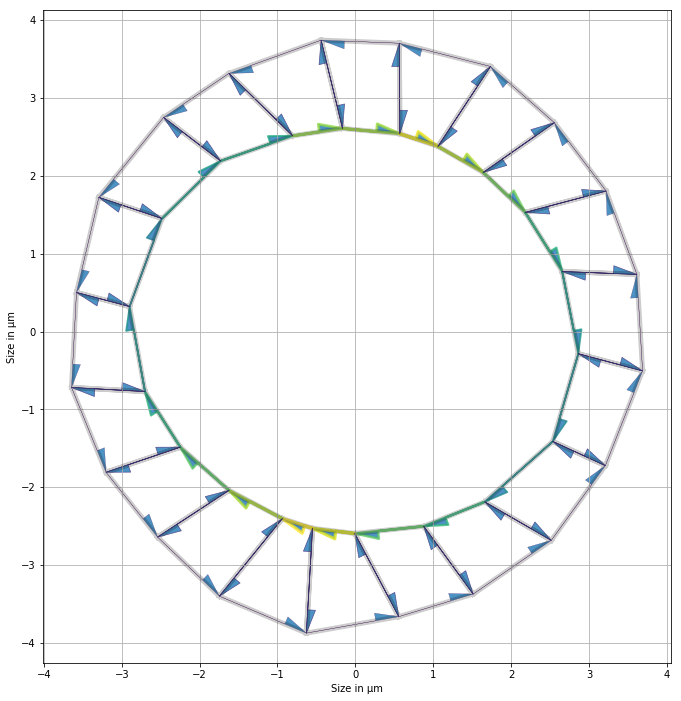

In [7]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

### Define the optimization parameters

In [8]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}

reg_weight = 1e-3
theta = 0.02

### Define a result rendering function

In [18]:
def rendering_results(x_data, y_data, title, xlabel, ylabel, legend):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, '.', markersize=10, alpha=0.4)
    plt.plot(x_data, intercept+slope*np.array(x_data), '-')
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
    print('R value :', r_value,
          '\nStandard error :', (std/organo.Ne)**0.5,
          '\nDistance :', np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1)))

# Force inference with ONLY TENSIONS solved with NNLS

Solving time: 15.580699000000003


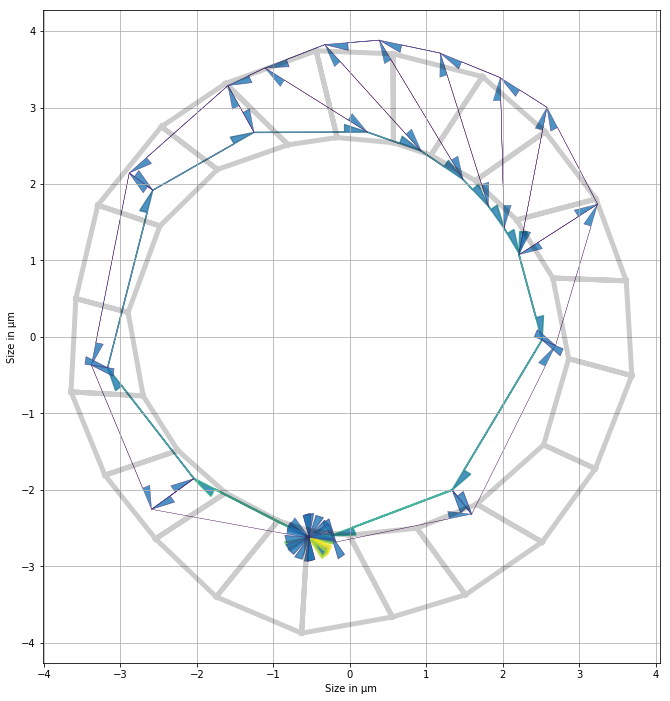

In [10]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
tensions_organo = organo.copy()
tensions_organo.edge_df.line_tension = prepare_tensions(tensions_organo,
                                                        initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(tensions_organo, False))
Solver.find_energy_min(tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_organo, False))
print_tensions(tensions_organo, organo)
#print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1))))

#### Comparaison des vraies tensions et des tensions inférées

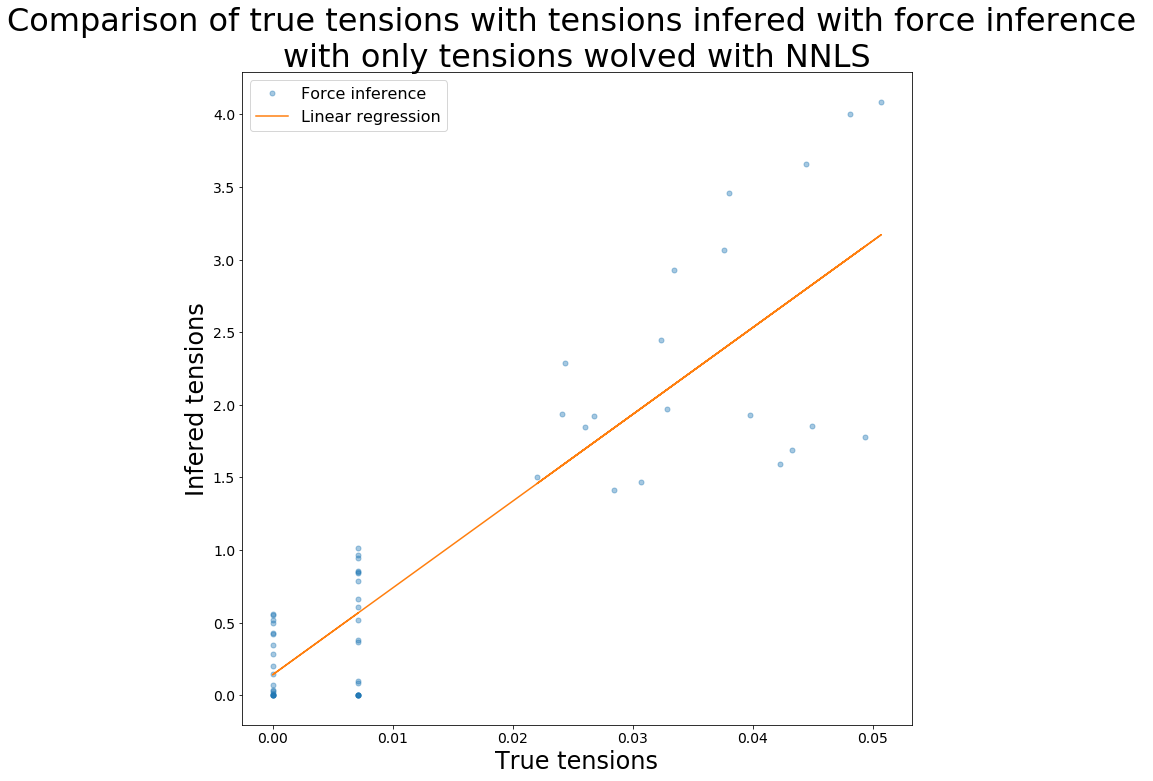

R value : 0.8878338705733065 
Standard error : 0.43967706420686414 
Distance : 44.58515060014739


In [11]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [12]:
true_tensions_t_nnls = []
errors_t_nnls  = []
infered_tensions_t_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='')
    start = time.clock()
    tmp_eptm = eptm.copy()
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     initial_guess['tensions'])
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_t_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_t_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    infered_tensions_t_nnls += list(initial_guess['tensions'])
    print(i)

Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8


Reseting datasets values with new specs


9


Reseting datasets values with new specs


10


Reseting datasets values with new specs


11


Reseting datasets values with new specs


12


Reseting datasets values with new specs


13


Reseting datasets values with new specs


14


Reseting datasets values with new specs


15


Reseting datasets values with new specs


16


Reseting datasets values with new specs


17


Reseting datasets values with new specs


18


Reseting datasets values with new specs


19


Reseting datasets values with new specs


20


Reseting datasets values with new specs


21


Reseting datasets values with new specs


22


Reseting datasets values with new specs


23


Reseting datasets values with new specs


24


Reseting datasets values with new specs


25


Reseting datasets values with new specs


26


Reseting datasets values with new specs


27


Reseting datasets values with new specs


28


Reseting datasets values with new specs


29


Reseting datasets values with new specs


30


Reseting datasets values with new specs


31


Reseting datasets values with new specs


32


Reseting datasets values with new specs


33


Reseting datasets values with new specs


34


Reseting datasets values with new specs


35


Reseting datasets values with new specs


36


Reseting datasets values with new specs


37


Reseting datasets values with new specs


38


Reseting datasets values with new specs


39


Reseting datasets values with new specs


40


Reseting datasets values with new specs


41


Reseting datasets values with new specs


42


Reseting datasets values with new specs


43


Reseting datasets values with new specs


44


Reseting datasets values with new specs


45


Reseting datasets values with new specs


46


Reseting datasets values with new specs


47


Reseting datasets values with new specs


48


Reseting datasets values with new specs


49


Reseting datasets values with new specs


50


Reseting datasets values with new specs


51


Reseting datasets values with new specs


52


Reseting datasets values with new specs


53


Reseting datasets values with new specs


54


Reseting datasets values with new specs


55


Reseting datasets values with new specs


56


Reseting datasets values with new specs


57


Reseting datasets values with new specs


58


Reseting datasets values with new specs


59


Reseting datasets values with new specs


60


Reseting datasets values with new specs


61


Reseting datasets values with new specs


62


Reseting datasets values with new specs


63


Reseting datasets values with new specs


64


Reseting datasets values with new specs


65


Reseting datasets values with new specs


66


Reseting datasets values with new specs


67


Reseting datasets values with new specs


68


Reseting datasets values with new specs


69


Reseting datasets values with new specs


70


Reseting datasets values with new specs


71


Reseting datasets values with new specs


72


Reseting datasets values with new specs


73


Reseting datasets values with new specs


74


Reseting datasets values with new specs


75


Reseting datasets values with new specs


76


Reseting datasets values with new specs


77


Reseting datasets values with new specs


78


Reseting datasets values with new specs


79


Reseting datasets values with new specs


80


Reseting datasets values with new specs


81


Reseting datasets values with new specs


82


Reseting datasets values with new specs


83


Reseting datasets values with new specs


84


Reseting datasets values with new specs


85


Reseting datasets values with new specs


86


Reseting datasets values with new specs


87


Reseting datasets values with new specs


88


Reseting datasets values with new specs


89


Reseting datasets values with new specs


90


Reseting datasets values with new specs


91


Reseting datasets values with new specs


92


Reseting datasets values with new specs


93


Reseting datasets values with new specs


94


Reseting datasets values with new specs


95


Reseting datasets values with new specs


96


Reseting datasets values with new specs


97


Reseting datasets values with new specs


98
99


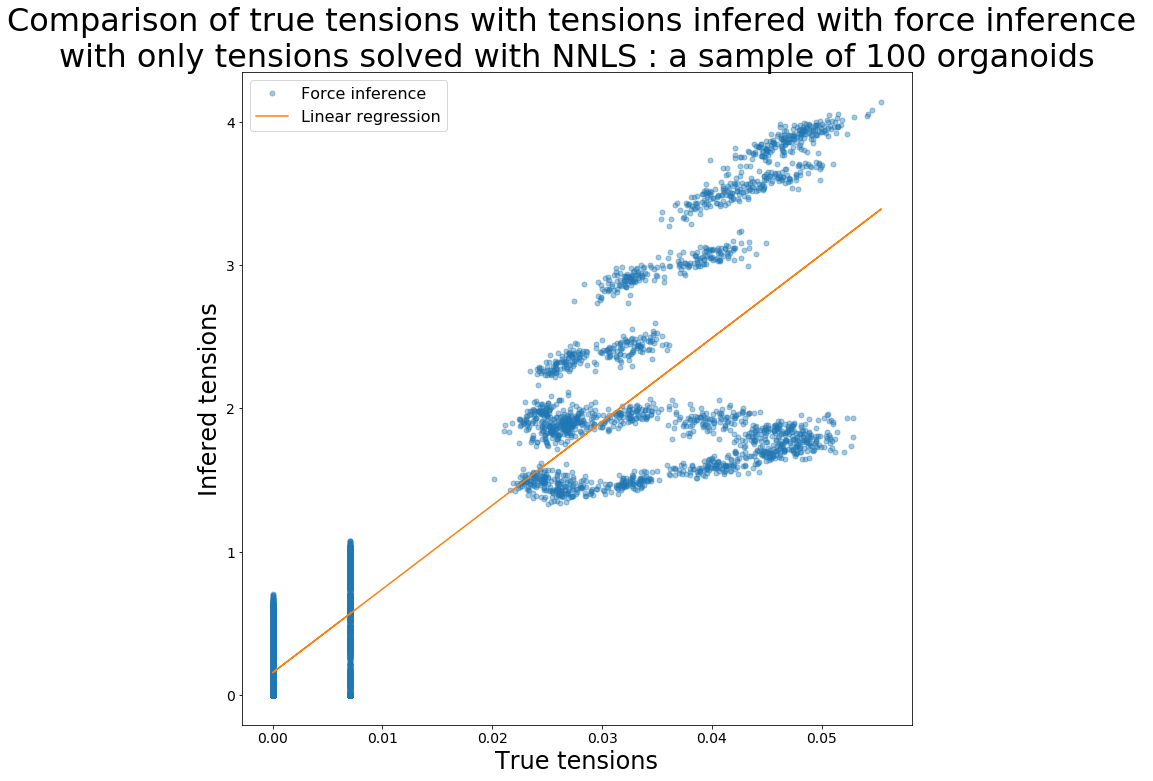

R value : 0.8875219201128816 
Standard error : 4.314231082768749 
Distance : 44.58515060014739


In [19]:
rendering_results(true_tensions_t_nnls,
                  infered_tensions_t_nnls,
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions solved with NNLS : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [26]:
print('Mean distance :', np.mean(errors_t_nnls),
      '\nMaximum distance :', np.max(errors_t_nnls))

Mean distance : 33.788987466347095 
Maximum distance : 46.43782874536335


# Rescaled force inference solved with NNLS for tensions only 

Solving time: 140.02127699999983


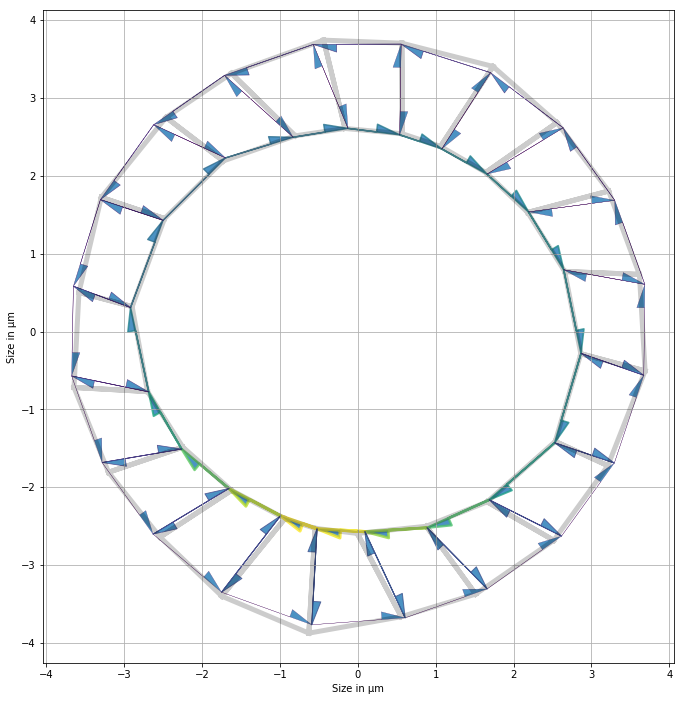

In [13]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_tensions_organo = organo.copy()
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         **{'method':'Nelder-Mead'})
rescaled_tensions_organo.edge_df.line_tension = prepare_tensions(rescaled_tensions_organo,
                                                                 opt_scale*initial_guess['tensions'])
Solver.find_energy_min(rescaled_tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_tensions_organo, organo)

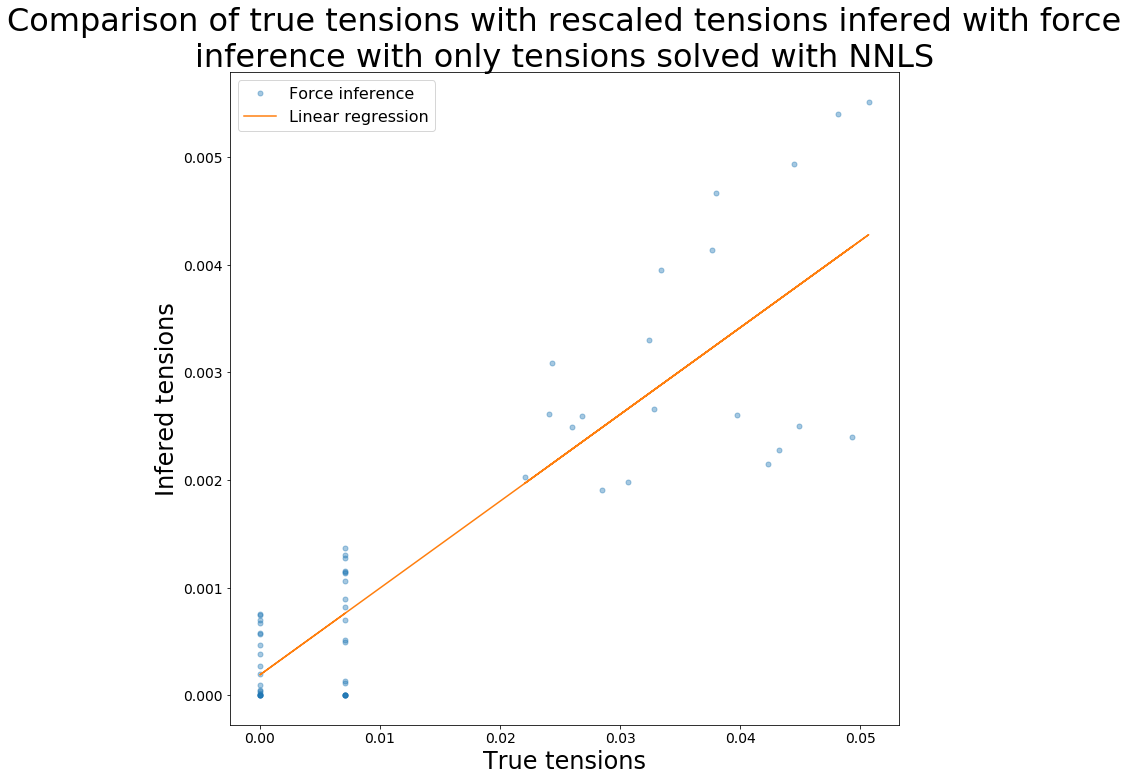

R value : 0.8878338705733061 
Standard error : 0.000593564036679267 
Distance : 44.58515060014739


In [14]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  opt_scale*initial_guess['tensions'],
                  'Comparison of true tensions with rescaled tensions infered with force\n' +
                  'inference with only tensions solved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [21]:
true_tensions_rt_nnls = []
errors_rt_nnls  = []
infered_tensions_rt_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='')
    start = time.clock()
    tmp_eptm = eptm.copy()
    opt_scale = adjust_scale(organo,
                             initial_guess['tensions'],
                             **{'method':'Nelder-Mead'})
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     opt_scale*initial_guess['tensions'])
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_rt_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_rt_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    infered_tensions_rt_nnls += list(opt_scale*initial_guess['tensions'])
    print(i)

Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8


Reseting datasets values with new specs


9


Reseting datasets values with new specs


10


Reseting datasets values with new specs


11


Reseting datasets values with new specs


12


Reseting datasets values with new specs


13


Reseting datasets values with new specs


14


Reseting datasets values with new specs


15


Reseting datasets values with new specs


16


Reseting datasets values with new specs


17


Reseting datasets values with new specs


18


Reseting datasets values with new specs


19


Reseting datasets values with new specs


20


Reseting datasets values with new specs


21


Reseting datasets values with new specs


22


Reseting datasets values with new specs


23


Reseting datasets values with new specs


24


Reseting datasets values with new specs


25


Reseting datasets values with new specs


26


Reseting datasets values with new specs


27


Reseting datasets values with new specs


28


Reseting datasets values with new specs


29


Reseting datasets values with new specs


30


Reseting datasets values with new specs


31


Reseting datasets values with new specs


32


Reseting datasets values with new specs


33


Reseting datasets values with new specs


34


Reseting datasets values with new specs


35


Reseting datasets values with new specs


36


Reseting datasets values with new specs


37


Reseting datasets values with new specs


38


Reseting datasets values with new specs


39


Reseting datasets values with new specs


40


Reseting datasets values with new specs


41


Reseting datasets values with new specs


42


Reseting datasets values with new specs


43


Reseting datasets values with new specs


44


Reseting datasets values with new specs


45


Reseting datasets values with new specs


46


Reseting datasets values with new specs


47


Reseting datasets values with new specs


48


Reseting datasets values with new specs


49


Reseting datasets values with new specs


50


Reseting datasets values with new specs


51


Reseting datasets values with new specs


52


Reseting datasets values with new specs


53


Reseting datasets values with new specs


54


Reseting datasets values with new specs


55


Reseting datasets values with new specs


56


Reseting datasets values with new specs


57


Reseting datasets values with new specs


58


Reseting datasets values with new specs


59


Reseting datasets values with new specs


60


Reseting datasets values with new specs


61


Reseting datasets values with new specs


62


Reseting datasets values with new specs


63


Reseting datasets values with new specs


64


Reseting datasets values with new specs


65


Reseting datasets values with new specs


66


Reseting datasets values with new specs


67


Reseting datasets values with new specs


68


Reseting datasets values with new specs


69


Reseting datasets values with new specs


70


Reseting datasets values with new specs


71


Reseting datasets values with new specs


72


Reseting datasets values with new specs


73


Reseting datasets values with new specs


74


Reseting datasets values with new specs


75


Reseting datasets values with new specs


76


Reseting datasets values with new specs


77


Reseting datasets values with new specs


78


Reseting datasets values with new specs


79


Reseting datasets values with new specs


80


Reseting datasets values with new specs


81


Reseting datasets values with new specs


82


Reseting datasets values with new specs


83


Reseting datasets values with new specs


84


Reseting datasets values with new specs


85


Reseting datasets values with new specs


86


Reseting datasets values with new specs


87


Reseting datasets values with new specs


88


Reseting datasets values with new specs


89


Reseting datasets values with new specs


90


Reseting datasets values with new specs


91


Reseting datasets values with new specs


92


Reseting datasets values with new specs


93


Reseting datasets values with new specs


94


Reseting datasets values with new specs


95


Reseting datasets values with new specs


96


Reseting datasets values with new specs


97


Reseting datasets values with new specs


98
99


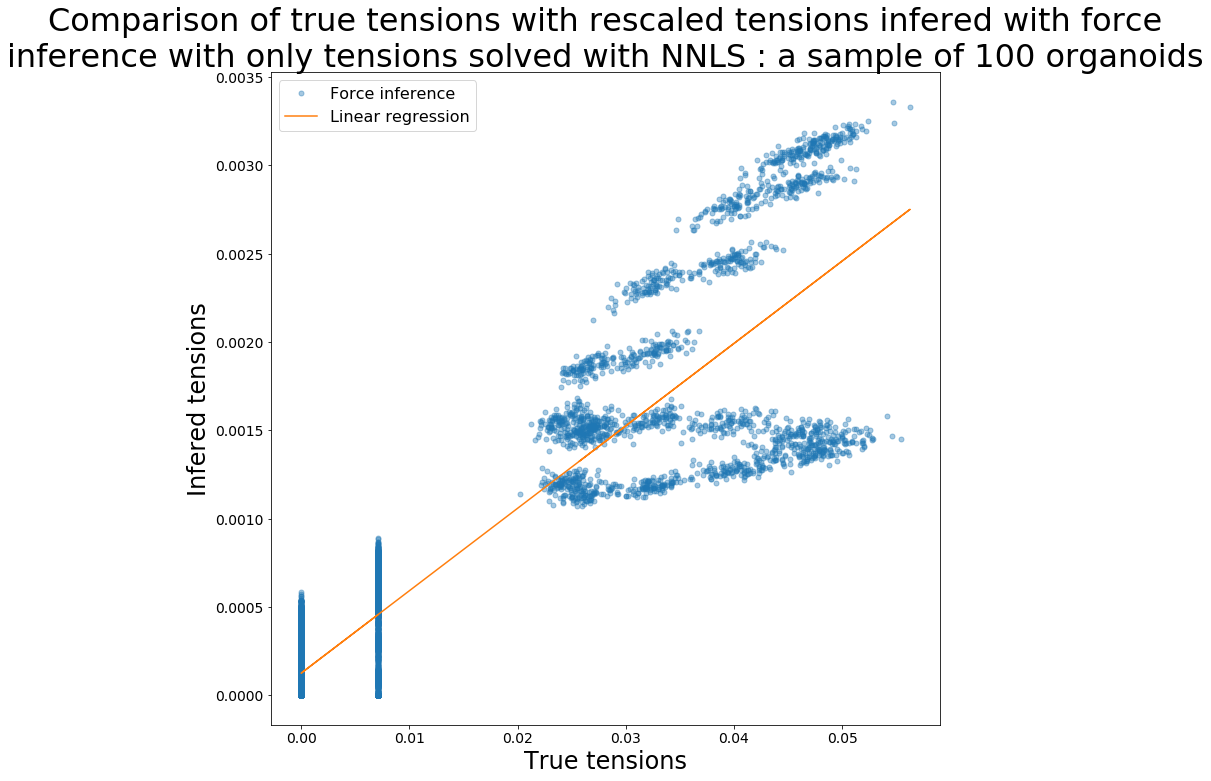

R value : 0.8875436073096493 
Standard error : 0.003458600943210863 
Distance : 44.58515060014739


In [24]:
rendering_results(true_tensions_rt_nnls,
                  infered_tensions_rt_nnls,
                  'Comparison of true tensions with rescaled tensions infered with force\n' +
                  'inference with only tensions solved with NNLS : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [25]:
print('Mean distance :', np.mean(errors_rt_nnls),
      '\nMaximum distance :', np.max(errors_rt_nnls))

Mean distance : 2.9969339241513415 
Maximum distance : 3.8719956107009867


# Force inference solved with NNLS for tensions and areas

[-1.09120786  1.41150279 -0.95131448 -0.54479915  2.18742536 -0.20296162
 -0.01326757  2.50110108  0.09538469  0.24404186  2.59334859  0.45881599
  0.6343183   2.52763622  0.90291391  1.11117099  2.40257922  0.93492625
  0.53112722  2.03955251  0.20879651  0.01359303  1.48494723 -0.11507634
 -0.24864397  0.77091591 -0.42420239 -0.63633285 -0.32088059 -0.90728253
  1.22832465 -1.45142607  1.08831196  0.82490779 -2.19073309  0.4901879
  0.25079057 -2.51368051 -0.13161452 -0.61691758 -2.60832612 -0.79590276
 -0.96093277 -2.54086657 -1.15485575 -1.22096929 -2.37817344 -1.12419327
 -0.79622796 -2.04357863 -0.4962358  -0.19386897 -1.52976865  0.16897333
  0.51028011 -0.77091293  0.800105    0.97461345  0.2847964   1.1552239 ]
[ -0.91641568   0.70846477  -1.0511771   -1.83553886   0.45715846
  -4.92704002 -75.3717696    0.3998239   10.48386311   4.09765776
   0.38560184   2.17952297   1.57649559   0.39562655   1.1075253
   0.8999515    0.41621937   1.06960308   1.88278808   0.49030363
   4.78

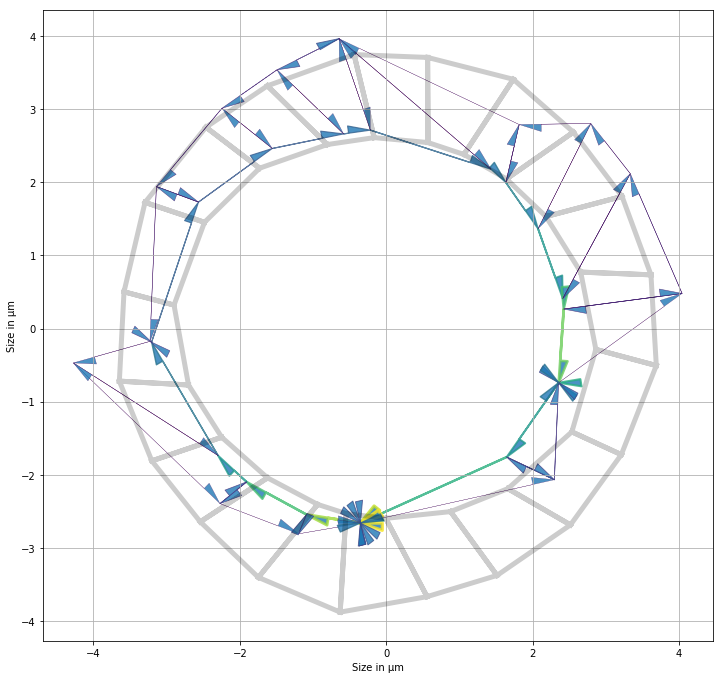

In [28]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo,
                                                     initial_guess['tensions'])
areas_organo.face_df.prefered_area = organo.face_df.area + initial_guess['areas'][:-1]
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(areas_organo, organo)

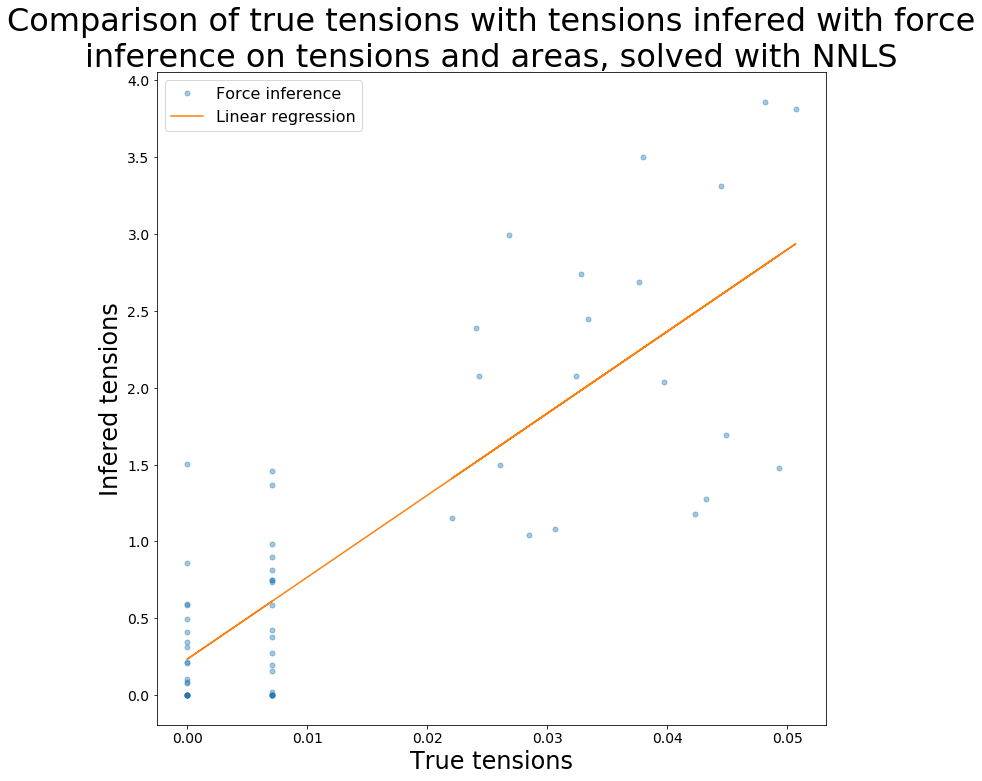

R value : 0.8194749057495146 
Standard error : 0.5291744934670118 
Distance : 44.58515060014739


In [29]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference on tensions and areas, solved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

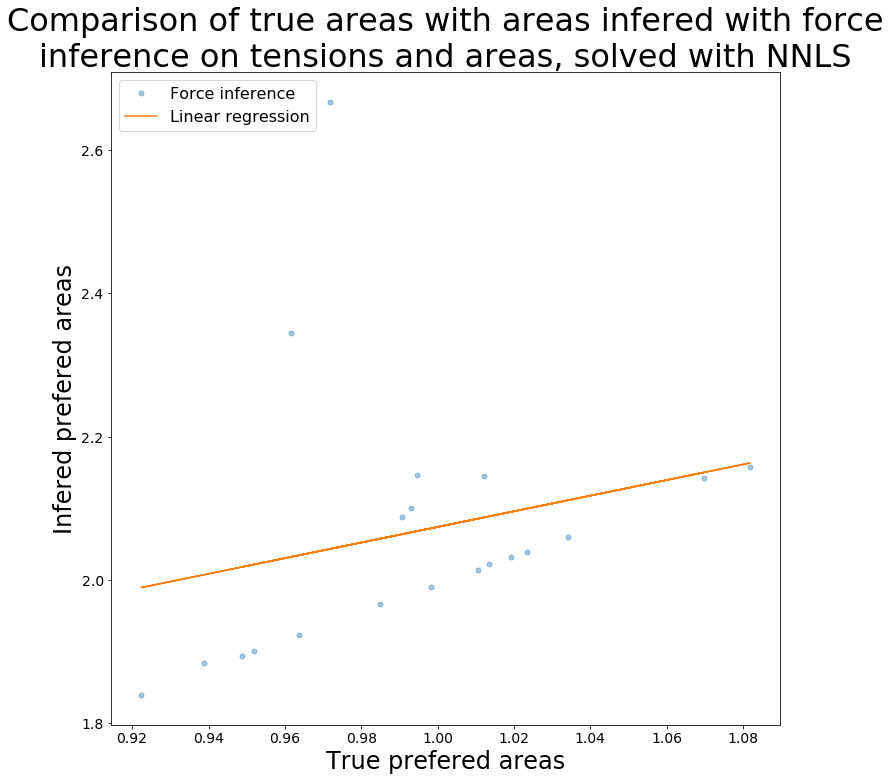

R value : 0.24202864705920177 
Standard error : 0.0875560886622406 
Distance : 44.58515060014739


In [56]:
rendering_results(organo.face_df.prefered_area,
                  areas_organo.face_df.prefered_area+organo.face_df.prefered_area,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference on tensions and areas, solved with NNLS',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

In [57]:
np.linalg.norm(organo.face_df.prefered_area-areas_organo.face_df.prefered_area+organo.face_df.prefered_area)

4.1806664844600565

In [58]:
organo.face_df.prefered_area.mean()

0.9942264757908333

#### Repeating the same process on a large popuplation of organoids

In [31]:
true_tensions_a_nnls = []
true_areas_a_nnls = []
errors_a_nnls  = []
infered_tensions_a_nnls = []
infered_areas_a_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='areas')
    start = time.clock()
    tmp_eptm = eptm.copy()
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     initial_guess['tensions'])
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_a_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_a_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    true_areas_a_nnls += list(eptm.face_df.prefered_area)
    infered_tensions_a_nnls += list(initial_guess['tensions'])
    infered_areas_a_nnls += list(initial_guess['areas'])
    print(i)

Reseting datasets values with new specs


[-1.0994031   1.39768863 -0.88399176 -0.55563532  2.13896045 -0.24114734
 -0.02647915  2.50895927  0.12176184  0.2737355   2.62125513  0.38733118
  0.65308445  2.56191757  0.97572153  1.03528724  2.37773146  0.89878863
  0.57722184  2.01444657  0.22339597  0.01767201  1.6030691  -0.09659309
 -0.25069648  0.70827767 -0.41764953 -0.62478699 -0.34837397 -0.96761744
  1.23260268 -1.36229681  1.07827562  0.82622164 -2.14595123  0.542227
  0.16357776 -2.5167405  -0.20234488 -0.47395696 -2.59274318 -0.79860774
 -1.02023358 -2.55208452 -1.13452697 -1.21589592 -2.39955701 -1.10711691
 -0.79157474 -2.05069155 -0.49310441 -0.26374214 -1.56425795  0.17059362
  0.56497947 -0.80111757  0.78259761  0.9780218   0.37097692  1.16200705]
[ -0.90958448   0.71546693  -1.13123226  -1.79974161   0.46751683
  -4.14684234 -37.76556102   0.39857164   8.21275402   3.65316157
   0.38149663   2.58176996   1.53119554   0.39033262   1.02488258
   0.96591551   0.42056894   1.11260864   1.73243617   0.49641426
   4.47

Reseting datasets values with new specs


0
[-1.21592231  1.52464796 -0.92056065 -0.50880964  2.18753729 -0.22793173
 -0.00799136  2.54226724  0.14745647  0.2473059   2.64340074  0.39926673
  0.65415394  2.55824996  0.91685704  1.09682014  2.3484878   0.9317091
  0.53882756  2.06363816  0.22445958  0.01999735  1.54995434 -0.11954044
 -0.24122624  0.75533029 -0.35426549 -0.58315534 -0.28375975 -0.99745062
  1.25874208 -1.43830999  1.14652753  0.78602596 -2.14717794  0.44629678
  0.20378639 -2.51596511 -0.12875081 -0.50008302 -2.5960971  -0.81517955
 -1.00229894 -2.5559598  -1.15021077 -1.20452724 -2.35701623 -1.12042268
 -0.82085634 -2.07350732 -0.44967832 -0.23283474 -1.64848526  0.14298306
  0.51095057 -0.90719665  0.78120898  1.00109527  0.34641598  1.14722578]
[  -0.82242097    0.65588911   -1.08629453   -1.96537157    0.45713507
   -4.38727869 -125.13512586    0.39334968    6.78166253    4.04357514
    0.37830057    2.50459136    1.52869217    0.39089222    1.09068257
    0.91172651    0.42580592    1.07329638    1.8558813

Reseting datasets values with new specs


1
[-1.03339442  1.38708032 -0.8854814  -0.55258361  2.13651579 -0.24346294
 -0.02466075  2.49224754  0.12760019  0.20287213  2.62344166  0.39104276
  0.73262753  2.54156904  1.03390369  1.0096557   2.36824129  0.82965825
  0.59450745  2.13582478  0.24576381  0.01065422  1.58615577 -0.11481842
 -0.22693818  0.67056971 -0.42963156 -0.71274008 -0.48165161 -0.95457437
  1.20342602 -1.34874169  1.08422183  0.83562432 -2.1409681   0.47761924
  0.16610503 -2.53775659 -0.0673444  -0.50321676 -2.63249571 -0.85389641
 -1.01079321 -2.55906504 -1.17859839 -1.21867938 -2.40285887 -1.06846486
 -0.78003864 -2.10518868 -0.52286301 -0.19778258 -1.54359575  0.14567074
  0.50480455 -0.67970852  0.83226578  1.00055067  0.36555298  1.15138948]
[ -0.96768473   0.72093879  -1.12932919  -1.8096809    0.46805177
  -4.10740133 -40.55026472   0.40124425   7.83697904   4.92921332
   0.38117867   2.55726511   1.36495007   0.39345774   0.96720808
   0.99043664   0.42225427   1.20531557   1.6820647    0.4682032
   4

Reseting datasets values with new specs


2
[-1.01429523  1.3800728  -0.90517662 -0.58354595  2.14575853 -0.25097159
 -0.02094889  2.5471647   0.15167966  0.26557497  2.64770172  0.38975925
  0.62666755  2.58906248  0.93929322  1.13773667  2.3443424   0.94999364
  0.53249063  2.05791254  0.19711015  0.00814736  1.5648239  -0.1430955
 -0.22549627  0.80457745 -0.33404384 -0.72633084 -0.31376255 -0.99454836
  1.23045663 -1.4708959   1.07121576  0.81525185 -2.21374982  0.53844385
  0.12122322 -2.53587716 -0.14420349 -0.43767174 -2.60797011 -0.82546619
 -1.00930635 -2.55217188 -1.14266969 -1.2537109  -2.32177911 -1.09034301
 -0.78391831 -2.10117934 -0.56552875 -0.15448998 -1.65369142  0.19107282
  0.46212463 -0.64851766  0.816087    1.01004096  0.3354053   1.1513917 ]
[ -0.98590625   0.72459946  -1.10475678  -1.71366111   0.46603566
  -3.98451469 -47.73522704   0.39259338   6.59284178   3.76541514
   0.37768605   2.56568639   1.59574243   0.3862402    1.06463027
   0.878938     0.42655885   1.05263863   1.87796732   0.4859293
   5.

Reseting datasets values with new specs


3
[-1.09663087  1.47500174 -0.99554361 -0.52981038  2.25222858 -0.18852353
 -0.02639647  2.5346225   0.10330279  0.25911423  2.62927564  0.38104008
  0.6274169   2.58741544  1.04772703  1.15512265  2.42267006  0.86820874
  0.51591706  2.06918697  0.22290976  0.02748711  1.6605899  -0.1413335
 -0.25603086  0.81435317 -0.35765478 -0.67618937 -0.43486416 -0.94013298
  1.21926032 -1.49589213  1.110584    0.84379482 -2.17128165  0.48470355
  0.16197263 -2.52772624 -0.17280354 -0.48431121 -2.61710116 -0.78478874
 -0.99583754 -2.58270047 -1.15846327 -1.28132    -2.33443415 -1.07366083
 -0.77440659 -2.07063875 -0.49902693 -0.16453893 -1.6191246   0.15478843
  0.45608272 -0.71826     0.79705882  1.01930377  0.26114136  1.14160851]
[ -0.91188387   0.6779653   -1.00447634  -1.88746774   0.44400467
  -5.30437763 -37.88385208   0.39453607   9.68028067   3.85930168
   0.38033289   2.62439586   1.59383656   0.38648606   0.95444707
   0.86570894   0.41276772   1.15179674   1.93829606   0.4832816
   4.

Reseting datasets values with new specs


4
[-1.13847021  1.43770744 -0.98081137 -0.53415842  2.19348275 -0.21792816
 -0.0189175   2.50602428  0.13091425  0.25434205  2.62933906  0.40607168
  0.64227304  2.54385927  0.89034198  1.08523706  2.36751056  0.96086837
  0.55946996  2.03517518  0.24415887  0.01091577  1.55536719 -0.1203911
 -0.25214455  0.7506291  -0.46300748 -0.6085472  -0.22531678 -0.85021706
  1.19816275 -1.41984502  1.12742302  0.86011329 -2.14705352  0.4382751
  0.14514155 -2.53878494 -0.10955472 -0.50195521 -2.63537127 -0.8033665
 -0.98657888 -2.56061648 -1.12727853 -1.21847835 -2.39458908 -1.10611658
 -0.82868497 -2.05632738 -0.46655859 -0.210845   -1.46857411  0.12362498
  0.56775009 -0.83923298  0.76323962  0.97537474  0.23186001  1.1603122 ]
[ -0.87837169   0.6955518   -1.01956404  -1.87210379   0.45589599
  -4.58866822 -52.86111777   0.39903843   7.63858764   3.93171326
   0.38032371   2.46261939   1.55697023   0.39310351   1.12316393
   0.92145766   0.4223846    1.04072527   1.78740607   0.49135819
   4.0

Reseting datasets values with new specs


5
[-1.05742114e+00  1.37169717e+00 -8.91980212e-01 -5.77406777e-01
  2.13453133e+00 -2.45348171e-01 -3.68798364e-03  2.52651073e+00
  1.08019563e-01  1.60022212e-01  2.62522767e+00  4.33571745e-01
  7.77098205e-01  2.53388670e+00  9.33384603e-01  1.04247686e+00
  2.40918854e+00  9.32520003e-01  5.64102161e-01  2.21384227e+00
  2.23779403e-01  2.37128025e-03  1.54204505e+00 -1.35639968e-01
 -2.02459132e-01  6.59645863e-01 -3.79068892e-01 -7.05095691e-01
 -3.24724153e-01 -9.79238074e-01  1.21832212e+00 -1.42530786e+00
  1.11094004e+00  7.99767104e-01 -2.18976416e+00  4.78281870e-01
  2.28809604e-01 -2.55351218e+00 -6.89138752e-02 -5.80961214e-01
 -2.63732296e+00 -8.66687366e-01 -9.44322011e-01 -2.55825474e+00
 -1.17058602e+00 -1.23099267e+00 -2.36604303e+00 -1.09103786e+00
 -7.94309571e-01 -2.15333648e+00 -4.66367967e-01 -2.01131749e-01
 -1.60790524e+00  1.05695868e-01  5.04584831e-01 -7.43145096e-01
  8.22462799e-01  1.00023355e+00  3.50570903e-01  1.14621250e+00]
[-9.45697004e-01  7.29

Reseting datasets values with new specs


6
[-1.10754174  1.47758364 -0.9060492  -0.51620265  2.13099597 -0.23207329
 -0.0238408   2.50998894  0.12624302  0.24308296  2.59514255  0.3784861
  0.64828667  2.55767055  0.96544109  1.11699757  2.34265651  0.93216797
  0.5278574   2.07150462  0.20473296  0.01592118  1.58568432 -0.14469155
 -0.22125681  0.77493129 -0.36795396 -0.68330378 -0.34519786 -0.95630313
  1.22559097 -1.45906385  1.11047907  0.78685099 -2.20953379  0.52107103
  0.2211871  -2.51477865 -0.18845537 -0.51192916 -2.61899972 -0.780633
 -1.00096198 -2.546621   -1.17576612 -1.2389533  -2.32961661 -1.07671593
 -0.8312617  -2.10410739 -0.50447991 -0.13459623 -1.59370869  0.12536211
  0.47176443 -0.73749984  0.82559502  1.01230888  0.31889757  1.14354311]
[ -0.90290051   0.67678064  -1.10369282  -1.93722368   0.46926414
  -4.30898361 -41.94489321   0.39840813   7.92123013   4.11382182
   0.38533529   2.64210497   1.54252748   0.39098077   1.03579598
   0.8952571    0.42686582   1.07276804   1.89445104   0.4827409
   4.88

Reseting datasets values with new specs


7
[-1.08624015  1.39609737 -0.9126515  -0.56787861  2.16221098 -0.22524902
 -0.00966463  2.53185459  0.11047614  0.2481196   2.61270902  0.4346504
  0.62311032  2.55118385  0.88619195  1.11372444  2.39175674  0.98301559
  0.5814338   2.05494465  0.22798708  0.02396082  1.52245594 -0.12807308
 -0.29474483  0.80872401 -0.40959847 -0.63182075 -0.24992797 -0.96674911
  1.23563069 -1.41872487  1.0806786   0.80511588 -2.21595915  0.53254085
  0.20809143 -2.58159247 -0.16946265 -0.53888908 -2.67193332 -0.78754903
 -0.97731403 -2.6295141  -1.14477783 -1.22960328 -2.41578716 -1.14089549
 -0.79908389 -2.04002445 -0.50775352 -0.19523309 -1.59659023  0.2323543
  0.45847033 -0.77638294  0.76237363  1.03281504  0.33690799  1.14249115]
[  -0.92060673    0.71628242   -1.0957085    -1.76093971    0.46248956
   -4.43953103 -103.47008264    0.39496739    9.05172845    4.03031445
    0.3827445     2.30069958    1.60485224    0.39197489    1.1284237
    0.89788817    0.41810272    1.01727786    1.71988626 

Reseting datasets values with new specs


8
[-1.1569916   1.45281958 -0.93340155 -0.53103181  2.15658333 -0.23004295
 -0.03247107  2.5148832   0.13105761  0.24600534  2.61666923  0.37030623
  0.70246401  2.57982533  0.95718244  1.05708158  2.35455402  0.94722205
  0.54946334  2.08781465  0.22345669  0.02965742  1.61394155 -0.13017199
 -0.26278754  0.68288662 -0.41661509 -0.60138968 -0.30042334 -0.91899344
  1.24795756 -1.43127655  1.11881441  0.79207302 -2.19486743  0.53888127
  0.18312401 -2.53020322 -0.22173386 -0.46259275 -2.64178081 -0.79766459
 -1.00746566 -2.58951805 -1.16027654 -1.227867   -2.38143682 -1.08693324
 -0.82175551 -2.06394297 -0.49412336 -0.19303123 -1.54820664  0.18709618
  0.52297339 -0.86116361  0.76399974  0.96658416  0.28978023  1.15194   ]
[ -0.86431051   0.68831671  -1.07135027  -1.88312635   0.46369643
  -4.3470143  -30.7966492    0.39763278   7.63023238   4.06495234
   0.38216523   2.70046764   1.42356047   0.38762314   1.04473291
   0.94600078   0.42470888   1.05571867   1.81995764   0.47896972
   

Reseting datasets values with new specs


9
[-1.17024201  1.4600387  -0.92953236 -0.53987514  2.21465729 -0.20778724
 -0.01212089  2.53978899  0.11899225  0.2427191   2.63023176  0.36285491
  0.69110498  2.56403078  1.01661754  1.06036775  2.39224725  0.90803289
  0.52046911  2.07859257  0.20001175  0.00486756  1.66653744 -0.08900519
 -0.2031947   0.69638261 -0.44802868 -0.59409575 -0.36669765 -0.93215589
  1.22861479 -1.42435289  1.13270654  0.79258245 -2.18276343  0.49998073
  0.2343512  -2.4652911  -0.19243516 -0.50477951 -2.58278694 -0.82601391
 -1.01532813 -2.47502622 -1.13909136 -1.22603377 -2.40477655 -1.09504393
 -0.83599312 -2.06863681 -0.44771962 -0.25607934 -1.5087192   0.08300598
  0.62038872 -0.88044531  0.79631425  0.96227672  0.35559257  1.18829646]
[ -0.8545241    0.68491335  -1.07580978  -1.85228013   0.45153713
  -4.81261512 -82.50216705   0.3937335    8.40390832   4.11998886
   0.38019463   2.75592248   1.44695818   0.39001092   0.98365409
   0.94306904   0.41801699   1.10128169   1.92134363   0.48109476
   

Reseting datasets values with new specs


10
[-1.13169653  1.45516438 -0.92196539 -0.53327582  2.171788   -0.20868716
 -0.02108791  2.52171602  0.06602419  0.23362951  2.58916233  0.46176578
  0.68470644  2.56389184  0.89841532  1.058689    2.45711394  0.95723429
  0.59001845  2.09663282  0.23875341  0.02831105  1.53358239 -0.10025956
 -0.28930327  0.72721993 -0.4655298  -0.61999094 -0.26324825 -0.92575107
  1.22437225 -1.39015807  1.08935373  0.79394063 -2.17771682  0.53582419
  0.29010768 -2.57019498 -0.21872563 -0.61367049 -2.65522365 -0.75751558
 -0.942725   -2.62681709 -1.19375666 -1.21328776 -2.45470453 -1.10412661
 -0.85399539 -2.04821055 -0.480456   -0.2121645  -1.52364493  0.1998518
  0.53324692 -0.80822867  0.76058348  0.99417566  0.32785721  1.16896729]
[ -0.88362911   0.68720758  -1.08463941  -1.87520223   0.4604501
  -4.79186155 -47.42052632   0.39655536  15.14596378   4.28028112
   0.3862253    2.16560008   1.46047991   0.39003205   1.11307096
   0.94456445   0.40698153   1.04467633   1.69486224   0.47695524
   4

Reseting datasets values with new specs


11
[-1.05284332  1.40382615 -0.90800279 -0.54876016  2.15907053 -0.23376618
 -0.02689081  2.50134647  0.09525684  0.22116234  2.62660289  0.47175215
  0.71593122  2.55512809  0.93277506  1.06191307  2.43608921  0.88849621
  0.54573277  2.11280342  0.24617186  0.02393083  1.49258492 -0.11330262
 -0.24449066  0.68094098 -0.42953605 -0.69568527 -0.3729652  -0.94984448
  1.22321608 -1.44288515  1.0733353   0.81016823 -2.14995763  0.45951413
  0.2449173  -2.53435068 -0.10033886 -0.578905   -2.64230136 -0.79142754
 -1.00087768 -2.58221235 -1.18150572 -1.20129849 -2.41569611 -1.06900291
 -0.78378447 -2.09323103 -0.51017347 -0.20579495 -1.55662401  0.13418585
  0.51172878 -0.70186049  0.82561309  0.98063021  0.34306495  1.15980013]
[ -0.94980894   0.71233892  -1.1013182   -1.82228972   0.46316227
  -4.27777882 -37.18742842   0.39978468  10.49793412   4.52156556
   0.3807199    2.11975718   1.39678223   0.39136981   1.07206983
   0.94169667   0.410494     1.1254972    1.83239868   0.4733048
   

Reseting datasets values with new specs


12
[-1.16376472  1.43387367 -0.90685126 -0.5516302   2.18976828 -0.22698052
 -0.03057724  2.53713406  0.12305914  0.23463863  2.64372931  0.39333433
  0.69697937  2.59828854  0.96715097  1.06582341  2.39761104  0.93103688
  0.55220122  2.12901128  0.20922947  0.02851879  1.61094237 -0.10076162
 -0.26266404  0.73505255 -0.46123081 -0.56952523 -0.32335957 -0.92798659
  1.22516716 -1.39659427  1.10475327  0.79474515 -2.18543333  0.48132629
  0.18894614 -2.50099672 -0.10454788 -0.53767584 -2.60389227 -0.81043332
 -0.95011766 -2.5580343  -1.18778584 -1.22995528 -2.40236904 -1.08344287
 -0.81880354 -2.03270623 -0.52049981 -0.22198287 -1.47990743  0.19795457
  0.5489214  -0.89365577  0.75487418  1.00075535  0.37606576  1.16780141]
[ -0.85928022   0.69741151  -1.10271667  -1.81280867   0.45666932
  -4.40566445 -32.70406689   0.39414551   8.12617415   4.26187287
   0.37825355   2.54236642   1.4347627    0.38486873   1.03396474
   0.93824173   0.41708183   1.07407131   1.81093405   0.4697016
   

Reseting datasets values with new specs


13
[-1.08753861  1.4316567  -0.87910405 -0.55648267  2.12783531 -0.24627373
 -0.02322896  2.54462205  0.09523551  0.28490132  2.62038277  0.41425145
  0.60520764  2.59107997  0.98386658  1.1343787   2.42991175  0.91448133
  0.55903327  2.02127734  0.21988106 -0.01706774  1.60140886 -0.10905267
 -0.1614724   0.81086205 -0.45136311 -0.73773055 -0.3663243  -0.94192236
  1.21438018 -1.45789534  1.08637187  0.78684591 -2.19528696  0.48373058
  0.27035562 -2.57596188 -0.18356446 -0.50762582 -2.63504908 -0.77519611
 -1.03607236 -2.54182641 -1.12616668 -1.27000574 -2.41694374 -1.09646882
 -0.73534437 -2.21888162 -0.55982701 -0.19054128 -1.51421752  0.15051188
  0.52937879 -0.74342052  0.82442403  0.93862907  0.36962721  1.19618472]
[ -0.91950758   0.69849147  -1.13752178  -1.79700115   0.46996118
  -4.06052245 -43.04970332   0.39298567  10.50028527   3.50998727
   0.38162364   2.41399276   1.65232546   0.38593946   1.01639798
   0.88153983   0.41153758   1.09351604   1.7888023    0.49473666
  

Reseting datasets values with new specs


14
[-1.14958680e+00  1.45043444e+00 -9.65366085e-01 -5.59380380e-01
  2.21732768e+00 -2.09681369e-01 -1.14263577e-02  2.56919520e+00
  1.03221221e-01  2.53238827e-01  2.63669041e+00  4.23250673e-01
  6.15082035e-01  2.59204791e+00  9.48820082e-01  1.13670305e+00
  2.43024797e+00  9.16583763e-01  5.57547705e-01  2.08557026e+00
  2.42301780e-01 -4.85836540e-04  1.58374663e+00 -1.43882453e-01
 -2.54563283e-01  8.55406190e-01 -3.29443661e-01 -5.87128966e-01
 -3.13893538e-01 -9.85803951e-01  1.25975252e+00 -1.41799991e+00
  1.09281784e+00  8.48785423e-01 -2.14706106e+00  5.06158812e-01
  1.85584823e-01 -2.53309532e+00 -1.49253240e-01 -5.56894975e-01
 -2.63166462e+00 -7.74687840e-01 -9.67297728e-01 -2.53212365e+00
 -1.17454884e+00 -1.24339595e+00 -2.34389972e+00 -1.11159022e+00
 -8.01804725e-01 -2.02299708e+00 -5.11682298e-01 -1.97323980e-01
 -1.68501240e+00  1.80534654e-01  4.53002702e-01 -8.48739153e-01
  8.20769281e-01  1.01959189e+00  2.86595505e-01  1.12148185e+00]
[-8.69877772e-01  6.8

Reseting datasets values with new specs


15
[-1.13457523  1.46730499 -0.9443854  -0.51275435  2.21564553 -0.20269745
 -0.02733813  2.49281369  0.14064499  0.23116778  2.62104042  0.40789123
  0.68384206  2.54748995  0.93820834  1.02423607  2.33975044  0.88855231
  0.59946947  2.08515439  0.24661107  0.01582933  1.52396798 -0.11609302
 -0.27345154  0.71747027 -0.43959806 -0.60642545 -0.35244871 -0.91913403
  1.2267101  -1.33100187  1.09172681  0.85619109 -2.12955332  0.47553018
  0.0983949  -2.52994081 -0.10204905 -0.48479397 -2.62277547 -0.81629943
 -0.99010532 -2.56159947 -1.1598016  -1.2016223  -2.39058943 -1.07805728
 -0.81329829 -2.01469639 -0.52904105 -0.24048831 -1.51139332  0.18208077
  0.56110464 -0.80184548  0.76922152  0.98790746  0.32687474  1.16668914]
[ -0.88138712   0.68152157  -1.05888973  -1.95025162   0.45133573
  -4.93346129 -36.5789443    0.40115313   7.11010034   4.32586235
   0.38152788   2.45163398   1.46232597   0.39254326   1.06586134
   0.97633742   0.42739601   1.12542615   1.66814166   0.4795808
   

Reseting datasets values with new specs


16
[-1.06153147  1.41507743 -0.88676872 -0.55486057  2.15674481 -0.23209486
 -0.02710519  2.52479857  0.08920838  0.28636821  2.62093452  0.49237036
  0.64977517  2.57900896  0.86504471  1.06223984  2.44251776  0.94823456
  0.55624302  2.00627254  0.2328383   0.02020259  1.45777703 -0.10748086
 -0.23546848  0.7067222  -0.44983633 -0.6958631  -0.2723124  -0.95151555
  1.21891017 -1.41775747  1.08010672  0.8074787  -2.16878151  0.50783357
  0.23198726 -2.5302435  -0.18595014 -0.57951652 -2.63445811 -0.76161513
 -0.97313685 -2.57064868 -1.17631131 -1.18510275 -2.41949639 -1.10703832
 -0.821367   -2.09971172 -0.43935528 -0.24558939 -1.51982372  0.0798546
  0.56257999 -0.70798551  0.83663614  0.98375639  0.38320737  1.16583916]
[ -0.94203519   0.70667511  -1.12768975  -1.80225458   0.46366172
  -4.30858322 -36.89329924   0.3960712   11.20970882   3.49200772
   0.3815433    2.03099145   1.53899387   0.38774584   1.15600961
   0.94140698   0.4094136    1.05459139   1.79777538   0.49843677
   

Reseting datasets values with new specs


17
[-1.04362191  1.36117317 -0.89231305 -0.58756165  2.15602306 -0.24725145
 -0.03499332  2.53629647  0.14144004  0.2759998   2.65052595  0.41462064
  0.57906813  2.60628311  0.92472524  1.20530826  2.36764588  0.95228426
  0.51183797  2.05428351  0.20949167  0.02060169  1.5384046  -0.13703536
 -0.26051686  0.89614725 -0.33793728 -0.66612212 -0.31104589 -1.02802471
  1.23414362 -1.51446927  1.08754123  0.83451727 -2.2156144   0.51257351
  0.17747239 -2.5381452  -0.19983239 -0.47443569 -2.63459773 -0.76385725
 -1.02208601 -2.57934859 -1.15850075 -1.24811999 -2.36052701 -1.14551557
 -0.80975478 -2.05831488 -0.46638115 -0.15045239 -1.68465245  0.17118286
  0.42273116 -0.72607064  0.82991669  1.03598443  0.37139696  1.13287283]
[ -0.95820143   0.73466038  -1.12068293  -1.70194907   0.46381693
  -4.0444657  -28.57688028   0.39427567   7.0701339    3.62319102
   0.37728361   2.41184328   1.72691251   0.38368817   1.08140229
   0.82966328   0.42236046   1.05010662   1.95374329   0.48678773
  

Reseting datasets values with new specs


18
[-1.05713036  1.40528075 -0.8866968  -0.55197494  2.17798824 -0.22096586
 -0.01900929  2.50923064  0.10965549  0.26559718  2.61991995  0.42197398
  0.67039398  2.54724923  0.94655228  1.03329978  2.40060898  0.88932865
  0.5594808   2.01605487  0.25425507  0.04083364  1.55666102 -0.1100162
 -0.29352198  0.67526692 -0.40775977 -0.6479688  -0.33644355 -0.99632685
  1.25354181 -1.39133265  1.05927221  0.81180275 -2.11510086  0.51269216
  0.20334144 -2.51029425 -0.18160772 -0.5453367  -2.623611   -0.76216145
 -1.01750876 -2.59196154 -1.14458834 -1.2174019  -2.40357861 -1.08039633
 -0.79252518 -2.00491757 -0.54126973 -0.22302849 -1.58805907  0.2051175
  0.497845   -0.70897997  0.80304632  1.02927003  0.40459463  1.12989539]
[ -0.94595713   0.71160158  -1.12778122  -1.81167644   0.4591393
  -4.52558605 -52.60584563   0.39852853   9.11947069   3.76510024
   0.38169105   2.36981436   1.49166018   0.39258035   1.05646568
   0.96777336   0.41656097   1.1244437    1.78737143   0.49601825
   3.

Reseting datasets values with new specs


19
[-1.08916778e+00  1.42689197e+00 -9.24133541e-01 -5.54013821e-01
  2.22023106e+00 -1.96760401e-01 -1.21500853e-03  2.53491961e+00
  1.46842683e-01  2.36125123e-01  2.61375186e+00  3.71253988e-01
  6.54885534e-01  2.53734963e+00  9.24560588e-01  1.11426941e+00
  2.32006649e+00  9.83220589e-01  5.27362121e-01  2.06509938e+00
  1.90602180e-01  1.54729075e-02  1.57755852e+00 -1.24897878e-01
 -2.38939200e-01  7.55328313e-01 -3.71891897e-01 -6.64779286e-01
 -2.71562657e-01 -9.98796312e-01  1.24438530e+00 -1.47321051e+00
  1.10345905e+00  7.80493674e-01 -2.23800383e+00  5.09612064e-01
  1.61921963e-01 -2.52793475e+00 -1.68734208e-01 -4.52445646e-01
 -2.61920820e+00 -8.25415223e-01 -9.94733797e-01 -2.55888057e+00
 -1.13464784e+00 -1.24550269e+00 -2.36941244e+00 -1.09754805e+00
 -8.00356872e-01 -2.08100216e+00 -5.06374369e-01 -1.90522315e-01
 -1.62562865e+00  1.50979463e-01  5.00541990e-01 -7.51443593e-01
  7.94325965e-01  9.96218387e-01  3.71963978e-01  1.17434315e+00]
[-9.18132191e-01  7.0

Reseting datasets values with new specs


20
[-1.07045513  1.37659913 -0.89310439 -0.5808654   2.15701267 -0.2297853
 -0.01655802  2.53832993  0.11581157  0.24666973  2.61658327  0.42427266
  0.68984279  2.57144598  0.91556216  1.04638905  2.38496014  0.9555839
  0.57227157  2.07810651  0.21930338  0.02752355  1.53641481 -0.1324128
 -0.2875183   0.69842093 -0.43171237 -0.62729984 -0.2947095  -0.94351881
  1.2252385  -1.39435717  1.08640965  0.78888581 -2.20587731  0.53336586
  0.19986528 -2.53890031 -0.18806178 -0.51639838 -2.64448407 -0.78363919
 -0.99188793 -2.5939474  -1.15240084 -1.20349245 -2.37965847 -1.07477453
 -0.84010855 -2.01891081 -0.55187123 -0.14136538 -1.51623373  0.18214507
  0.48264087 -0.76431114  0.80500881  0.99662224  0.37080389  1.14381817]
[ -0.93418208   0.72642789  -1.11968994  -1.72156922   0.46360414
  -4.35188842 -60.39367739   0.39395982   8.63471607   4.05400363
   0.38217779   2.35697486   1.44960564   0.38888626   1.09222513
   0.9556675    0.41929422   1.04648058   1.74742212   0.48120729
   4.

Reseting datasets values with new specs


21
[-1.0551402   1.38613873 -0.87453928 -0.59305026  2.16599114 -0.24488826
 -0.01288407  2.57223924  0.11204014  0.29746931  2.65576767  0.46573129
  0.65211183  2.59800738  0.87561729  1.04092746  2.4316874   0.95615725
  0.56659871  2.00306875  0.2222724   0.0077495   1.50022481 -0.0749243
 -0.20671507  0.69884509 -0.51044763 -0.69706721 -0.25100977 -0.9270189
  1.23945065 -1.38300982  1.07219792  0.77764913 -2.16332428  0.53385018
  0.21138535 -2.51620724 -0.21098823 -0.50692476 -2.60786907 -0.77824339
 -1.01647549 -2.53170623 -1.13075258 -1.21539724 -2.45802048 -1.0920904
 -0.81567741 -2.11827608 -0.52271051 -0.25955153 -1.43712522  0.14496544
  0.61517012 -0.72414167  0.80959991  0.97037118  0.41691258  1.17417166]
[ -0.94774136   0.72142851  -1.14345921  -1.68619773   0.4616824
  -4.08349502 -77.61524299   0.38876633   8.92537292   3.3616913
   0.37653896   2.14716086   1.53347931   0.38491038   1.14205145
   0.96068174   0.41123707   1.04585307   1.76491755   0.49923399
   4.49

Reseting datasets values with new specs


22
[-1.10688065  1.41766493 -0.9438946  -0.54775679  2.20653722 -0.20179707
 -0.0265668   2.51317851  0.12160625  0.26547232  2.61013136  0.4131534
  0.62610703  2.56631211  0.95331299  1.10328848  2.36691886  0.89919899
  0.55483591  2.03536747  0.22813921  0.01782975  1.54061206 -0.11820881
 -0.25804559  0.78315341 -0.42062179 -0.62828366 -0.36601391 -0.93088856
  1.24120976 -1.42342355  1.08974205  0.78389859 -2.16441188  0.56064933
  0.18666805 -2.53309537 -0.19649409 -0.49434949 -2.6206903  -0.80925256
 -0.9937263  -2.56875487 -1.15058828 -1.22252277 -2.38427268 -1.11141748
 -0.81732714 -2.05266368 -0.45514861 -0.21350873 -1.5430291   0.13922694
  0.56414705 -0.79609636  0.77943963  0.96551098  0.31874802  1.15384307]
[ -0.90343977   0.7053853   -1.05944032  -1.82562777   0.45319879
  -4.95547335 -37.64095961   0.3979025    8.22326161   3.76687102
   0.38312248   2.42040849   1.59717102   0.38966422   1.04897344
   0.90638126   0.42249019   1.1121009    1.80233467   0.49131177
   

Reseting datasets values with new specs


23
[-1.12466042  1.43565612 -0.94860923 -0.54952713  2.20129664 -0.19948691
 -0.01077572  2.53471038  0.1228421   0.29199462  2.60027046  0.40406108
  0.5816371   2.55626183  0.88297303  1.10781765  2.35458625  1.01327192
  0.57467481  1.97227259  0.19940665  0.02231565  1.54646408 -0.10113812
 -0.2667915   0.80899838 -0.46372368 -0.62668507 -0.21948198 -0.90959686
  1.22805876 -1.40663691  1.10135657  0.77991839 -2.24602582  0.5888332
  0.19921054 -2.55598654 -0.27599011 -0.5183614  -2.64483912 -0.73842727
 -0.98458313 -2.60061785 -1.13504151 -1.22707533 -2.44256288 -1.14092339
 -0.80090136 -2.06703485 -0.49014798 -0.24408329 -1.51511553  0.18173051
  0.56619584 -0.81366472  0.74421406  1.00162099  0.30407818  1.16439591]
[ -0.88915728   0.69654563  -1.05417486  -1.81974637   0.45427771
  -5.0128603  -92.80119931   0.39452239   8.14053149   3.42472065
   0.38457538   2.47487332   1.71928509   0.39119623   1.13253742
   0.90267564   0.42470307   0.98690192   1.74011454   0.5070293
   5

Reseting datasets values with new specs


24
[-1.1077876   1.50091241 -0.91182757 -0.51729607  2.20145023 -0.20406614
 -0.02495725  2.53550454  0.12374583  0.26621882  2.60958252  0.39533544
  0.65385477  2.58541904  0.89966653  1.10805113  2.36209085  1.02056047
  0.52797022  2.0529814   0.17959531  0.02513686  1.57141997 -0.12193793
 -0.22165773  0.74527186 -0.40265769 -0.70953316 -0.22791309 -0.97841426
  1.23227981 -1.47083041  1.11718699  0.7497465  -2.26903402  0.53444124
  0.22472664 -2.52677085 -0.23584206 -0.4836915  -2.62822464 -0.78915806
 -0.98104877 -2.57704458 -1.15976073 -1.2321054  -2.38434879 -1.09380997
 -0.86506785 -2.13372911 -0.49186233 -0.1749651  -1.57903342  0.13808287
  0.51403433 -0.71466278  0.79613938  1.01609133  0.37779509  1.18458266]
[ -0.90270012   0.6662614   -1.09669858  -1.93312895   0.45424602
  -4.90037189 -40.06851707   0.39439882   8.08108014   3.75630843
   0.38320306   2.52949745   1.5293916    0.3867845    1.11152296
   0.90248543   0.42335374   0.97985375   1.89404622   0.48709647
  

Reseting datasets values with new specs


25
[-1.11195845e+00  1.48677576e+00 -9.19030832e-01 -5.24129992e-01
  2.19758798e+00 -1.86389544e-01  7.71249649e-04  2.53503575e+00
  1.20016185e-01  2.67580276e-01  2.57036707e+00  3.53433522e-01
  5.65133926e-01  2.53349325e+00  9.36315742e-01  1.12416791e+00
  2.33033470e+00  9.55943726e-01  5.95239190e-01  1.99833269e+00
  2.46259891e-01 -1.48820379e-03  1.62346766e+00 -1.01686167e-01
 -2.15946442e-01  8.68064843e-01 -4.09759081e-01 -6.99369472e-01
 -2.49163829e-01 -9.95103441e-01  1.26710526e+00 -1.38027098e+00
  1.10598813e+00  7.43769751e-01 -2.16105128e+00  5.07069934e-01
  2.40558873e-01 -2.57074936e+00 -2.06032600e-01 -5.07030876e-01
 -2.65357106e+00 -7.67089615e-01 -9.78395411e-01 -2.56777295e+00
 -1.13536016e+00 -1.22986002e+00 -2.45019873e+00 -1.14934454e+00
 -8.04859814e-01 -2.13588007e+00 -4.45039420e-01 -2.66492345e-01
 -1.63068056e+00  1.21058907e-01  5.28638587e-01 -7.37141128e-01
  8.32852521e-01  1.00656600e+00  3.59526317e-01  1.13589684e+00]
[-8.99314183e-01  6.7

Reseting datasets values with new specs


26
[-1.12235891  1.46490531 -0.9215161  -0.54914142  2.14369847 -0.25195323
 -0.02310214  2.56318815  0.10259891  0.26335376  2.64760493  0.48033171
  0.6551546   2.60939243  0.88965354  1.10629742  2.4424071   0.94102963
  0.55072454  2.0826849   0.21802076  0.01930313  1.48174368 -0.09329132
 -0.22542058  0.77237569 -0.40646112 -0.6748104  -0.29756339 -0.95841278
  1.239597   -1.44021914  1.09938021  0.80014107 -2.17962265  0.54652986
  0.21303665 -2.54166822 -0.21523135 -0.49387698 -2.61566417 -0.78039155
 -1.03430487 -2.58027448 -1.14971693 -1.22533681 -2.42908154 -1.08508163
 -0.78608942 -2.12943332 -0.56692049 -0.24256468 -1.61615929  0.22234215
  0.56058812 -0.77981252  0.76011307  0.96880993  0.30066627  1.16897664]
[ -0.89098058   0.68263798  -1.08516824  -1.82102454   0.46648352
  -3.96899056 -43.28603308   0.39013913   9.7466918    3.79717377
   0.37769986   2.08189462   1.52635728   0.38323097   1.12403307
   0.90391606   0.40943215   1.0626658    1.8157898    0.48014945
  

Reseting datasets values with new specs


27
[-1.15473846e+00  1.44545103e+00 -9.17752219e-01 -5.22946308e-01
  2.21227524e+00 -2.03084774e-01 -6.16200745e-04  2.49134365e+00
  1.27898002e-01  2.07038048e-01  2.61844479e+00  4.06143430e-01
  6.87737631e-01  2.49257605e+00  9.79133069e-01  1.06010438e+00
  2.36264878e+00  8.91185502e-01  5.65872688e-01  2.07849995e+00
  2.28514997e-01  1.53650300e-02  1.55036192e+00 -1.17745417e-01
 -2.85908333e-01  7.03024692e-01 -3.66967842e-01 -5.71908483e-01
 -4.07904213e-01 -1.02732475e+00  1.26091989e+00 -1.41718408e+00
  1.09715274e+00  8.64597414e-01 -2.19027522e+00  4.36082305e-01
  1.19941859e-01 -2.54892945e+00 -6.04225738e-02 -4.89214093e-01
 -2.64730521e+00 -8.78395417e-01 -9.98970553e-01 -2.57965951e+00
 -1.13116968e+00 -1.24409717e+00 -2.41181438e+00 -1.06198320e+00
 -8.00105948e-01 -2.00784285e+00 -5.01333882e-01 -1.73125915e-01
 -1.67787869e+00  1.63102537e-01  4.36445803e-01 -8.64025881e-01
  7.93188103e-01  1.02360872e+00  3.76770801e-01  1.14377906e+00]
[-8.65996967e-01  6.9

Reseting datasets values with new specs


28
[-1.11257869e+00  1.40176312e+00 -9.42934149e-01 -5.77969138e-01
  2.16642547e+00 -2.28398547e-01 -6.08027180e-03  2.55770140e+00
  1.13765677e-01  2.48506571e-01  2.62322256e+00  3.83802176e-01
  6.25423848e-01  2.56986194e+00  9.32417477e-01  1.13695524e+00
  2.39569121e+00  9.87234936e-01  5.34294365e-01  2.07284880e+00
  1.92953138e-01 -2.67777972e-04  1.62808685e+00 -1.29481156e-01
 -2.25415808e-01  8.22001101e-01 -4.00707476e-01 -6.22868338e-01
 -2.36748100e-01 -9.08652077e-01  1.22964491e+00 -1.45190938e+00
  1.10771925e+00  7.81522427e-01 -2.21121797e+00  5.02253962e-01
  2.42097732e-01 -2.52049811e+00 -1.60020454e-01 -5.15242463e-01
 -2.59712425e+00 -7.97616420e-01 -9.69769614e-01 -2.51996255e+00
 -1.13242834e+00 -1.25931049e+00 -2.33816194e+00 -1.10387315e+00
 -8.11186570e-01 -2.06913094e+00 -5.05532905e-01 -2.08863791e-01
 -1.53674698e+00  1.82388062e-01  5.35939589e-01 -8.23394262e-01
  7.76489354e-01  9.75168276e-01  2.80557169e-01  1.13062064e+00]
[-8.98812828e-01  7.1

Reseting datasets values with new specs


29
[-1.10496653  1.4094899  -0.94858023 -0.55469491  2.22029691 -0.19403158
  0.0050767   2.51887972  0.12120564  0.20310328  2.60836007  0.4187738
  0.67263217  2.50872633  0.93578547  1.09183575  2.36594879  0.92587864
  0.55408689  2.10251978  0.20468389  0.02340229  1.52840119 -0.13869596
 -0.28325075  0.75725544 -0.29793639 -0.6072249  -0.34316975 -1.02708327
  1.23968277 -1.42641607  1.08290346  0.85769001 -2.19492704  0.48719703
  0.16149223 -2.53458986 -0.07215248 -0.53061462 -2.60429481 -0.84620297
 -0.99481245 -2.58139445 -1.16585342 -1.21684132 -2.32690289 -1.08748724
 -0.79361055 -2.01489295 -0.55165073 -0.20188731 -1.7310301   0.22537715
  0.47023025 -0.80044315  0.7801895   1.00867099  0.32313644  1.1476797 ]
[ -0.90500479   0.70947653  -1.05420708  -1.80279281   0.45039021
  -5.15380024 196.9784428    0.39700189   8.25044125   4.92360352
   0.38338265   2.38792397   1.48669666   0.39860864   1.06862099
   0.91588867   0.42266342   1.08005515   1.80477108   0.47561978
   

Reseting datasets values with new specs


30
[-1.08251048e+00  1.43323431e+00 -9.11596466e-01 -5.52457398e-01
  2.16951995e+00 -2.29275643e-01  1.37853803e-03  2.53814910e+00
  1.06130577e-01  2.39959038e-01  2.62807123e+00  4.31893002e-01
  6.37255185e-01  2.53539203e+00  9.08442145e-01  1.10281999e+00
  2.41581008e+00  9.66644717e-01  5.56564056e-01  2.05547395e+00
  2.11463314e-01  7.26615040e-03  1.55202407e+00 -1.38178770e-01
 -2.38741020e-01  7.80963583e-01 -3.52973481e-01 -6.71534051e-01
 -2.64860215e-01 -9.92549394e-01  1.24482497e+00 -1.42467639e+00
  1.09594468e+00  7.85834544e-01 -2.19814965e+00  4.81704197e-01
  2.31033565e-01 -2.53780450e+00 -1.34457795e-01 -5.73280026e-01
 -2.62107628e+00 -7.85486529e-01 -9.51594265e-01 -2.55233680e+00
 -1.16376374e+00 -1.22860292e+00 -2.34471874e+00 -1.12782573e+00
 -8.21621020e-01 -2.07485476e+00 -4.70774449e-01 -1.75568562e-01
 -1.63877178e+00  1.39671859e-01  4.85037292e-01 -7.31786659e-01
  8.12095929e-01  1.00393642e+00  3.46327013e-01  1.15289157e+00]
[-9.23778583e-01  6.9

Reseting datasets values with new specs


31
[-1.06817379e+00  1.44840053e+00 -8.76459477e-01 -5.32332098e-01
  2.15371018e+00 -2.32997744e-01 -1.78302951e-03  2.51306473e+00
  9.66482999e-02  2.07266192e-01  2.61970566e+00  4.56954213e-01
  7.19186782e-01  2.51663079e+00  9.19684377e-01  9.98473172e-01
  2.42640906e+00  9.21454363e-01  5.97297304e-01  2.10209840e+00
  2.21010279e-01  1.82724588e-02  1.51250064e+00 -1.05362156e-01
 -2.50364174e-01  6.63724838e-01 -4.04623319e-01 -6.87842817e-01
 -3.26868118e-01 -9.96308836e-01  1.21507232e+00 -1.33322151e+00
  1.11101474e+00  8.02188348e-01 -2.16977684e+00  4.07245657e-01
  2.47689534e-01 -2.52781611e+00 -5.03273858e-02 -6.06128384e-01
 -2.61179740e+00 -8.45452053e-01 -9.56642933e-01 -2.56436103e+00
 -1.14906955e+00 -1.21507289e+00 -2.40107309e+00 -1.09282280e+00
 -7.70436334e-01 -2.06363268e+00 -5.51785347e-01 -2.33605674e-01
 -1.59182645e+00  1.65509624e-01  5.10112843e-01 -6.87947049e-01
  8.28367002e-01  1.00682317e+00  4.00791221e-01  1.17732012e+00]
[-9.36177249e-01  6.9

Reseting datasets values with new specs


32
[-1.08883546  1.46535967 -0.87585603 -0.5436438   2.178832   -0.23001497
 -0.00365998  2.55264727  0.10182721  0.2245836   2.63886194  0.40595614
  0.63283346  2.55996723  0.97745843  1.17323748  2.43520752  0.92360112
  0.51894246  2.11080004  0.22283876  0.01947059  1.62329524 -0.13008156
 -0.23654249  0.84513313 -0.32069384 -0.69638586 -0.33162163 -1.07503526
  1.2459825  -1.50134184  1.06889908  0.79288286 -2.17882387  0.43811638
  0.23330802 -2.53922675 -0.0800654  -0.53341411 -2.62450138 -0.80675089
 -0.97625502 -2.57816794 -1.16310532 -1.25692241 -2.36433827 -1.11021845
 -0.79256841 -2.10508296 -0.52086468 -0.17492447 -1.72295059  0.19073225
  0.44980749 -0.71231124  0.81676038  1.01210354  0.42711994  1.16649666]
[  -0.91841241    0.68242631   -1.14174015   -1.83943972    0.4589615
   -4.34754308 -273.22546281    0.39175017    9.82055764    4.45268496
    0.37895124    2.46332029    1.58019458    0.39063       1.02306141
    0.85234235    0.41064262    1.08271848    1.926995

Reseting datasets values with new specs


33
[-1.08176363e+00  1.38634911e+00 -9.18036283e-01 -5.58019486e-01
  2.15928887e+00 -2.28420190e-01 -2.18511194e-02  2.50238809e+00
  1.31467893e-01  2.60507195e-01  2.61612925e+00  3.66330761e-01
  6.12366483e-01  2.54609033e+00  9.76376186e-01  1.10017006e+00
  2.35319346e+00  9.32270500e-01  5.85194804e-01  2.02507594e+00
  2.28745791e-01 -2.42642919e-03  1.62053194e+00 -1.81742289e-01
 -2.63090196e-01  8.00342970e-01 -3.23868290e-01 -6.31087683e-01
 -3.32220430e-01 -9.83124079e-01  1.23689791e+00 -1.39999715e+00
  1.09000226e+00  8.23390834e-01 -2.19676143e+00  5.10818827e-01
  1.57340102e-01 -2.57038676e+00 -1.68848587e-01 -4.58743452e-01
 -2.65425301e+00 -7.85982995e-01 -1.02785512e+00 -2.56553390e+00
 -1.13653060e+00 -1.23690403e+00 -2.29076843e+00 -1.08693130e+00
 -8.37261330e-01 -2.03935351e+00 -5.25749539e-01 -8.92048529e-02
 -1.64303185e+00  1.61226392e-01  4.24099242e-01 -7.77178143e-01
  8.21881695e-01  1.00824070e+00  3.23216304e-01  1.12011384e+00]
[-9.24416364e-01  7.2

Reseting datasets values with new specs


34
[-1.09184486  1.44117919 -0.98611364 -0.55642057  2.24679471 -0.19449499
 -0.01042535  2.55402032  0.1102752   0.24531609  2.6357847   0.3994337
  0.63744452  2.57487101  1.01899896  1.17377432  2.41523429  0.88318453
  0.49176592  2.08423884  0.20992887  0.00402393  1.61636689 -0.10116609
 -0.18261445  0.8093498  -0.44084763 -0.71101956 -0.42163102 -0.8991989
  1.24424541 -1.53819884  1.08853827  0.82092375 -2.18800008  0.49955207
  0.19817574 -2.52173069 -0.15162125 -0.5165231  -2.60785782 -0.77480718
 -1.02297067 -2.52977855 -1.17690897 -1.25241586 -2.40552565 -1.08993999
 -0.78273838 -2.16454966 -0.4885744  -0.15448391 -1.52383038  0.07684844
  0.52149855 -0.74251053  0.85587863  0.94428847  0.27456742  1.16103438]
[ -0.91588103   0.69387624  -1.0140819   -1.79720172   0.44507849
  -5.1415205  -95.92007693   0.39153956   9.06822181   4.07637351
   0.37939366   2.50354441   1.56876398   0.38836897   0.98135527
   0.85195253   0.41403851   1.13226621   2.03348778   0.47979146
   4

Reseting datasets values with new specs


35
[-1.06988654  1.42938935 -0.92523116 -0.53889529  2.14033655 -0.23911468
 -0.01604249  2.50717993  0.11182668  0.23330783  2.6185659   0.44791925
  0.62777703  2.53926492  0.89805601  1.09197291  2.39491254  0.94185029
  0.5928421   2.07264926  0.2245154   0.0127276   1.49907403 -0.1224298
 -0.19077958  0.81709521 -0.39902946 -0.74302357 -0.29703798 -0.93836254
  1.2261539  -1.36685061  1.08237782  0.83981922 -2.18073855  0.46644054
  0.19982183 -2.55253481 -0.14503293 -0.55134032 -2.62976936 -0.76906499
 -0.98042969 -2.57799002 -1.15181373 -1.21341783 -2.38490976 -1.09426869
 -0.81173514 -2.19643086 -0.53648218 -0.19045604 -1.58685085  0.1468719
  0.53140909 -0.71038372  0.81384417  0.95017498  0.28987423  1.18712809]
[ -0.93467855   0.69959945  -1.08081099  -1.85564806   0.46721624
  -4.18209378 -62.33445454   0.3988545    8.94240964   4.28618285
   0.38188842   2.23254525   1.59292226   0.39381476   1.1135163
   0.91577363   0.41755178   1.06173987   1.68678979   0.4824743
   4.4

Reseting datasets values with new specs


36
[-1.04738425e+00  1.36571763e+00 -9.50469885e-01 -6.14905205e-01
  2.19649704e+00 -2.31733934e-01  2.06097383e-03  2.59552804e+00
  1.40702720e-01  2.43093158e-01  2.65996490e+00  4.40722678e-01
  6.70647546e-01  2.59140610e+00  9.20608852e-01  1.13210996e+00
  2.37855946e+00  9.14122973e-01  5.06960316e-01  2.10521978e+00
  2.15823187e-01  1.52390243e-02  1.49711411e+00 -1.25707358e-01
 -2.58174588e-01  7.63924690e-01 -4.25512719e-01 -6.49646943e-01
 -3.44103596e-01 -8.98556514e-01  1.19892237e+00 -1.50029524e+00
  1.10249927e+00  8.02013302e-01 -2.17234954e+00  5.27800100e-01
  1.96456128e-01 -2.51421587e+00 -1.68980025e-01 -5.12750058e-01
 -2.60399592e+00 -7.92928741e-01 -9.88321885e-01 -2.54469392e+00
 -1.17796315e+00 -1.23205960e+00 -2.35258120e+00 -1.06568716e+00
 -7.91270825e-01 -2.02834474e+00 -5.47732416e-01 -1.47875532e-01
 -1.50155576e+00  1.69396924e-01  4.86018781e-01 -7.29050858e-01
  8.05960325e-01  9.88867310e-01  2.95557266e-01  1.14763487e+00]
[-9.54759444e-01  7.3

Reseting datasets values with new specs


37
[-1.13188535  1.47346701 -0.93997229 -0.51203111  2.22767528 -0.19379488
 -0.02180792  2.49752923  0.13283164  0.21370314  2.61526504  0.41127466
  0.68358883  2.54114506  0.9116167   1.08825493  2.34960176  0.95108344
  0.57264275  2.11373877  0.22747719  0.01508059  1.52705244 -0.12544318
 -0.25860573  0.74656111 -0.41246958 -0.64894015 -0.29618095 -0.96260369
  1.22775762 -1.42994876  1.09373303  0.83131751 -2.19834783  0.48278359
  0.11234206 -2.57523426 -0.09544159 -0.48067079 -2.6533022  -0.80593428
 -1.00399923 -2.60539545 -1.16088831 -1.20814617 -2.40241585 -1.09462181
 -0.81603305 -2.08818399 -0.50589962 -0.20214429 -1.57747669  0.18212813
  0.5201005  -0.79030368  0.7484294   1.01947584  0.34773069  1.15571145]
[ -0.88348171   0.67867145  -1.06386114  -1.95300634   0.44889846
  -5.16009509 -45.85490324   0.40039572   7.52832708   4.67938832
   0.38237042   2.43146512   1.46286767   0.39352338   1.09695227
   0.91890234   0.42560404   1.05143246   1.74628946   0.47309536
  

Reseting datasets values with new specs


38
[-1.02907676  1.36445849 -0.94345214 -0.59206083  2.18050211 -0.23444669
 -0.00767416  2.54858015  0.13740867  0.20252441  2.64939548  0.42941336
  0.65044489  2.56392847  0.92037159  1.09446189  2.37457814  0.92339515
  0.6116144   2.15887966  0.23093454  0.01597901  1.51575142 -0.12231124
 -0.25323454  0.85798988 -0.45908751 -0.6929783  -0.32499176 -0.88222573
  1.21001492 -1.3309339   1.09880179  0.78773993 -2.17178205  0.49141401
  0.19655501 -2.55416271 -0.09657295 -0.52319272 -2.63365113 -0.82708564
 -0.95825544 -2.58612072 -1.16566386 -1.20819224 -2.38902865 -1.09877644
 -0.82754237 -2.07965163 -0.55493505 -0.18203378 -1.47085363  0.16598808
  0.54796391 -0.69369503  0.82556792  0.95694278  0.29359784  1.16126214]
[  -0.97174481    0.73289148   -1.05993718   -1.68901564    0.45860997
   -4.26536205 -130.30740515    0.39237534    7.27756113    4.9376765
    0.37744459    2.32875847    1.53740926    0.39002648    1.08651767
    0.91369102    0.42112743    1.08295999    1.635017

Reseting datasets values with new specs


39
[-1.11541872e+00  1.41555262e+00 -9.67778541e-01 -5.53829572e-01
  2.21759152e+00 -1.97592784e-01 -1.18528521e-02  2.52321177e+00
  1.07699948e-01  2.23783910e-01  2.61277709e+00  3.92012268e-01
  6.75916265e-01  2.54691747e+00  1.01336452e+00  1.04067494e+00
  2.39737720e+00  8.92377901e-01  6.09717452e-01  2.09934965e+00
  2.19846446e-01 -1.79832669e-03  1.61335266e+00 -1.65686350e-01
 -2.36159023e-01  7.47517119e-01 -3.67480467e-01 -6.31034082e-01
 -4.13376385e-01 -9.26762944e-01  1.23619946e+00 -1.33383277e+00
  1.07477511e+00  8.16756155e-01 -2.19813219e+00  5.19681125e-01
  1.85462857e-01 -2.55326767e+00 -1.45823009e-01 -5.15712015e-01
 -2.63782508e+00 -8.11199476e-01 -9.88607656e-01 -2.54967102e+00
 -1.14458275e+00 -1.24297358e+00 -2.30645238e+00 -1.04326632e+00
 -8.24869957e-01 -2.07735297e+00 -5.50453474e-01 -9.60245112e-02
 -1.57149144e+00  1.48215133e-01  4.54939455e-01 -8.15284811e-01
  8.09294868e-01  9.74829795e-01  2.82034443e-01  1.14335880e+00]
[-8.96524315e-01  7.0

Reseting datasets values with new specs


40
[-1.14506047  1.44663291 -0.93336937 -0.55156014  2.19404041 -0.22758865
 -0.02032362  2.54975319  0.13188813  0.28079344  2.6492177   0.40315166
  0.62241885  2.59040043  0.94081062  1.08412117  2.38544145  0.92855179
  0.57182384  2.02881355  0.23377984  0.01285905  1.57913812 -0.1382521
 -0.25430514  0.78397585 -0.38382352 -0.60076697 -0.30248311 -0.9551484
  1.24339675 -1.38426649  1.11733986  0.77430794 -2.1595867   0.50951971
  0.22487532 -2.52791416 -0.24847707 -0.47173106 -2.62714638 -0.75046356
 -1.026366   -2.55363226 -1.1240687  -1.24150927 -2.35064219 -1.10262416
 -0.78801873 -2.04502198 -0.5226152  -0.19236499 -1.58299514  0.17409978
  0.48093725 -0.84348803  0.78874044  0.9964728   0.32730166  1.15854889]
[ -0.87331632   0.69126037  -1.0713872   -1.81303893   0.45578012
  -4.39389226 -49.20382474   0.39219482   7.58218359   3.56133673
   0.37746992   2.48045609   1.60663515   0.3860407    1.06291318
   0.92240612   0.41920962   1.07694585   1.74879033   0.49289892
   4

Reseting datasets values with new specs


41
[-1.12408636  1.46275616 -0.9556756  -0.52433753  2.16805068 -0.21953415
 -0.00738691  2.51143122  0.09015476  0.2266988   2.60711899  0.40918587
  0.66153983  2.52620504  0.98645652  1.08735617  2.42680946  0.90635417
  0.54498794  2.07280745  0.22759803  0.03422456  1.60843771 -0.09029178
 -0.23068904  0.74972778 -0.48798261 -0.66830746 -0.36447532 -0.86626522
  1.23315843 -1.42498456  1.10110563  0.80370764 -2.17718365  0.52126962
  0.17773438 -2.51496044 -0.16442147 -0.51485408 -2.63237972 -0.80449604
 -0.97797397 -2.58340956 -1.15846854 -1.23812914 -2.45179616 -1.09971625
 -0.76966939 -2.12203149 -0.4935798  -0.28194862 -1.47583095  0.16860026
  0.62371931 -0.78541656  0.76421353  0.94425542  0.25669949  1.16549305]
[  -0.88961136    0.68364094   -1.04638018   -1.90716847    0.46124383
   -4.55509991 -135.37460382    0.39817933   11.09203723    4.41113945
    0.38356516    2.44387714    1.51162478    0.39585069    1.01372943
    0.91966186    0.41206367    1.10332146    1.83490

Reseting datasets values with new specs


42
[-1.12522965e+00  1.45438008e+00 -9.19447388e-01 -5.27639994e-01
  2.18707119e+00 -2.13381333e-01 -3.00651554e-02  2.50966007e+00
  9.61944836e-02  2.53478806e-01  2.61383386e+00  4.29578349e-01
  6.79906065e-01  2.56979038e+00  9.44235741e-01  1.06685800e+00
  2.42144489e+00  9.40351897e-01  5.41187293e-01  2.06283277e+00
  2.15854497e-01 -1.68663872e-03  1.56228819e+00 -1.20547484e-01
 -2.28459731e-01  7.03020637e-01 -4.13824232e-01 -6.28348999e-01
 -3.26183289e-01 -9.59014530e-01  1.20670302e+00 -1.43069536e+00
  1.11591373e+00  7.91279195e-01 -2.20688708e+00  5.24161125e-01
  2.36210077e-01 -2.51306995e+00 -2.21632048e-01 -5.02986316e-01
 -2.63859608e+00 -7.70515339e-01 -1.04183586e+00 -2.50969667e+00
 -1.15715698e+00 -1.20895987e+00 -2.39750111e+00 -1.09996879e+00
 -8.73382305e-01 -2.05277721e+00 -4.37408769e-01 -1.46022566e-01
 -1.56985264e+00  8.56949622e-02  5.18343824e-01 -7.96079211e-01
  7.82160197e-01  1.02065080e+00  3.48176415e-01  1.17875191e+00]
[-8.88707477e-01  6.8

Reseting datasets values with new specs


43
[-1.08108823  1.40652772 -0.94511614 -0.56446035  2.17484589 -0.22214892
 -0.02171432  2.53544841  0.10619176  0.28856438  2.61914373  0.50518298
  0.59550903  2.57887706  0.82927876  1.1051963   2.40676022  0.95418506
  0.56419053  2.00174831  0.22409082  0.01508524  1.39639425 -0.14791653
 -0.24855666  0.81073025 -0.38109117 -0.65272591 -0.26216326 -0.92265661
  1.23063277 -1.39966234  1.10042379  0.78241394 -2.17053339  0.53547389
  0.26238125 -2.52804341 -0.22871899 -0.58093325 -2.61871503 -0.74703466
 -0.97978485 -2.55821389 -1.14594114 -1.20613252 -2.32288196 -1.0897814
 -0.82081737 -2.06110057 -0.51908399 -0.17122861 -1.56069961  0.14422171
  0.48883461 -0.75564875  0.82498872  0.99463404  0.28461361  1.12545208]
[ -0.92499388   0.7109707   -1.05807102  -1.77160362   0.4598027
  -4.50148482 -46.05255382   0.39440755   9.41692684   3.46543123
   0.38180417   1.97948077   1.67923567   0.38776567   1.20586714
   0.90481664   0.41549631   1.04801473   1.77245087   0.49956331
   4

Reseting datasets values with new specs


44
[-1.14257564e+00  1.48699713e+00 -9.30736046e-01 -5.19937539e-01
  2.20693046e+00 -2.15171139e-01  8.78991536e-04  2.52687221e+00
  1.36940917e-01  1.43054889e-01  2.63727274e+00  3.62782707e-01
  7.54617992e-01  2.52511423e+00  9.56279301e-01  1.03043579e+00
  2.36339090e+00  9.63141788e-01  6.10260960e-01  2.23900445e+00
  2.10072615e-01  3.04626628e-03  1.63782549e+00 -1.20578310e-01
 -2.40128627e-01  7.29768466e-01 -3.89887030e-01 -6.39653083e-01
 -2.74733115e-01 -9.72844804e-01  1.23908453e+00 -1.33110310e+00
  1.11182625e+00  7.83326887e-01 -2.20101669e+00  4.64798265e-01
  1.74261974e-01 -2.55162502e+00 -4.53981382e-02 -5.17913257e-01
 -2.62116192e+00 -8.76283793e-01 -9.36302514e-01 -2.55771756e+00
 -1.15365346e+00 -1.23814745e+00 -2.38000530e+00 -1.11626608e+00
 -8.12881230e-01 -2.07746030e+00 -5.06424631e-01 -2.26445640e-01
 -1.60023124e+00  1.75572263e-01  5.50607598e-01 -7.98154137e-01
  7.83713404e-01  9.84409103e-01  3.45458366e-01  1.16211592e+00]
[-8.75215582e-01  6.7

Reseting datasets values with new specs


45
[-1.04617541  1.36162215 -0.90452326 -0.59376882  2.13559998 -0.25123088
 -0.0123892   2.54915979  0.11281117  0.23552708  2.63806174  0.42758995
  0.62626628  2.5739382   0.92144925  1.19200655  2.4124394   0.98683882
  0.48528097  2.10288404  0.18045719  0.03106067  1.55725949 -0.14285499
 -0.26362001  0.85035148 -0.34931487 -0.65418811 -0.28563902 -0.98122238
  1.21853215 -1.53366163  1.09539421  0.80142853 -2.25931665  0.49345066
  0.220678   -2.50422358 -0.12877553 -0.54929887 -2.62023103 -0.7874147
 -0.96161552 -2.56634491 -1.17304517 -1.2444878  -2.33452106 -1.09954017
 -0.85119002 -2.03910489 -0.4328478  -0.12726477 -1.63589131  0.09971163
  0.47034268 -0.73072868  0.80429219  1.0228756   0.32655346  1.12877468]
[ -0.95586265   0.73441813  -1.10555476  -1.68415714   0.46825249
  -3.98040241 -80.71545613   0.39228612   8.86437041   4.24579628
   0.37906619   2.33868918   1.59676488   0.38850972   1.08524696
   0.83892156   0.41451818   1.01333671   2.06066187   0.4755374
   5

Reseting datasets values with new specs


46
[-1.1071714   1.4169365  -0.89971485 -0.55471183  2.15089779 -0.23337462
 -0.02354728  2.52636017  0.09611892  0.2701186   2.61764704  0.4554842
  0.63910484  2.57345473  0.91649418  1.09400332  2.4254092   0.90982702
  0.54295369  2.03321753  0.24227033  0.03585465  1.5144408  -0.09903639
 -0.27260609  0.75500785 -0.43819221 -0.62399848 -0.31854755 -0.94987657
  1.22024347 -1.43299879  1.12261825  0.75985306 -2.1382016   0.52541265
  0.23694381 -2.51890616 -0.21292737 -0.54138561 -2.62274226 -0.77252718
 -0.97845164 -2.59061546 -1.15824417 -1.22119312 -2.42466948 -1.09479645
 -0.79950591 -2.04540327 -0.51772162 -0.21569716 -1.54828506  0.21454993
  0.51329663 -0.7974063   0.73286595  1.02589647  0.35146809  1.16077001]
[ -0.90320252   0.70574793  -1.11146326  -1.80273782   0.46492214
  -4.28495607 -42.46775639   0.39582638  10.40377891   3.70207754
   0.38202247   2.19546584   1.56468851   0.38858271   1.09111441
   0.91407401   0.41230156   1.09911002   1.84177771   0.49183129
   

Reseting datasets values with new specs


47
[-1.05190976  1.35679298 -0.83863771 -0.58490622  2.1444792  -0.22652563
 -0.0151807   2.52660542  0.09932894  0.24289184  2.59753046  0.40723519
  0.62535429  2.55696682  0.93519591  1.17217574  2.39887259  0.95883889
  0.49512657  2.07118313  0.20278551  0.01083193  1.58440221 -0.11005948
 -0.20554187  0.82047455 -0.40035954 -0.68884182 -0.28598961 -1.02780208
  1.23164549 -1.52387692  1.07207998  0.74551425 -2.20366739  0.57378669
  0.28125206 -2.51413006 -0.25137    -0.53954329 -2.60923842 -0.75874544
 -0.98990529 -2.53579392 -1.14334878 -1.26095119 -2.38911946 -1.10926742
 -0.81143907 -2.12471019 -0.476444   -0.19653784 -1.58840037  0.085834
  0.56909214 -0.74702654  0.823393    0.97087273  0.46720379  1.18408198]
[ -0.95065189   0.73703211  -1.19241001  -1.70967578   0.46631369
  -4.4145115  -65.87313215   0.39578796  10.06755953   4.11705882
   0.38498105   2.45558349   1.59909353   0.39108838   1.06929467
   0.8531144    0.41686249   1.04292808   2.01968559   0.48281583
   4

Reseting datasets values with new specs


48
[-1.09850722  1.44006343 -0.9461511  -0.53366612  2.20570663 -0.20743782
 -0.02134148  2.50739568  0.12040001  0.24621346  2.62058228  0.44670602
  0.6341851   2.55007864  0.90261665  1.09888012  2.37978226  0.91906724
  0.54632976  2.05765172  0.22762689  0.02199154  1.48637023 -0.10439233
 -0.2123242   0.78928151 -0.38881408 -0.68176095 -0.31886308 -0.96962149
  1.26743804 -1.40847872  1.08270519  0.81356452 -2.15699757  0.53550985
  0.16165591 -2.50113824 -0.16288817 -0.56300804 -2.61225136 -0.79519703
 -0.94125134 -2.54512132 -1.18019314 -1.20867118 -2.4034667  -1.10035103
 -0.82154132 -2.12047291 -0.45016019 -0.20979428 -1.62583854  0.05759956
  0.53514147 -0.756951    0.85021406  0.9664662   0.31340443  1.1627609 ]
[ -0.91032629   0.69441386  -1.05691364  -1.87383076   0.45336945
  -4.82072159 -46.8571055    0.39882018   8.30564722   4.06151635
   0.38159458   2.23860875   1.5768267    0.39214477   1.10789004
   0.91001738   0.42020651   1.08805967   1.83039636   0.48599089
  

Reseting datasets values with new specs


49
[-1.16601356  1.46207975 -0.91494134 -0.52748046  2.20568427 -0.19759528
 -0.01772162  2.51704067  0.11931913  0.25762425  2.60087483  0.364314
  0.65132379  2.55248391  0.9959824   1.10646023  2.36223656  0.90328376
  0.51718186  2.03723541  0.21997902  0.03512033  1.63360857 -0.08627079
 -0.24488093  0.73458784 -0.40197419 -0.6116139  -0.35835624 -1.00209672
  1.25269743 -1.47833263  1.11100435  0.81224287 -2.16492376  0.49665592
  0.1800989  -2.51269636 -0.20301358 -0.47439927 -2.6048818  -0.77856138
 -1.03203386 -2.58293702 -1.14965763 -1.22487588 -2.43234023 -1.1033919
 -0.79761993 -2.09317516 -0.46049573 -0.23412361 -1.62839185  0.14149371
  0.54245655 -0.86994737  0.76141219  0.9755568   0.3758016   1.18455406]
[ -0.85762296   0.68395722  -1.09296625  -1.89580482   0.45337405
  -5.06084965 -56.42824102   0.39729195   8.38088568   3.88162218
   0.38448602   2.74488492   1.53533468   0.39177524   1.0040338
   0.90378305   0.42332763   1.10707183   1.93355581   0.49086129
   4.5

Reseting datasets values with new specs


50
[-1.0530686   1.37569677 -0.92595977 -0.57215552  2.22083425 -0.19669754
 -0.00405557  2.52000781  0.08841966  0.20873026  2.61422933  0.45221192
  0.68240567  2.52811896  0.94744847  1.07360031  2.43739     0.89076241
  0.56371997  2.11065843  0.22705866  0.02217377  1.53296617 -0.11851601
 -0.22367913  0.74584709 -0.40537418 -0.69767115 -0.36193077 -0.95935363
  1.20862782 -1.40135353  1.08791476  0.82940512 -2.14345558  0.45296567
  0.23522208 -2.52879348 -0.10143132 -0.59443759 -2.59757291 -0.78046261
 -0.97708971 -2.57314101 -1.17381038 -1.20438578 -2.3605409  -1.09645241
 -0.79361148 -2.12578274 -0.49826148 -0.249968   -1.54979254  0.13424869
  0.57423172 -0.73044043  0.80008141  0.97200581  0.36891471  1.17520769]
[  -0.94960575    0.72690438   -1.07996053   -1.74777654    0.45028124
   -5.08394779 -246.57436531    0.39682417   11.30970153    4.79087216
    0.38252191    2.21135261    1.46540399    0.39555101    1.05546637
    0.93144534    0.41027493    1.12263382    1.77393

Reseting datasets values with new specs


51
[-1.06282947  1.39869181 -0.89934501 -0.56609686  2.14674628 -0.24498619
 -0.0287768   2.53088554  0.1244901   0.26829897  2.63671867  0.41740184
  0.64729245  2.58843915  0.94857093  1.1056545   2.38773848  0.89873922
  0.53134457  2.05184121  0.2342702   0.00336868  1.5529348  -0.17003674
 -0.20889888  0.75725632 -0.31288327 -0.68935715 -0.34420706 -0.99622108
  1.24257802 -1.45405267  1.08946007  0.78725338 -2.14168549  0.49616322
  0.23280859 -2.51674181 -0.13902608 -0.51852352 -2.61022589 -0.80232692
 -1.0186291  -2.52347917 -1.15837915 -1.23553344 -2.27015241 -1.08622833
 -0.83013249 -2.10568141 -0.51490236 -0.07398888 -1.64438588  0.10995765
  0.4267438  -0.72696712  0.8646649   0.98742364  0.34805627  1.14061699]
[ -0.94088472   0.71495378  -1.11192033  -1.76648215   0.46582123
  -4.08186269 -34.7502098    0.39511862   8.03276754   3.72718542
   0.37925927   2.39577286   1.54489676   0.38633321   1.05421742
   0.90444167   0.41880633   1.11266982   1.88201792   0.48736715
  

Reseting datasets values with new specs


52
[-1.15458275  1.40791818 -0.96826592 -0.55393261  2.20678389 -0.20438332
 -0.00673457  2.51578341  0.09918205  0.22364722  2.61555053  0.44306451
  0.6572264   2.52925255  0.95914737  1.12613264  2.41718644  0.89432435
  0.50700341  2.08195811  0.22291959  0.02665367  1.53105742 -0.11200902
 -0.24311763  0.76750531 -0.44051717 -0.58229578 -0.38723732 -0.89346244
  1.24947316 -1.48475997  1.11506207  0.81410964 -2.17588603  0.4668361
  0.24335794 -2.49876678 -0.15041367 -0.56583445 -2.62172521 -0.78364134
 -0.97762746 -2.55207413 -1.18275166 -1.21223851 -2.39770718 -1.10746305
 -0.83587944 -2.06583887 -0.4303518  -0.1543774  -1.51667284  0.14437677
  0.48834242 -0.90124731  0.78331821  0.95067412  0.27025204  1.14502837]
[  -0.86611375    0.71026854   -1.03277413   -1.80527373    0.45314813
   -4.89276715 -148.48760566    0.3974905    10.08246994    4.4713276
    0.38232869    2.25700769    1.5215457     0.39537372    1.04259265
    0.88799486    0.41370412    1.11816255    1.9723733

Reseting datasets values with new specs


53
[-1.12374732e+00  1.46703392e+00 -9.31760604e-01 -5.44284688e-01
  2.19500220e+00 -2.13007153e-01 -1.29791454e-04  2.55560329e+00
  1.09133821e-01  2.58276952e-01  2.62101651e+00  4.33386819e-01
  6.15441353e-01  2.55586288e+00  9.63679261e-01  1.12357719e+00
  2.40274887e+00  8.97225134e-01  5.44016266e-01  2.03930897e+00
  2.19590598e-01  2.52273217e-02  1.53597523e+00 -9.91871732e-02
 -2.47395302e-01  8.08426267e-01 -4.18723955e-01 -6.50981982e-01
 -3.91383294e-01 -9.60336748e-01  1.23047429e+00 -1.43872811e+00
  1.08297427e+00  8.31810462e-01 -2.18583356e+00  5.14340226e-01
  1.56558593e-01 -2.52676064e+00 -1.60090192e-01 -5.21401545e-01
 -2.62501476e+00 -7.80797522e-01 -9.82487725e-01 -2.57721528e+00
 -1.17654827e+00 -1.23754501e+00 -2.42664041e+00 -1.07677985e+00
 -7.84371601e-01 -2.08242468e+00 -4.79212345e-01 -2.45717554e-01
 -1.58919250e+00  1.59098548e-01  5.60046462e-01 -7.80460715e-01
  7.47859546e-01  9.92633631e-01  3.31480995e-01  1.16915559e+00]
[-8.89879767e-01  6.8

Reseting datasets values with new specs


54
[-1.13810292  1.47745109 -0.91954069 -0.5332465   2.20630376 -0.21548467
 -0.0179523   2.5439441   0.11542476  0.20833077  2.63727309  0.41069844
  0.72471688  2.5798487   0.95127574  1.0946111   2.40642357  0.94646211
  0.52821996  2.16318716  0.21173611  0.00533277  1.58502669 -0.18285522
 -0.23500648  0.71375339 -0.28172616 -0.63690329 -0.31752479 -1.03599043
  1.26500525 -1.47546882  1.1114318   0.78222392 -2.21044902  0.49538544
  0.19618367 -2.53190874 -0.09847448 -0.50747677 -2.63392123 -0.84094896
 -1.00137826 -2.54257429 -1.17573774 -1.2423726  -2.26821079 -1.10013279
 -0.80906394 -2.07256133 -0.52657636 -0.11551001 -1.70475847  0.14904796
  0.37767227 -0.79875475  0.8751085   1.05471647  0.36722239  1.11089663]
[ -0.87865515   0.67684135  -1.08749946  -1.87530531   0.45324675
  -4.64070144 -55.7031752    0.3930904    8.66365237   4.80005906
   0.37917954   2.43487655   1.37984919   0.38761963   1.05121991
   0.91356647   0.41555444   1.05656633   1.89315071   0.46228085
  

Reseting datasets values with new specs


55
[-1.07352659  1.40523    -0.90625514 -0.56435795  2.14993363 -0.23337344
 -0.02471738  2.53394589  0.09967964  0.28581438  2.61668052  0.47166084
  0.53492421  2.58338066  0.89016105  1.17811173  2.41732125  0.95073994
  0.54060403  2.01175191  0.19138091  0.02714971  1.47399957 -0.10979176
 -0.24110785  0.94190348 -0.38802784 -0.66289429 -0.30632253 -0.96617419
  1.22808704 -1.41431998  1.10297539  0.80198472 -2.20780241  0.52436378
  0.25975448 -2.49552804 -0.26048415 -0.53548922 -2.59056423 -0.72805546
 -1.0080744  -2.54982746 -1.14702981 -1.23995826 -2.37098071 -1.09032785
 -0.83960265 -2.06761176 -0.56030182 -0.1726386  -1.59492503  0.20442324
  0.51615902 -0.74182319  0.80235832  0.98977787  0.33742336  1.15207836]
[ -0.93150929   0.71162728  -1.10344202  -1.77192508   0.46513064
  -4.28497767 -40.45735564   0.39464142  10.03213941   3.49877432
   0.38216358   2.12016753   1.8694237    0.38708968   1.12339223
   0.84881593   0.41368105   1.05181234   1.84978272   0.49707919
  

Reseting datasets values with new specs


56
[-1.12307568  1.43178435 -0.94796567 -0.55165265  2.16491825 -0.21832088
 -0.01666815  2.53508966  0.11116877  0.2818132   2.60156001  0.42289634
  0.62828976  2.56842597  0.91035949  1.07551171  2.37922248  0.9374028
  0.56067979  2.00479957  0.24488778  0.01565861  1.5334298  -0.11290626
 -0.20692637  0.74822004 -0.49577322 -0.66363021 -0.28728917 -0.85174914
  1.20525213 -1.40280337  1.1301167   0.79808431 -2.16209478  0.49013256
  0.26359666 -2.52416295 -0.22406685 -0.52852962 -2.65187034 -0.75363346
 -1.01906596 -2.55548017 -1.13813292 -1.19867824 -2.42605781 -1.10034288
 -0.85431097 -2.14162742 -0.47738245 -0.17705004 -1.43451138  0.13245714
  0.52553291 -0.81436701  0.78957046  0.98516883  0.26898691  1.1512817 ]
[ -0.89041194   0.6984292   -1.05489052  -1.81273486   0.46191121
  -4.5804139  -59.99464714   0.39446337   8.99533217   3.54844982
   0.38438475   2.36464569   1.5916223    0.38934352   1.09846716
   0.92978997   0.42030538   1.06677727   1.78354922   0.49880298
   

Reseting datasets values with new specs


57
[-1.04962224  1.3746036  -0.87955982 -0.56353989  2.10762609 -0.24753007
 -0.03315655  2.50168338  0.15608098  0.24865178  2.60268623  0.35765874
  0.69481537  2.56799648  0.98034283  1.03834808  2.29052427  0.87859042
  0.5713947   2.07069292  0.24324405  0.02967137  1.57520679 -0.09790072
 -0.2921972   0.68106218 -0.45319404 -0.64436541 -0.38547887 -0.93773239
  1.21193785 -1.39563398  1.10316107  0.79288479 -2.14265972  0.5319346
  0.16852692 -2.53842338 -0.19188543 -0.42501758 -2.62914782 -0.82822746
 -1.03851464 -2.59776612 -1.14109048 -1.21956357 -2.43334639 -1.08768384
 -0.7607467  -2.01337171 -0.49190073 -0.31031621 -1.52695831  0.1930521
  0.60536078 -0.72464089  0.76253338  0.97544836  0.34850646  1.1501068 ]
[ -0.95272371   0.72748245  -1.13693234  -1.77449727   0.47446746
  -4.03991321 -30.15995509   0.39973084   6.40693046   4.02168851
   0.38421842   2.79596131   1.43923126   0.38940863   1.02005132
   0.96306818   0.43658127   1.13818677   1.75010374   0.48293013
   4

Reseting datasets values with new specs


58
[-1.12008669e+00  1.42856735e+00 -8.53131375e-01 -5.59849251e-01
  2.12423645e+00 -2.52420796e-01 -2.64514289e-02  2.54826585e+00
  1.20836766e-01  2.53440388e-01  2.62907804e+00  3.87241782e-01
  6.93091791e-01  2.60116871e+00  9.48638851e-01  1.07993342e+00
  2.38740451e+00  9.52157380e-01  5.31716303e-01  2.09428793e+00
  2.11579763e-01  8.71208743e-05  1.61292094e+00 -1.24697016e-01
 -1.86680444e-01  7.08104352e-01 -3.81101015e-01 -6.65201209e-01
 -2.84356760e-01 -1.00910434e+00  1.22524665e+00 -1.45176249e+00
  1.10109660e+00  7.78571383e-01 -2.18867152e+00  4.99136465e-01
  2.17559475e-01 -2.51519509e+00 -1.84327345e-01 -4.90645770e-01
 -2.61183105e+00 -7.92749155e-01 -9.99865450e-01 -2.51536933e+00
 -1.15294240e+00 -1.22178248e+00 -2.36243702e+00 -1.09563193e+00
 -8.08572955e-01 -2.14200845e+00 -4.77812363e-01 -2.04663906e-01
 -1.60023499e+00  1.13258777e-01  5.23911758e-01 -8.11606028e-01
  8.08918944e-01  9.80241297e-01  4.17973697e-01  1.18105241e+00]
[-8.92788040e-01  7.0

Reseting datasets values with new specs


59
[-1.01883894  1.3415061  -0.88901103 -0.59757942  2.1180865  -0.25014636
 -0.01282956  2.53666494  0.10608551  0.26004248  2.61837921  0.47915122
  0.64192819  2.56232406  0.85016173  1.09518427  2.40620818  0.9522116
  0.55982166  2.0422391   0.23929069  0.02875871  1.44790574 -0.1083166
 -0.29362091  0.75838273 -0.46919476 -0.66286647 -0.25241771 -0.910232
  1.17974748 -1.43198581  1.0962513   0.81289844 -2.15684091  0.51862918
  0.2486817  -2.55162912 -0.17543592 -0.57427766 -2.63542228 -0.78507566
 -0.96677644 -2.60914654 -1.16607976 -1.22693798 -2.41878908 -1.10126105
 -0.8001171  -2.02190473 -0.50771241 -0.24627099 -1.48039957  0.20317687
  0.55973369 -0.69617179  0.75664466  1.01331887  0.34006443  1.16086278]
[ -0.9815094    0.74543083  -1.12484543  -1.67341773   0.47212425
  -3.99765967 -77.94499902   0.3942184    9.42635762   3.8455256
   0.38191565   2.0870238    1.55780666   0.3902707    1.17624679
   0.91308835   0.41559164   1.05018675   1.78628317   0.48965863
   4.17

Reseting datasets values with new specs


60
[-1.11237814  1.42714797 -0.98039074 -0.54089479  2.17504927 -0.22550757
 -0.02157356  2.50893756  0.11957388  0.24814556  2.6260644   0.43040861
  0.60395862  2.55208468  0.90066541  1.18096351  2.38691664  0.96567212
  0.50618086  2.05579356  0.20419319  0.01978628  1.52609943 -0.13320659
 -0.28542784  0.84787632 -0.41665214 -0.59876049 -0.2752314  -0.86475619
  1.22253916 -1.5140507   1.12565012  0.84162811 -2.20657565  0.48043548
  0.17466309 -2.52641242 -0.12743203 -0.53462837 -2.61496204 -0.79821773
 -0.97300978 -2.56598497 -1.15306587 -1.25157521 -2.34854886 -1.12601325
 -0.79249476 -1.99512929 -0.50825903 -0.19262054 -1.51524458  0.1840145
  0.54521649 -0.79760832  0.77731049  0.96028182  0.21426779  1.14557732]
[ -0.89897487   0.70069819  -1.02000148  -1.84878837   0.4597597
  -4.43444099 -46.3530291    0.39857508   8.36303039   4.02989272
   0.38079797   2.32337362   1.65574258   0.39183653   1.11029022
   0.84676621   0.41895053   1.03554817   1.97557846   0.48643017
   4

Reseting datasets values with new specs


61
[-1.13946452  1.41254317 -0.94613626 -0.55703954  2.18072955 -0.21168499
 -0.02397183  2.52662225  0.10458599  0.27381119  2.60409954  0.41917197
  0.5916924   2.57456591  0.92623112  1.19449495  2.39492757  0.9560698
  0.48753693  2.02694353  0.19910034  0.00611997  1.55658363 -0.10246669
 -0.25433396  0.84355873 -0.46795394 -0.57884559 -0.29587862 -0.87691734
  1.23045463 -1.54543117  1.11565117  0.77123214 -2.20801822  0.55278711
  0.25075714 -2.52050503 -0.25322104 -0.52703298 -2.60621891 -0.76675417
 -0.9888121  -2.53274497 -1.1278126  -1.26953908 -2.40128553 -1.1181339
 -0.7914747  -2.02407705 -0.46365399 -0.24636161 -1.46537765  0.15705425
  0.58295874 -0.86638587  0.75567551  0.98781782  0.28845703  1.14840765]
[ -0.87760521   0.70794296  -1.05693021  -1.79520471   0.45856213
  -4.72400043 -41.71562606   0.39578532   9.56151047   3.65215167
   0.3840099    2.38565571   1.69006734   0.38841499   1.07964413
   0.8371739    0.41754916   1.04594873   2.05112668   0.49335366
   5

Reseting datasets values with new specs


62
[-1.14347488  1.46614159 -1.00515918 -0.53174339  2.23336755 -0.19451958
 -0.01809875  2.52962836  0.14399208  0.23911154  2.62240671  0.36681282
  0.68132888  2.56582586  0.97437817  1.10072019  2.33442255  0.93982453
  0.53091745  2.08760278  0.20018587  0.0178027   1.60079691 -0.13851583
 -0.2493197   0.72494502 -0.39878639 -0.62724404 -0.34795942 -0.88821249
  1.25766448 -1.47649535  1.1233374   0.79585043 -2.22760849  0.52173409
  0.20407129 -2.53833026 -0.17472456 -0.50127653 -2.62798022 -0.82627231
 -0.98934426 -2.57393566 -1.16763074 -1.24579509 -2.35094857 -1.09745817
 -0.80042562 -2.07529625 -0.47673683 -0.20369202 -1.55337579  0.161228
  0.50691484 -0.82080816  0.79509584  0.97603248  0.22304919  1.14142726]
[ -0.8745273    0.68206236  -0.9948673   -1.88060637   0.44775433
  -5.14087066 -55.252432     0.39531499   6.94482638   4.18214857
   0.3813291    2.72618606   1.46771996   0.38973806   1.02629557
   0.9084961    0.42837146   1.06402841   1.88353198   0.47901833
   4

Reseting datasets values with new specs


63
[-1.1310672   1.44597598 -0.85955733 -0.53510175  2.12301168 -0.24937932
 -0.02148277  2.51617948  0.12541789  0.23115097  2.62177031  0.42569793
  0.6365734   2.55914502  0.96159508  1.17174864  2.37093452  0.88060325
  0.5106862   2.09684308  0.23006499 -0.00856641  1.51953865 -0.12356506
 -0.23885782  0.82369629 -0.40063974 -0.61508327 -0.40365151 -0.9902377
  1.23488413 -1.51980099  1.08157881  0.80929926 -2.16485802  0.5243223
  0.17786766 -2.54117339 -0.13686997 -0.51955301 -2.624988   -0.79216829
 -1.00479206 -2.52404058 -1.19801788 -1.21861351 -2.37785787 -1.11888494
 -0.76720379 -2.04632494 -0.45615979 -0.22305565 -1.57657838  0.11487732
  0.50312476 -0.81615841  0.82548432  1.00804221  0.40389701  1.15583811]
[  -0.88412077    0.69157442   -1.16338953   -1.86880347    0.47102897
   -4.00995567  -46.54893371    0.39742793    7.97334398    4.326177
    0.38142167    2.34908351    1.57091076    0.3907555     1.03993877
    0.85342536    0.42177462    1.13558517    1.95814964 

Reseting datasets values with new specs


64
[-1.08930737  1.47572943 -0.91649554 -0.52277283  2.17750644 -0.22364205
 -0.02046404  2.52127508  0.11946542  0.2774673   2.62479054  0.3900574
  0.57331303  2.56220316  0.96053701  1.13302386  2.3858597   0.93877389
  0.54820669  2.00726857  0.20587273 -0.01028378  1.60574491 -0.13556997
 -0.19294086  0.86064251 -0.38047293 -0.696242   -0.31532912 -0.95852595
  1.21568901 -1.40540521  1.10118303  0.83406509 -2.19287689  0.4491595
  0.18862214 -2.50181858 -0.16032668 -0.49934359 -2.60462234 -0.77641598
 -0.98610124 -2.48125102 -1.1266334  -1.23694204 -2.33348241 -1.10264481
 -0.83219469 -2.09536931 -0.47894404 -0.16865085 -1.57253654  0.04521183
  0.51029387 -0.70288531  0.91029313  0.97456232  0.34451535  1.13911742]
[ -0.91801454   0.67763099  -1.09111278  -1.91287678   0.45924089
  -4.47143102 -48.86620882   0.39662471   8.37062296   3.60402834
   0.38098278   2.56372527   1.74424782   0.39028911   1.0410843
   0.88259395   0.41913613   1.06521924   1.82412952   0.49818944
   4.

Reseting datasets values with new specs


65
[-1.00524418  1.34795702 -0.9194665  -0.58848902  2.17481057 -0.22694263
 -0.0373866   2.52493506  0.1068511   0.24738085  2.62869582  0.42994793
  0.69931138  2.59970826  0.93533484  1.03724065  2.41499362  0.92353152
  0.57642554  2.10494657  0.21744439  0.01909856  1.55509775 -0.0941258
 -0.23816757  0.70632382 -0.43799159 -0.7101696  -0.31557194 -0.93458326
  1.21460606 -1.36815749  1.06050785  0.80141472 -2.16263497  0.5462432
  0.24260928 -2.52100857 -0.21411035 -0.53713855 -2.59752375 -0.76307728
 -1.00516551 -2.55920568 -1.14724893 -1.2355921  -2.40927214 -1.09441686
 -0.80742856 -2.08287054 -0.4725909  -0.25598427 -1.53328895  0.14198529
  0.60253904 -0.66253134  0.78308005  0.98013988  0.33587756  1.15962792]
[ -0.99478318   0.74186342  -1.0875872   -1.69926704   0.45981016
  -4.40640002 -26.74754986   0.39604979   9.35881771   4.04235016
   0.38041678   2.32586302   1.42997816   0.38465855   1.06913584
   0.96409642   0.41407977   1.08280008   1.73482945   0.47507144
   4

Reseting datasets values with new specs


66
[-1.06297272  1.4092348  -0.88403904 -0.54140818  2.15298922 -0.23140525
 -0.00727041  2.49205117  0.0900322   0.16995676  2.61579973  0.45925839
  0.68182915  2.50659198  0.92927954  1.13736713  2.43573533  0.92694285
  0.51662731  2.16667846  0.20462816  0.02681426  1.51721855 -0.12917189
 -0.2239872   0.80302016 -0.42740689 -0.6969561  -0.34134054 -0.93811806
  1.22457927 -1.4717141   1.05744913  0.80371167 -2.19522623  0.48664469
  0.19325943 -2.50496873 -0.04714244 -0.54881879 -2.60448256 -0.84467276
 -0.96103966 -2.55859725 -1.1764044  -1.2334117  -2.34613877 -1.10607616
 -0.81534848 -2.11062285 -0.50973223 -0.18282023 -1.49132498  0.15746224
  0.55468917 -0.71671065  0.81482208  0.96519933  0.38491114  1.16764986]
[  -0.94075791    0.70960496   -1.13117176   -1.84703525    0.46447051
   -4.32142305 -137.54390209    0.40127587   11.10713714    5.8838496
    0.38229226    2.17742347    1.46664307    0.39894806    1.07610246
    0.87922358    0.41055364    1.07881517    1.935631

Reseting datasets values with new specs


67
[-1.12573562  1.51038663 -0.9399029  -0.52648189  2.161423   -0.24431402
 -0.01293689  2.56335041  0.13425789  0.23535394  2.65005103  0.3647454
  0.67324067  2.58922419  0.99257691  1.10241137  2.38153526  0.93650724
  0.53789584  2.1185163   0.19886149  0.02937345  1.65204446 -0.09099283
 -0.22542837  0.77203496 -0.45966046 -0.68769251 -0.33310936 -0.89207873
  1.24564997 -1.43278779  1.10214106  0.78070142 -2.20612383  0.5391088
  0.16806602 -2.50857947 -0.17145533 -0.4728892  -2.60384682 -0.81940439
 -0.96792602 -2.56732637 -1.16805678 -1.26229959 -2.42186116 -1.11335693
 -0.78252767 -2.11646963 -0.51060471 -0.24151327 -1.50254025  0.20293498
  0.54372024 -0.74108461  0.77766438  0.98901809  0.2816172   1.16102894]
[ -0.88830804   0.66208213  -1.06393969  -1.89940057   0.46265817
  -4.09309304 -77.29833217   0.39011444   7.44835198   4.24891965
   0.37735122   2.74163841   1.48535293   0.38621607   1.00747861
   0.9071024    0.41989721   1.06779741   1.859096     0.47202847
   5

Reseting datasets values with new specs


68
[-1.07302002e+00  1.41146767e+00 -9.25560997e-01 -5.74546551e-01
  2.19561712e+00 -2.19239683e-01  1.30165912e-03  2.56056078e+00
  1.42697205e-01  2.23528294e-01  2.63409648e+00  3.23631074e-01
  7.05248439e-01  2.55795746e+00  1.05040514e+00  1.05805856e+00
  2.34870207e+00  9.09369870e-01  5.73495637e-01  2.11090087e+00
  2.17833028e-01  1.91043609e-02  1.70143993e+00 -9.13380308e-02
 -2.42864649e-01  7.00403993e-01 -4.90242302e-01 -6.90305731e-01
 -3.99370351e-01 -9.17555303e-01  1.22962811e+00 -1.41571313e+00
  1.06866787e+00  7.97276152e-01 -2.21811009e+00  5.65675947e-01
  1.54533291e-01 -2.56270440e+00 -1.67880477e-01 -4.45180326e-01
 -2.65377615e+00 -8.53506076e-01 -1.00720162e+00 -2.60091312e+00
 -1.15648858e+00 -1.23698227e+00 -2.47110009e+00 -1.08573305e+00
 -8.28320427e-01 -2.11518382e+00 -4.34086437e-01 -2.44319259e-01
 -1.49061548e+00  1.04074409e-01  5.80521783e-01 -7.34572362e-01
  7.82539853e-01  1.00004456e+00  3.44495124e-01  1.17673654e+00]
[-9.31949062e-01  7.0

Reseting datasets values with new specs


69
[-1.04312083e+00  1.39757148e+00 -9.44025917e-01 -5.72270635e-01
  2.18999086e+00 -2.15698912e-01 -6.12025617e-04  2.54211275e+00
  1.18655721e-01  2.75811862e-01  2.62138869e+00  4.22803414e-01
  5.81183991e-01  2.54333680e+00  9.03501376e-01  1.12627241e+00
  2.38407724e+00  9.64149987e-01  5.52273808e-01  1.99171308e+00
  2.17554548e-01 -4.71168203e-03  1.53847042e+00 -1.39072371e-01
 -1.92418439e-01  8.29345098e-01 -4.15141734e-01 -7.22408465e-01
 -2.68532337e-01 -9.12726113e-01  1.22699398e+00 -1.42319973e+00
  1.06863165e+00  8.11018282e-01 -2.19683231e+00  5.30775868e-01
  2.27913980e-01 -2.52774735e+00 -1.77414788e-01 -5.27531301e-01
 -2.63194141e+00 -8.04336888e-01 -9.92634334e-01 -2.51832398e+00
 -1.13904992e+00 -1.23852248e+00 -2.35379667e+00 -1.11506619e+00
 -8.45870199e-01 -2.13348710e+00 -4.80658456e-01 -1.41860994e-01
 -1.52351320e+00  7.92305611e-02  4.93497539e-01 -6.88670175e-01
  8.72369253e-01  9.86995525e-01  3.01939027e-01  1.16551891e+00]
[-9.58661712e-01  7.1

Reseting datasets values with new specs


70
[-1.12250574  1.47111639 -0.92557186 -0.5241506   2.17722321 -0.21290822
 -0.02058705  2.51941758  0.11011125  0.25017524  2.60303965  0.41110482
  0.68437123  2.56059167  0.95285872  1.01558313  2.38281715  0.94130108
  0.59965324  2.0602412   0.19971406  0.01208201  1.56060751 -0.12851289
 -0.24387959  0.69149874 -0.37263873 -0.65074187 -0.34510992 -0.97545822
  1.25150875 -1.33966753  1.10828734  0.77767842 -2.22771208  0.50077389
  0.22887494 -2.538974   -0.1578584  -0.52201531 -2.6271402  -0.82764699
 -1.00993786 -2.56313801 -1.12583693 -1.22079066 -2.37011441 -1.0954747
 -0.80708311 -2.07537883 -0.49522852 -0.22639065 -1.62483695  0.14417247
  0.51545593 -0.77389509  0.79912284  1.01269955  0.32607949  1.149689  ]
[ -0.89086404   0.67975587  -1.08041314  -1.90784863   0.45930063
  -4.69685956 -48.57423176   0.39691713   9.08172429   3.99719819
   0.38416626   2.43246965   1.46119526   0.39053474   1.04947353
   0.98465598   0.41967131   1.06235935   1.66763046   0.48538006
   

Reseting datasets values with new specs


71
[-1.13792484  1.45247364 -0.92860529 -0.51824996  2.18885172 -0.20092959
 -0.01302643  2.48897356  0.12514547  0.26251199  2.5907109   0.38594173
  0.54495538  2.51502642  0.91978168  1.17316461  2.34041996  0.96756839
  0.54981769  1.99000244  0.22424077  0.00707582  1.56853651 -0.12356348
 -0.24578803  0.90009168 -0.38584554 -0.62253623 -0.27102685 -0.98373414
  1.232188   -1.44623755  1.10018841  0.84796417 -2.20616363  0.4881857
  0.14405133 -2.54587293 -0.19914461 -0.47313939 -2.65464516 -0.73679373
 -1.01701216 -2.56002457 -1.13589748 -1.22308238 -2.40751821 -1.11632049
 -0.83588826 -2.06844851 -0.43914027 -0.16567592 -1.63582713  0.07852459
  0.46768909 -0.82337605  0.82203382  1.02290551  0.33164115  1.13836405]
[ -0.87879266   0.68848065  -1.07688381  -1.92957082   0.45686055
  -4.97686777 -76.76700065   0.40177205   7.99070081   3.8093498
   0.38599444   2.59106475   1.83501261   0.39761014   1.08721452
   0.8523953    0.42727374   1.03351867   1.81878469   0.50251195
   4

Reseting datasets values with new specs


72
[-1.05732988  1.39585606 -0.9127564  -0.56312039  2.14078272 -0.22668244
 -0.01370973  2.52209685  0.10938253  0.23725879  2.5941476   0.35857898
  0.67238008  2.54951632  1.00259123  1.08985524  2.37538253  0.91955296
  0.54966961  2.07499874  0.22797151  0.01109243  1.65822458 -0.12942936
 -0.21226947  0.73023857 -0.40614934 -0.71382667 -0.34695789 -0.94305968
  1.24924746 -1.44947191  1.11322981  0.73906932 -2.18606381  0.53783287
  0.27890091 -2.54881112 -0.19476552 -0.51077595 -2.64200684 -0.80652245
 -1.02099989 -2.57099599 -1.13692897 -1.27631678 -2.38314812 -1.08188106
 -0.76421662 -2.14645704 -0.54024941 -0.18632312 -1.57084943  0.12826027
  0.512569   -0.7188037   0.8454291   0.97884567  0.31526992  1.13559536]
[ -0.94577862   0.71640624  -1.09558257  -1.77581919   0.46711887
  -4.41145771 -72.94087727   0.39649548   9.14222756   4.21480699
   0.38548308   2.78878589   1.48725404   0.39223126   0.99741546
   0.91755305   0.42098482   1.08748495   1.81927469   0.481928
   4

Reseting datasets values with new specs


73
[-1.08246359  1.41946983 -0.9539847  -0.56854088  2.17424532 -0.24094099
 -0.02721926  2.5565516   0.09407867  0.233451    2.65612731  0.46186671
  0.68526398  2.61099011  0.98306707  1.11260596  2.46796996  0.87739501
  0.53070893  2.14408811  0.21028496  0.02930264  1.54423653 -0.0836297
 -0.27418286  0.77356014 -0.45988168 -0.63892592 -0.42189761 -0.88825536
  1.22559774 -1.45165179  1.11707648  0.79053035 -2.17668763  0.50672474
  0.25390118 -2.51306964 -0.19874088 -0.55052131 -2.59725755 -0.74044517
 -1.00063936 -2.57167491 -1.2230634  -1.22210694 -2.42999816 -1.07493838
 -0.80693329 -2.0233092  -0.5209761  -0.23601769 -1.5102348   0.24345986
  0.54363209 -0.74545735  0.74059365  1.00255724  0.26627592  1.15030921]
[ -0.9238186    0.70448838  -1.04823484  -1.75888846   0.4599297
  -4.15039381 -36.73869728   0.39115189  10.62940153   4.28355413
   0.37648798   2.1651268    1.45929164   0.38299647   1.01722459
   0.8987908    0.40519132   1.1397375    1.88427206   0.46639874
   4

Reseting datasets values with new specs


74
[-1.14414313  1.47914539 -0.91690989 -0.51688289  2.19788589 -0.21523216
 -0.01983586  2.51291118  0.10460869  0.21848537  2.62835021  0.45079013
  0.68459836  2.55258291  0.91225926  1.11106371  2.41913282  0.95941585
  0.53767051  2.11561218  0.20164915  0.01943027  1.51755257 -0.1249363
 -0.24067285  0.74641547 -0.37925647 -0.64971347 -0.30696596 -0.99238826
  1.22628082 -1.47571196  1.12612852  0.82137282 -2.22579766  0.45459923
  0.1958133  -2.55105298 -0.13135348 -0.54401599 -2.62909596 -0.79626512
 -0.97719045 -2.58991352 -1.16363338 -1.25003173 -2.37922335 -1.09231277
 -0.74783661 -2.10856781 -0.56665988 -0.19112044 -1.6207104   0.21816157
  0.44914504 -0.80914086  0.77898842  1.01758325  0.36406612  1.1723469 ]
[ -0.87401652   0.67606606  -1.09061972  -1.9346742    0.45498267
  -4.64614586 -50.41373452   0.39794483   9.55943508   4.57696559
   0.3804668    2.21832719   1.46071049   0.39176005   1.09617961
   0.90003839   0.41337127   1.0423009    1.8598751    0.47267642
   

Reseting datasets values with new specs


75
[-1.08203503  1.39850699 -0.92349314 -0.55889245  2.17202573 -0.21525446
 -0.01799975  2.5162919   0.10179715  0.27522996  2.60253465  0.44479799
  0.57143485  2.55229139  0.90263789  1.15842789  2.39894035  0.95389402
  0.53836975  2.00183148  0.20695862  0.0078373   1.50934437 -0.12000631
 -0.22079819  0.85896178 -0.40189787 -0.67157432 -0.29593142 -0.94943388
  1.22399599 -1.45789399  1.09336721  0.81838018 -2.20371946  0.50486165
  0.21337823 -2.5346335  -0.16508794 -0.55677023 -2.6176367  -0.77019072
 -0.98709513 -2.5503081  -1.14226407 -1.22798147 -2.37762407 -1.12058844
 -0.79075072 -2.10871171 -0.48493519 -0.21582859 -1.57382833  0.12572985
  0.5296172  -0.76556307  0.79937016  0.99305455  0.32503944  1.15973749]
[ -0.9241845    0.71504827  -1.08284507  -1.789253     0.4603997
  -4.64566439 -55.55632851   0.39741017   9.82345728   3.63332542
   0.3842408    2.2482116    1.74998078   0.39180479   1.10786397
   0.86323889   0.41685072   1.04833449   1.85745948   0.49954255
   

Reseting datasets values with new specs


76
[-1.03682262  1.31129411 -0.84806009 -0.62890819  2.1382232  -0.24949585
 -0.01479514  2.56911049  0.12331599  0.22583132  2.6372149   0.38833757
  0.70633578  2.59870076  1.00594628  1.10852894  2.39058292  0.91084646
  0.53086955  2.14703813  0.20869304  0.01183187  1.61390779 -0.11665992
 -0.22580381  0.73436657 -0.41644812 -0.6770677  -0.39798478 -1.00647536
  1.22779426 -1.48269131  1.08302749  0.75463475 -2.21967771  0.60028791
  0.24082502 -2.5444304  -0.18854761 -0.51899624 -2.63706378 -0.85107274
 -0.97425181 -2.56809415 -1.17604813 -1.2684935  -2.40374395 -1.0516334
 -0.78104774 -2.11648653 -0.54521336 -0.17643393 -1.5708477   0.12552317
  0.47815574 -0.76235114  0.85791958  1.01781346  0.44210301  1.14575709]
[ -0.96448513   0.76260543  -1.17916172  -1.5900572    0.46767802
  -4.0080827  -67.58978207   0.38923978   8.10924849   4.42808384
   0.37918791   2.57507922   1.41575725   0.38480768   0.99408887
   0.90209643   0.41830802   1.09787987   1.88370195   0.46575791
   

Reseting datasets values with new specs


77
[-1.05915409  1.40372604 -0.92637241 -0.57341101  2.2256952  -0.20102175
 -0.02393289  2.55054805  0.12039927  0.26475274  2.6277387   0.40049484
  0.65707167  2.59841383  0.97227188  1.07379378  2.38694016  0.90702412
  0.5638358   2.06890836  0.21759515  0.00774139  1.58595048 -0.0976866
 -0.24434312  0.75476502 -0.39359345 -0.66635427 -0.35859328 -0.99911104
  1.23556803 -1.39282254  1.07547051  0.7857046  -2.17264152  0.54433336
  0.21662817 -2.52049413 -0.2291439  -0.49329381 -2.60783181 -0.78027885
 -1.0042651  -2.53597692 -1.14756113 -1.25257185 -2.4124586  -1.06833906
 -0.81166887 -2.04729068 -0.49050601 -0.23818366 -1.6252717   0.12119412
  0.59237358 -0.71458214  0.79592656  0.96970891  0.37295038  1.17890441]
[ -0.94414969   0.71238972  -1.07947947  -1.74394978   0.44929782
  -4.97458611 -41.78350385   0.3920726    8.3056983    3.7771092
   0.38055534   2.49691106   1.521904     0.38485017   1.0285189
   0.93127751   0.4189464    1.10250651   1.77356601   0.48334669
   4.

Reseting datasets values with new specs


78
[-1.0913511   1.41221347 -0.87850179 -0.54474098  2.10868132 -0.24389294
 -0.0100039   2.50169543  0.10218492  0.23611006  2.59646721  0.40571986
  0.67315562  2.52170324  0.94505326  1.01771857  2.39209737  0.91820321
  0.62314828  2.04948311  0.25585799  0.02061342  1.58065765 -0.11432462
 -0.25638434  0.70317188 -0.46597981 -0.66826564 -0.30944888 -0.92432008
  1.20071751 -1.33226527  1.14816167  0.79796482 -2.1458553   0.41925803
  0.27281649 -2.57856184 -0.11356348 -0.58447602 -2.65757128 -0.81380501
 -0.98058371 -2.61978868 -1.13548379 -1.22540956 -2.42892205 -1.07941012
 -0.82059049 -2.10702    -0.5986929  -0.15738051 -1.49696242  0.22491244
  0.47410865 -0.77048873  0.7770834   1.02283284  0.35167774  1.17153976]
[ -0.91629541   0.70810824  -1.1383016   -1.83573485   0.47423003
  -4.10015964 -99.960985     0.39972891   9.78618011   4.23531293
   0.3851387    2.46475484   1.4855406    0.39655737   1.05814142
   0.98258991   0.41804318   1.08908354   1.60475448   0.4879279
   

Reseting datasets values with new specs


79
[-1.0577165   1.40999865 -0.9711147  -0.55489418  2.23099002 -0.19936795
 -0.02704754  2.51978701  0.11413637  0.25758714  2.62972592  0.47039014
  0.59062403  2.57388209  0.91571098  1.18007371  2.40145319  0.90059639
  0.51769558  2.05870781  0.23283887 -0.0070129   1.4606729  -0.12303062
 -0.20943235  0.87745974 -0.40182899 -0.689877   -0.37074905 -0.93833049
  1.21713004 -1.48268768  1.07880168  0.82971479 -2.17194183  0.52435377
  0.182682   -2.51807884 -0.19621615 -0.50688199 -2.63761958 -0.76420559
 -1.00987687 -2.50405305 -1.1525095  -1.23505965 -2.39155834 -1.0835336
 -0.79624086 -2.08518836 -0.44147021 -0.15433703 -1.58790036  0.02131326
  0.49715433 -0.70543435  0.86893298  0.97571523  0.28876062  1.14453336]
[  -0.94543292    0.70922054   -1.02974448   -1.80214541    0.4482315
   -5.01585137  -36.9719389     0.39685894    8.76144943    3.88218136
    0.38026777    2.12589489    1.69312447    0.38851819    1.09204763
    0.84740469    0.41641453    1.11037531    1.9316371

Reseting datasets values with new specs


80
[-1.026377    1.38224568 -0.90802971 -0.57592766  2.12894921 -0.24423966
 -0.03188526  2.53410099  0.10437409  0.25886962  2.61742853  0.4102959
  0.69601184  2.59787152  0.99581442  1.03729214  2.40868035  0.87738425
  0.57939356  2.08013227  0.24696205  0.02746463  1.58808855 -0.10211116
 -0.25213434  0.68810859 -0.50962897 -0.71270753 -0.40354028 -0.87082121
  1.19930486 -1.38647569  1.09733537  0.77060418 -2.15830879  0.58386313
  0.22244729 -2.54526282 -0.25230114 -0.47728794 -2.65223289 -0.78605456
 -1.02085991 -2.60019208 -1.15584853 -1.23724672 -2.44801057 -1.0826576
 -0.80856962 -2.09592339 -0.48958036 -0.21604035 -1.42875263  0.1426707
  0.58461314 -0.67050833  0.79668363  0.98303507  0.31288979  1.14588934]
[ -0.97430086   0.72346039  -1.10128555  -1.73632919   0.46971529
  -4.09433908 -31.36245105   0.39461726   9.58092156   3.86294843
   0.38205437   2.43726542   1.43675716   0.38493051   1.00420318
   0.96404857   0.41516509   1.13975148   1.72594255   0.48073866
   4.

Reseting datasets values with new specs


81
[-1.1244831   1.44116907 -0.9331697  -0.53744492  2.15653999 -0.2177503
 -0.00750187  2.51605891  0.11916063  0.18533652  2.59204059  0.40660166
  0.69665066  2.53106265  0.85954472  1.09213587  2.35371932  1.02040768
  0.58410705  2.1603896   0.22794635  0.02561114  1.540516   -0.16009429
 -0.2770164   0.76708827 -0.38970763 -0.63739496 -0.17857345 -0.93293911
  1.23108855 -1.41718346  1.1150896   0.78745932 -2.2193888   0.52901533
  0.19640525 -2.58539757 -0.12927743 -0.53875677 -2.6752815  -0.82716732
 -0.94766704 -2.63661984 -1.14516011 -1.23769665 -2.35509291 -1.15264441
 -0.82451866 -2.08258704 -0.51799617 -0.12278158 -1.57567764  0.18727717
  0.47456505 -0.80779712  0.77659866  0.98190254  0.29020059  1.16426468]
[  -0.88929749    0.69388111   -1.07161645   -1.86065578    0.46370575
   -4.59241626 -133.30017647    0.39744697    8.39203327    5.39559058
    0.38579643    2.45940954    1.43543967    0.39509097    1.16340659
    0.91563699    0.42485949    0.98000047    1.712014

Reseting datasets values with new specs


82
[-1.04965177  1.36992953 -0.9588295  -0.61227858  2.21414743 -0.21787758
  0.01911884  2.59448669  0.09225117  0.2411619   2.64990259  0.50484073
  0.69219152  2.55624901  0.86841039  1.03230991  2.46540025  0.94241854
  0.57819484  2.07392522  0.22988714  0.02758696  1.45571879 -0.1394083
 -0.25283658  0.68954217 -0.38825279 -0.67579705 -0.28110199 -0.9334398
  1.23841321 -1.37507764  1.07051632  0.78165965 -2.16593907  0.5336089
  0.23068837 -2.53146733 -0.1353821  -0.53517551 -2.62571334 -0.84451297
 -1.00151317 -2.58664126 -1.12932779 -1.1943943  -2.34689674 -1.07923674
 -0.81660179 -2.08096811 -0.57328087 -0.204127   -1.57039116  0.20158171
  0.54116218 -0.72937402  0.77189794  0.95988836  0.29648843  1.18413559]
[-0.95269691  0.72996455 -1.04293829 -1.63324349  0.45164111 -4.5897334
 52.30443113  0.3854327  10.83997111  4.14659206  0.37737236  1.98082275
  1.44468686  0.3911982   1.15152929  0.96870135  0.40561365  1.06109967
  1.72952078  0.48217746  4.34996068 36.24900485  0

Reseting datasets values with new specs


83
[-1.12672299  1.4680327  -0.9791608  -0.53631892  2.19474075 -0.22096621
 -0.01086744  2.54067053  0.11101266  0.23112224  2.63667316  0.41393915
  0.68653324  2.56240541  0.99347818  1.07628784  2.41464784  0.88789333
  0.55512663  2.10016093  0.23486729  0.0104008   1.58676954 -0.14624503
 -0.21737039  0.72709445 -0.37591184 -0.66819102 -0.40018683 -0.91890675
  1.23119312 -1.42548123  1.12225205  0.82251477 -2.17597349  0.47882744
  0.21293494 -2.53573448 -0.16015484 -0.53367585 -2.64570806 -0.77013482
 -1.00767162 -2.55653609 -1.18536597 -1.21493381 -2.35321801 -1.09059908
 -0.82659665 -2.12179531 -0.43495153 -0.12795971 -1.60139434  0.05903117
  0.45822168 -0.78541328  0.8367718   0.98597313  0.23641916  1.14432377]
[ -0.8875296    0.68118374  -1.02128272  -1.86456224   0.45563468
  -4.52557892 -92.01799686   0.39359688   9.00798184   4.3267147
   0.37926582   2.41581399   1.45659372   0.39025831   1.00656463
   0.92911948   0.41413906   1.12626141   1.80139081   0.47615399
   

Reseting datasets values with new specs


84
[-1.03496734  1.35161688 -0.95083882 -0.60202326  2.16971993 -0.21791412
  0.01144078  2.55566339  0.12524351  0.2255491   2.60554817  0.3821707
  0.64186535  2.53278183  0.97743989  1.08601759  2.35506116  0.90650983
  0.57545311  2.08168362  0.2318788   0.02089752  1.59071976 -0.14843056
 -0.27597853  0.79795292 -0.4037129  -0.64825432 -0.36416001 -0.90234631
  1.21397746 -1.37408225  1.08431898  0.79904477 -2.17717966  0.54101131
  0.20865601 -2.52498847 -0.13482343 -0.53638528 -2.64093726 -0.82672803
 -0.96152702 -2.5667835  -1.16247562 -1.23224315 -2.34407615 -1.08595338
 -0.84876411 -2.01482643 -0.47785822 -0.16706931 -1.53665034  0.15115842
  0.49804041 -0.7183178   0.78596467  1.02627021  0.26804229  1.12538532]
[-0.96621407  0.73985462 -1.05170296 -1.6610654   0.46088898 -4.58896372
 87.40660144  0.39128784  7.98444597  4.43362439  0.3837964   2.61663179
  1.55795916  0.3948228   1.02308082  0.9207954   0.42461742  1.103132
  1.73776105  0.48038039  4.31259779 47.85257433  

Reseting datasets values with new specs


85
[-1.03759203  1.37087112 -0.95612849 -0.58693238  2.19476954 -0.21743599
 -0.01484712  2.54473588  0.12339612  0.24320958  2.62964152  0.42092832
  0.67369219  2.57443012  0.93627426  1.07566119  2.38284929  0.95727763
  0.55233977  2.08801096  0.19052717  0.00358037  1.54099264 -0.12129546
 -0.1909206   0.74062658 -0.44879374 -0.71819096 -0.33155587 -0.88474981
  1.2276267  -1.41069579  1.07887102  0.82012254 -2.24611113  0.51219523
  0.18825902 -2.51537533 -0.11607815 -0.54632    -2.62716547 -0.82069017
 -0.96426773 -2.52253606 -1.17629373 -1.2214426  -2.38457454 -1.10375905
 -0.80758064 -2.14069486 -0.51498394 -0.14432297 -1.48698706  0.12143207
  0.49043758 -0.70431294  0.86684019  0.9574881   0.28251256  1.15246653]
[ -0.96376993   0.72946317  -1.04588453  -1.70377378   0.4556287
  -4.59905474 -67.35313526   0.39296809   8.10398283   4.11168009
   0.38027997   2.37570139   1.48435743   0.38843548   1.06806312
   0.92966076   0.41966565   1.04462903   1.8104798    0.47892469
   

Reseting datasets values with new specs


86
[-1.03340788  1.36724205 -0.87667813 -0.56037212  2.11876844 -0.2458809
 -0.03883684  2.48798629  0.1149034   0.26481108  2.61053024  0.41494843
  0.56645643  2.56565997  0.96726093  1.19626365  2.38072345  0.90364566
  0.5188034   2.0360378   0.20921991  0.01954874  1.55082659 -0.12964212
 -0.22582439  0.90312495 -0.39402016 -0.70744207 -0.38369527 -0.96375702
  1.19753476 -1.48940234  1.09409037  0.80499965 -2.19098659  0.50745509
  0.1927056  -2.52700915 -0.18271973 -0.50325053 -2.6094264  -0.73935071
 -1.01841389 -2.56610663 -1.16686058 -1.22912932 -2.35014217 -1.11126863
 -0.77820746 -2.11445786 -0.50070271 -0.15745369 -1.56210186  0.13807199
  0.51460677 -0.69957371  0.8086819   0.9766081   0.36541218  1.15260302]
[ -0.96767212   0.73139939  -1.14066949  -1.78452847   0.47197229
  -4.06700968 -25.74874696   0.40193148   8.70296285   3.77627698
   0.38306394   2.40993802   1.76536086   0.38976326   1.0338472
   0.83593613   0.42004039   1.10662846   1.92751241   0.49115002
   4

Reseting datasets values with new specs


87
[-1.09989705  1.40518727 -0.94857216 -0.55794886  2.17560558 -0.21609383
 -0.01581194  2.521085    0.10614246  0.23257     2.60779324  0.42693514
  0.74997412  2.55270887  0.95466318  0.99385635  2.39550831  0.8937657
  0.57540194  2.08756888  0.22084082  0.01796807  1.54163802 -0.09785531
 -0.30020615  0.58762064 -0.42317992 -0.59590647 -0.36768834 -0.9166461
  1.19551445 -1.40009205  1.11390706  0.8117115  -2.15521975  0.54465567
  0.17642759 -2.55089593 -0.15192299 -0.50250515 -2.59690138 -0.8470753
 -0.99946083 -2.58683207 -1.17009798 -1.19928221 -2.40119077 -1.07612403
 -0.78644549 -1.98641977 -0.48516461 -0.30196231 -1.55483093  0.23072922
  0.62408626 -0.79460683  0.67787042  0.9819162   0.27846126  1.16322254]
[ -0.909176     0.71164892  -1.05421605  -1.79227894   0.45964214
  -4.62761947 -63.24336292   0.39665462   9.42130027   4.29978076
   0.38346598   2.34227614   1.33337935   0.39174072   1.04748986
   1.00618163   0.41744794   1.11886146   1.7379156    0.47902611
   4.

Reseting datasets values with new specs


88
[-1.06178228  1.36295158 -0.96509798 -0.59747627  2.22503914 -0.22223812
 -0.02756412  2.55790413  0.14844713  0.3106543   2.66951539  0.43416756
  0.62099623  2.61303237  0.88829548  1.05293253  2.37262113  0.93479597
  0.5820566   1.99172377  0.2307836  -0.00694023  1.50428601 -0.09648062
 -0.21704382  0.7497313  -0.40596676 -0.65583293 -0.27230496 -0.94670626
  1.22244839 -1.35613375  1.10507379  0.85386168 -2.1418969   0.49605094
  0.16491208 -2.52024694 -0.19355899 -0.48505651 -2.60346409 -0.78295413
 -1.00723119 -2.50636647 -1.13558963 -1.21848247 -2.41050284 -1.10445993
 -0.80745143 -2.07227884 -0.43035041 -0.27133553 -1.59856932  0.08005643
  0.57383024 -0.76061297  0.81731565  0.97450474  0.29484319  1.14841629]
[  -0.94181267    0.73370178   -1.03616423   -1.67370663    0.4494303
   -4.49967808  -36.27904154    0.39094507    6.73640509    3.21901223
    0.37459983    2.30325822    1.61031572    0.38269713    1.12575153
    0.94972847    0.42147479    1.06975215    1.718045

Reseting datasets values with new specs


89
[-1.14155208  1.45036543 -0.90323626 -0.55732492  2.19693787 -0.22409372
  0.01442331  2.56501527  0.11650232  0.26440149  2.6451253   0.32252967
  0.59838821  2.53616864  1.12674158  1.11375842  2.41212067  0.83548736
  0.53800239  2.00736567  0.211596    0.03481743  1.76706133 -0.0968405
 -0.24655049  0.81058924 -0.40432042 -0.61836376 -0.48642182 -0.98436602
  1.23474956 -1.4169276   1.07377201  0.79457534 -2.15739653  0.48993546
  0.21207266 -2.49293238 -0.14530103 -0.47637265 -2.58058853 -0.81420728
 -1.02923542 -2.56256723 -1.14616911 -1.25452081 -2.38690754 -1.05190068
 -0.76770138 -2.06946624 -0.55065448 -0.26482383 -1.57826669  0.24253878
  0.53615237 -0.83273873  0.72466917  1.01510417  0.39046535  1.17731717]
[ -0.87600033   0.68948141  -1.10713005  -1.79428546   0.45517901
  -4.46241874  69.33220769   0.38986123   8.58352034   3.78212699
   0.37805392   3.10048995   1.67115591   0.39429555   0.88751496
   0.89786078   0.41457296   1.1969062    1.85872781   0.49816534
   

Reseting datasets values with new specs


90
[-1.09630127  1.40467152 -0.92055703 -0.56191511  2.18763672 -0.22061643
 -0.01984222  2.52850173  0.12582499  0.24470946  2.62886958  0.39207118
  0.68850757  2.56818616  0.94786388  1.06125671  2.3772196   0.95569507
  0.54202706  2.07876725  0.20746488  0.03324152  1.59307724 -0.14508782
 -0.26050064  0.70175211 -0.39741412 -0.63118308 -0.30265052 -0.94524461
  1.21064389 -1.42076132  1.08256891  0.82212489 -2.21404067  0.48973493
  0.18699084 -2.50481543 -0.09444007 -0.54241734 -2.62897043 -0.841663
 -0.95088521 -2.57129848 -1.15534629 -1.23359777 -2.33879479 -1.07559098
 -0.84973668 -2.05029719 -0.50866465 -0.1101904  -1.54396655  0.16309547
  0.46036134 -0.78793103  0.78192183  1.00670646  0.34652266  1.15838384]
[ -0.91215802   0.71191021  -1.08629881  -1.77962826   0.45711429
  -4.53275394 -50.39759872   0.39549113   7.94754681   4.08647873
   0.38039164   2.55055726   1.45241686   0.38937987   1.05500381
   0.94227908   0.4206595    1.04635885   1.84492636   0.48105434
   4

Reseting datasets values with new specs


91
[-1.15283291  1.47030649 -0.90271095 -0.51728454  2.17587634 -0.20060632
 -0.02193034  2.50487557  0.09317609  0.29412406  2.57708899  0.37504188
  0.56259287  2.54873624  1.00397199  1.14959217  2.3907368   0.91260373
  0.54146764  1.96048812  0.21056871  0.00970227  1.64065304 -0.14938763
 -0.25589878  0.83530238 -0.35340763 -0.60953246 -0.36729093 -0.98924987
  1.24551426 -1.46388196  1.11864861  0.77443979 -2.1924984   0.46612421
  0.29596189 -2.54681725 -0.20852375 -0.54092494 -2.61363582 -0.75878531
 -1.01195262 -2.56622179 -1.13085916 -1.25459266 -2.31486057 -1.11137983
 -0.7814321  -2.05442424 -0.53092971 -0.15372947 -1.6080453   0.18855586
  0.44613539 -0.83535933  0.81953961  0.98058047  0.37045443  1.14760946]
[ -0.8674284    0.6801303   -1.10777431  -1.93317202   0.45958494
  -4.98488771 -45.59893827   0.39922143  10.73236672   3.39992587
   0.38803472   2.66636887   1.77748431   0.39235131   0.99604373
   0.8698737    0.41828109   1.09576585   1.84683242   0.51007705
  

Reseting datasets values with new specs


92
[-1.11919092  1.42817719 -0.99068017 -0.56305427  2.19736092 -0.21917127
  0.01046912  2.55428574  0.13722438  0.18605124  2.63570345  0.38866532
  0.72164447  2.5333475   0.98523141  1.04326347  2.36125469  0.90980397
  0.56408711  2.16124501  0.19190694  0.02007538  1.58392406 -0.11341169
 -0.27398091  0.71795607 -0.38131225 -0.58936468 -0.38653876 -0.90825666
  1.23591123 -1.36857086  1.15336235  0.82714337 -2.20614671  0.4677431
  0.17289527 -2.49674508 -0.08818428 -0.52494918 -2.58996059 -0.85558382
 -0.96521181 -2.53689584 -1.17435071 -1.22369839 -2.36313722 -1.06566357
 -0.81928881 -1.98893401 -0.4924232  -0.24286432 -1.60051273  0.15304831
  0.54027475 -0.81020464  0.78806758  0.99978788  0.21600058  1.11398425]
[ -0.8935026    0.70019323  -1.00940751  -1.77602772   0.45509137
  -4.56264186  95.51900854   0.39149888   7.28733489   5.37486334
   0.37940535   2.57290773   1.38572391   0.39473464   1.01498997
   0.95853064   0.42350366   1.09913787   1.77277585   0.46269627
   

Reseting datasets values with new specs


93
[-1.03642653  1.30056829 -0.9354613  -0.61595328  2.15436907 -0.22315903
  0.00775745  2.53247485  0.13970919  0.22521292  2.60068712  0.35999279
  0.55996555  2.51695996  0.95549586  1.2088196   2.32126875  0.96753133
  0.53624426  2.06653411  0.2032092   0.02058488  1.60128317 -0.13271046
 -0.24718375  0.94660301 -0.40396721 -0.65902111 -0.30970856 -0.93064038
  1.23195139 -1.4710362   1.08501065  0.8310069  -2.24477121  0.52339317
  0.17706126 -2.54352472 -0.15008867 -0.47978567 -2.65118962 -0.82166276
 -0.97868081 -2.58469449 -1.12844969 -1.25984799 -2.3857687  -1.12889486
 -0.83096346 -2.09032699 -0.49198351 -0.12178686 -1.57783429  0.15888995
  0.46069416 -0.77228477  0.82397334  0.97035108  0.28344648  1.12981237]
[ -0.96485373   0.76889465  -1.06899131  -1.62349975   0.46417302
  -4.48110936 128.90837039   0.39487065   7.15772552   4.44024254
   0.38451377   2.77783338   1.78582414   0.39730469   1.04657701
   0.82725329   0.43079889   1.03355827   1.86482183   0.48390201
  

Reseting datasets values with new specs


94
[-1.09310508  1.44800209 -0.90949337 -0.50654222  2.15965028 -0.20776034
 -0.01698285  2.46108652  0.10801645  0.17881525  2.57517096  0.41914726
  0.66894855  2.49505221  0.93855158  1.13671637  2.35913806  0.92477764
  0.5300963   2.13742171  0.22099082  0.02172176  1.52084355 -0.13375411
 -0.24756884  0.79952461 -0.35303922 -0.67209925 -0.3562596  -1.00743671
  1.25140289 -1.47390812  1.08106281  0.82301159 -2.20581488  0.50058766
  0.16949949 -2.53410072 -0.10047891 -0.53561133 -2.64779653 -0.82131225
 -0.97589004 -2.57754425 -1.17638648 -1.21821234 -2.38028831 -1.12105169
 -0.81398677 -2.08240657 -0.48253186 -0.16044178 -1.67420987  0.15564129
  0.46659217 -0.73820806  0.82812875  0.99363613  0.34066354  1.13634067]
[ -0.91482514   0.69060674  -1.09951324  -1.97416912   0.46303793
  -4.81323818 -58.88294356   0.4063246    9.2578495    5.59236418
   0.38832373   2.38579637   1.49488327   0.40079322   1.06547155
   0.87972693   0.42388363   1.08134102   1.88644969   0.46785339
  

Reseting datasets values with new specs


95
[-1.13529257  1.46379965 -0.93547985 -0.51589467  2.2034986  -0.21616907
 -0.00585057  2.49558899  0.13863092  0.22863224  2.63583673  0.40852683
  0.63002164  2.50729013  0.91880793  1.08558938  2.3585749   0.91432334
  0.57593454  2.05002565  0.24050638  0.0087275   1.54152124 -0.1053813
 -0.25360673  0.78998236 -0.41770767 -0.61826076 -0.29609463 -0.94605751
  1.22734245 -1.3811964   1.10875196  0.85983397 -2.1247413   0.4128735
  0.14715659 -2.53306549 -0.0786753  -0.47585069 -2.60575407 -0.82312585
 -1.02897676 -2.55052049 -1.11068646 -1.22263039 -2.39499147 -1.1231447
 -0.78520829 -2.04330702 -0.49048649 -0.26388618 -1.55957612  0.151773
  0.54769941 -0.80678549  0.79883369  0.99451988  0.3325389   1.15388665]
[  -0.88083022    0.6831536    -1.06897011   -1.93838016    0.45382375
   -4.62600874 -170.92355333    0.40070701    7.21339801    4.37383631
    0.37938617    2.44781966    1.58724705    0.39883697    1.08836675
    0.92115861    0.42398484    1.09370499    1.73630843  

Reseting datasets values with new specs


96
[-1.09723062  1.4335584  -0.9077889  -0.55233233  2.15908997 -0.22883522
  0.00312547  2.53822307  0.13339803  0.1960811   2.6167604   0.36784728
  0.71527825  2.53197213  0.9706313   1.06811512  2.34996435  0.89870817
  0.54277159  2.13980993  0.24669619  0.04056849  1.61426979 -0.11830298
 -0.27627879  0.70925342 -0.41173594 -0.64009829 -0.3269928  -0.95061792
  1.23758559 -1.42697682  1.08083368  0.76094527 -2.12440915  0.5329813
  0.21834823 -2.51252    -0.16224979 -0.47822023 -2.61780152 -0.82583485
 -0.99707745 -2.59365699 -1.14671068 -1.21663243 -2.38119557 -1.09443939
 -0.83496074 -2.04109942 -0.50641972 -0.19417758 -1.55772368  0.21245423
  0.50981925 -0.76090284  0.75433666  0.99437007  0.34351217  1.15504855]
[ -0.91138543   0.69756488  -1.10157769  -1.81050418   0.4631581
  -4.36995673 319.95196232   0.3939764    7.49636266   5.09993051
   0.38215192   2.7185195    1.39805732   0.39494905   1.03025732
   0.93622867   0.42553837   1.11270825   1.84239561   0.46733123
   4

Reseting datasets values with new specs


97
[-1.03117186  1.36555495 -0.88274741 -0.58523427  2.16259228 -0.22255129
 -0.01543911  2.5360235   0.09239149  0.25210967  2.60769485  0.40641035
  0.65311847  2.56690171  0.95275281  1.08990021  2.42291188  0.95756958
  0.56569199  2.06268238  0.21182717 -0.00325845  1.61009118 -0.12378053
 -0.21707367  0.75644545 -0.36635868 -0.70864297 -0.29541443 -1.02551349
  1.23084434 -1.42335497  1.06242838  0.79141877 -2.21055359  0.46234672
  0.27147444 -2.55473896 -0.10141683 -0.55001685 -2.63420793 -0.81518585
 -1.0002859  -2.54822205 -1.13443856 -1.2385574  -2.38664688 -1.11349657
 -0.81196291 -2.11407471 -0.46406566 -0.18543007 -1.65392952  0.10499337
  0.48816723 -0.69678876  0.84245083  1.00434835  0.39709747  1.15638418]
[  -0.96977046    0.73230301   -1.13282689   -1.70871742    0.46240801
   -4.49334632  -64.77057959    0.39431811   10.82350784    3.96652782
    0.38348045    2.46056728    1.5311158     0.38957471    1.04959019
    0.91751519    0.41272653    1.04431053    1.76774

Reseting datasets values with new specs


98
[-1.10388492  1.3915942  -0.9186545  -0.56962031  2.15975585 -0.22240292
 -0.01630096  2.53083482  0.10499618  0.22411679  2.60456168  0.37969358
  0.6805438   2.56343674  1.0131734   1.09605631  2.39456933  0.90304481
  0.55545577  2.11520316  0.2157245   0.01175833  1.63518216 -0.13161773
 -0.30040722  0.75411556 -0.4230807  -0.57771759 -0.39116464 -0.92087663
  1.20881061 -1.43799707  1.10885027  0.78373383 -2.19725427  0.50363057
  0.23879728 -2.54890861 -0.144359   -0.5167355  -2.62870327 -0.79958292
 -1.0047854  -2.57242526 -1.17846642 -1.23367639 -2.36546782 -1.08484464
 -0.81174308 -1.97161082 -0.54932219 -0.14558835 -1.51930642  0.21769314
  0.48833322 -0.81617565  0.76974379  0.99285377  0.32244685  1.15665739]
[ -0.90589153   0.71860029  -1.08854852  -1.75555538   0.4630153
  -4.49634393 -61.34608708   0.39512654   9.52415614   4.46195941
   0.38394176   2.63370266   1.46941313   0.3901013    0.98699788
   0.91236188   0.41761163   1.10736475   1.80032337   0.47276783
   

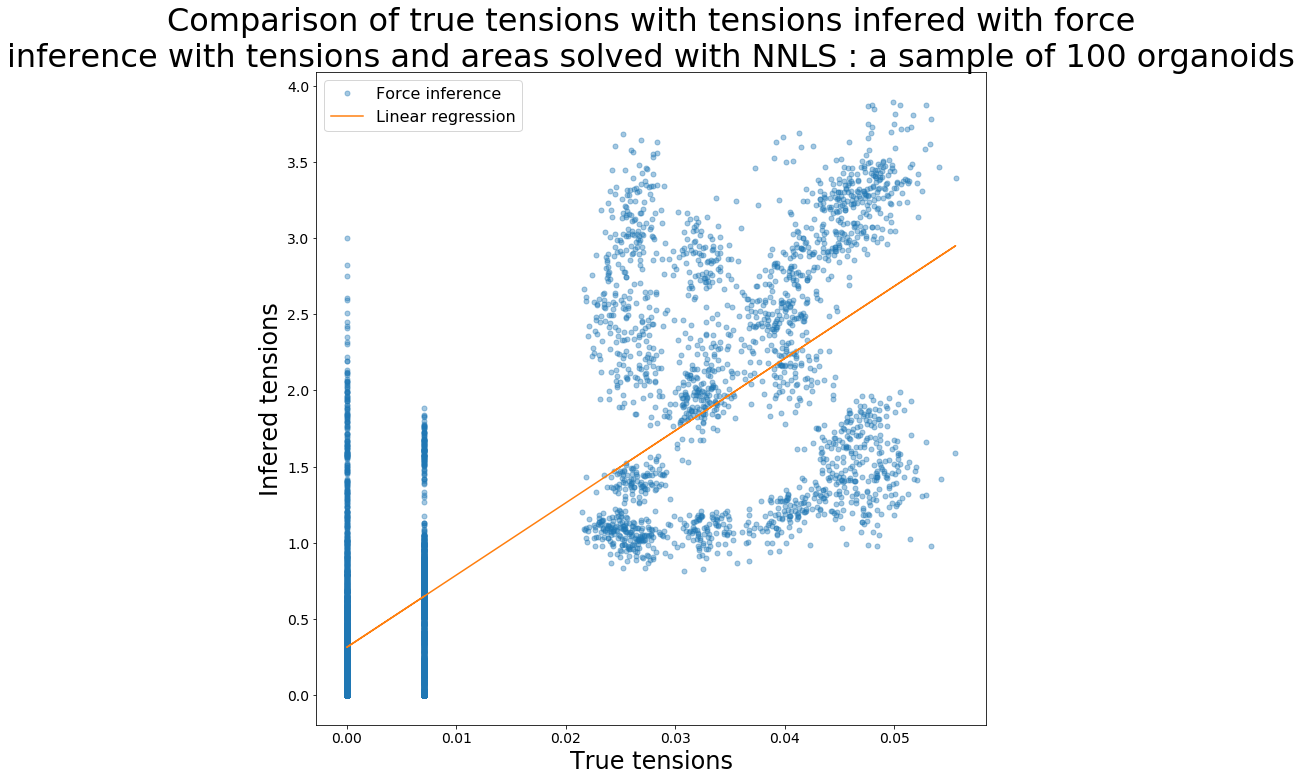

R value : 0.7806219965337148 
Standard error : 5.4161321541542025 
Distance : 44.58515060014739


In [34]:

rendering_results(true_tensions_a_nnls,
                  infered_tensions_a_nnls,
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference with tensions and areas solved with NNLS : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

(2000,) 2000


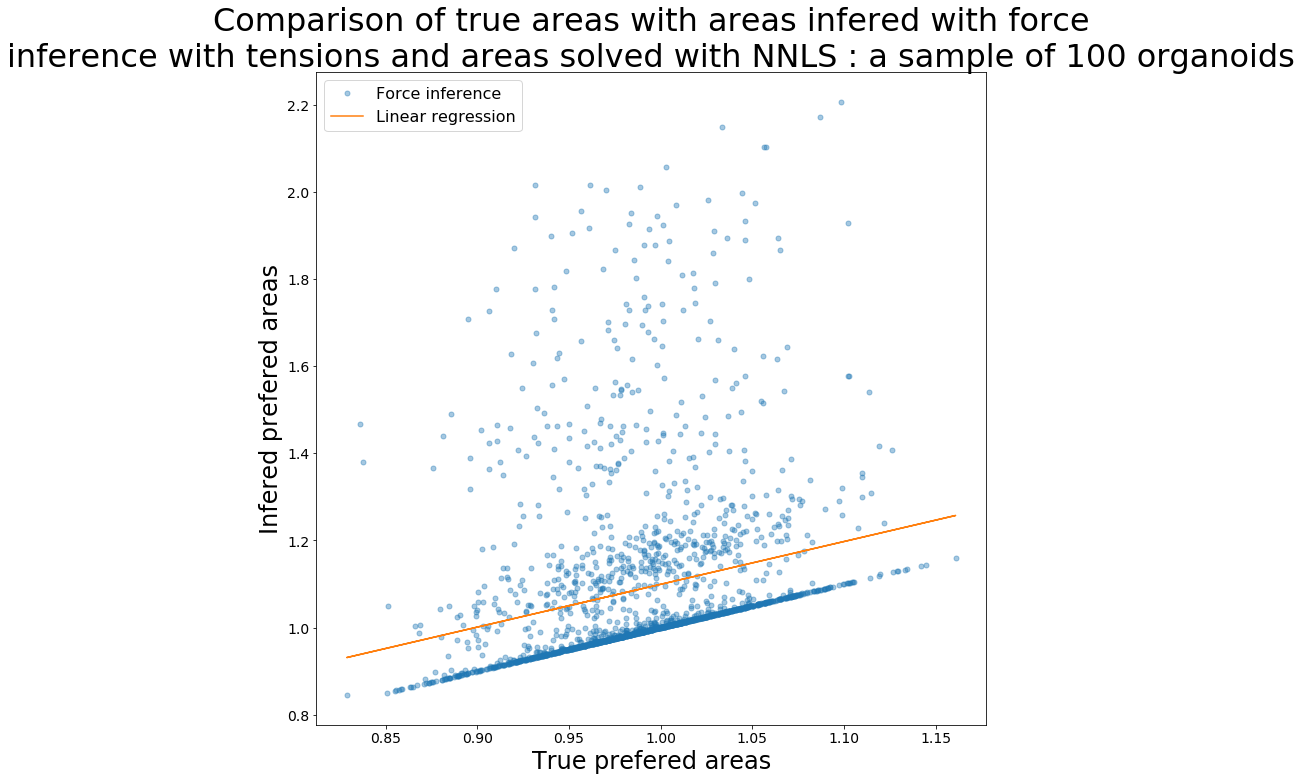

R value : 0.24042077644625112 
Standard error : 0.9943766640461357 
Distance : 44.58515060014739


In [42]:
print_infered_areas_a_nnls = np.concatenate([infered_areas_a_nnls[(organo.Nf+1)*i:(organo.Nf+1)*i+organo.Nf]
                                            for i in range(0, 100)])
print(print_infered_areas_a_nnls.shape, len(true_areas_a_nnls))
rendering_results(true_areas_a_nnls,
                  true_areas_a_nnls+print_infered_areas_a_nnls,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference with tensions and areas solved with NNLS : a sample of 100 organoids',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

In [43]:
print('Mean distance :', np.mean(errors_a_nnls),
      '\nMaximum distance :', np.max(errors_a_nnls))

Mean distance : 40.48576706191603 
Maximum distance : 63.22146905989988


# Rescaled force inference solved with NNLS for tensions and equilibrium areas 

[-1.09120786  1.41150279 -0.95131448 -0.54479915  2.18742536 -0.20296162
 -0.01326757  2.50110108  0.09538469  0.24404186  2.59334859  0.45881599
  0.6343183   2.52763622  0.90291391  1.11117099  2.40257922  0.93492625
  0.53112722  2.03955251  0.20879651  0.01359303  1.48494723 -0.11507634
 -0.24864397  0.77091591 -0.42420239 -0.63633285 -0.32088059 -0.90728253
  1.22832465 -1.45142607  1.08831196  0.82490779 -2.19073309  0.4901879
  0.25079057 -2.51368051 -0.13161452 -0.61691758 -2.60832612 -0.79590276
 -0.96093277 -2.54086657 -1.15485575 -1.22096929 -2.37817344 -1.12419327
 -0.79622796 -2.04357863 -0.4962358  -0.19386897 -1.52976865  0.16897333
  0.51028011 -0.77091293  0.800105    0.97461345  0.2847964   1.1552239 ]
[ -0.91641568   0.70846477  -1.0511771   -1.83553886   0.45715846
  -4.92704002 -75.3717696    0.3998239   10.48386311   4.09765776
   0.38560184   2.17952297   1.57649559   0.39562655   1.1075253
   0.8999515    0.41621937   1.06960308   1.88278808   0.49030363
   4.78

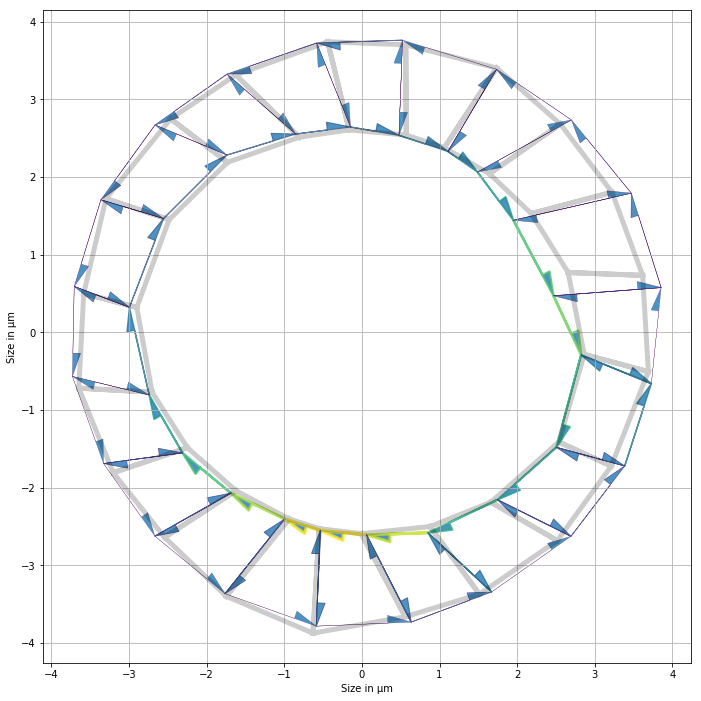

In [44]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
rescaled_areas_organo = organo.copy()
rescaled_areas_organo.face_df.loc[:, 'prefered_area'] = organo.face_df.area + initial_guess['areas'][:-1]
opt_scale = adjust_scale(rescaled_areas_organo,
                         initial_guess['tensions'],
                         **{'method':'Nelder-Mead'})
rescaled_areas_organo.edge_df.line_tension = prepare_tensions(rescaled_areas_organo,
                                                              opt_scale*initial_guess['tensions'])
Solver.find_energy_min(rescaled_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_areas_organo, organo)

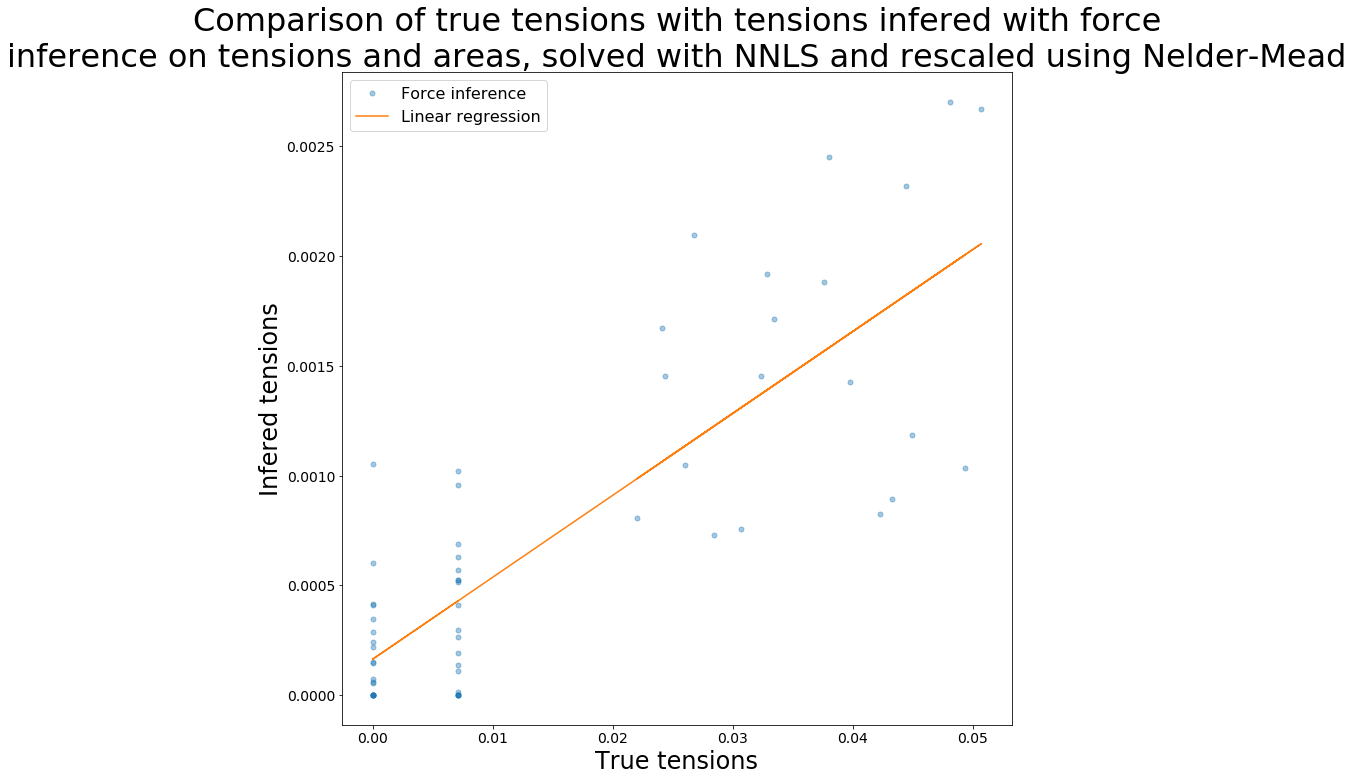

R value : 0.8194749057495148 
Standard error : 0.0003704221454269079 
Distance : 44.58515060014739


In [45]:
rendering_results(organo.edge_df.line_tension[:3*organo.Nf],
                  rescaled_areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference on tensions and areas, solved with NNLS and rescaled using Nelder-Mead',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

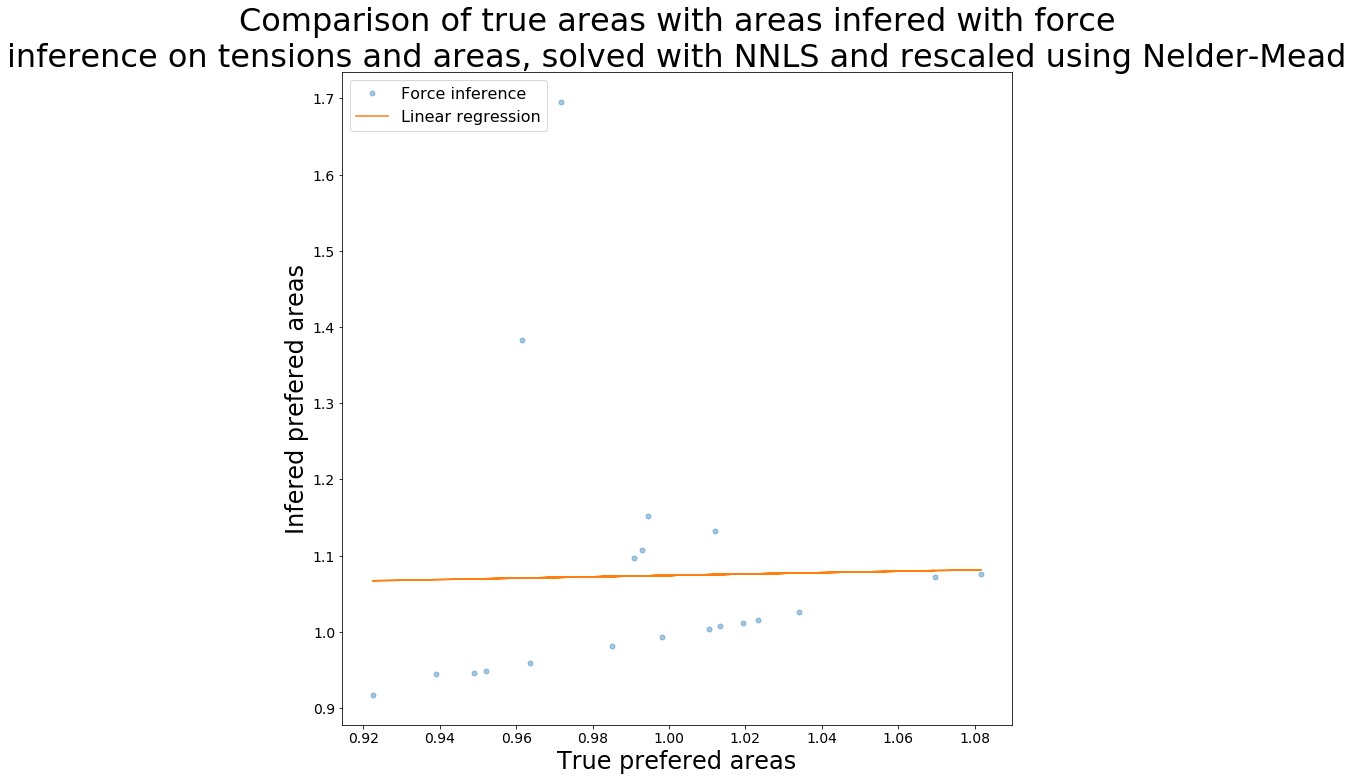

R value : 0.02073797975995378 
Standard error : 0.0875560886622406 
Distance : 44.58515060014739


In [46]:
rendering_results(organo.face_df.prefered_area,
                  rescaled_areas_organo.face_df.prefered_area,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference on tensions and areas, solved with NNLS and rescaled using Nelder-Mead',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

#### Repeating the same process on a large popuplation of organoids

In [49]:
true_tensions_ra_nnls = []
true_areas_ra_nnls = []
errors_ra_nnls  = []
infered_tensions_ra_nnls = []
infered_areas_ra_nnls = []
for i in range(100):
    seed = i
    eptm = create_organo(seed, 20, 110, 150)
    initial_guess = infer_forces(eptm, 'NNLS', sup_param='areas')
    start = time.clock()
    tmp_eptm = eptm.copy()
    tmp_eptm.face_df.loc[:, 'prefered_area'] = organo.face_df.area + initial_guess['areas'][:-1]
    opt_scale = adjust_scale(organo,
                             initial_guess['tensions'],
                             **{'method':'Nelder-Mead'})
    tmp_eptm.edge_df.line_tension = prepare_tensions(tmp_eptm,
                                                     opt_scale*initial_guess['tensions'])    
    Solver.find_energy_min(tmp_eptm, geom, model)
    errors_ra_nnls.append(np.sum(np.linalg.norm(_distance(tmp_eptm, eptm), axis=1)))
    true_tensions_ra_nnls += list(eptm.edge_df.line_tension[:3*organo.Nf])
    true_areas_ra_nnls += list(eptm.face_df.prefered_area)
    infered_tensions_ra_nnls += list(initial_guess['tensions'])
    infered_areas_ra_nnls += list(initial_guess['areas'])
    print(i)

Reseting datasets values with new specs


[-1.140994    1.45443945 -0.93176686 -0.52591539  2.18401728 -0.20496763
 -0.01072906  2.50627022  0.10783754  0.21383989  2.59395254  0.43667971
  0.63121041  2.52772834  0.88555704  1.12007044  2.37827745  0.95917722
  0.58847618  2.10004856  0.24135798  0.01030455  1.50491804 -0.13058177
 -0.24813757  0.83762773 -0.44353346 -0.63812546 -0.26619604 -0.91975977
  1.23930299 -1.40251315  1.0942749   0.78104848 -2.18455048  0.53918855
  0.17136161 -2.57946551 -0.144602   -0.53237375 -2.66726644 -0.80946379
 -0.96321001 -2.60007461 -1.13658255 -1.21379737 -2.4061029  -1.14131055
 -0.80209328 -2.10379947 -0.49381069 -0.17464441 -1.51903598  0.100633
  0.52066994 -0.82754855  0.81990825  0.97373579  0.32048357  1.17176487]
[ -0.8764288    0.68755011  -1.07322985  -1.90144656   0.45787183
  -4.8788192  -93.2048148    0.39899928   9.2732084    4.67639598
   0.38551207   2.29000796   1.58425777   0.39561213   1.12923274
   0.89280099   0.42047239   1.04256021   1.69930413   0.47617947
   4.14

Reseting datasets values with new specs


0
[-1.11017633  1.45736969 -0.86706306 -0.53123587  2.16311724 -0.22471165
 -0.0321466   2.51984143  0.11299283  0.25212499  2.61254054  0.35438296
  0.6816132   2.58413463  1.03731284  1.08076748  2.38655488  0.8718639
  0.53446909  2.07988466  0.23283205  0.02364251  1.67778896 -0.13115601
 -0.22914682  0.71665826 -0.35388253 -0.66991164 -0.39683672 -1.03257133
  1.25147886 -1.4448767   1.06126153  0.80722843 -2.14056451  0.52424563
  0.19443267 -2.51381488 -0.18168041 -0.49502177 -2.60622862 -0.78100228
 -1.01560381 -2.56109989 -1.17379194 -1.24450945 -2.34391659 -1.07088535
 -0.79060712 -2.10280626 -0.52337669 -0.20589927 -1.63615154  0.1582237
  0.49777541 -0.76298297  0.82856817  1.00072605  0.42899112  1.15843764]
[ -0.90075781   0.68616769  -1.15331865  -1.88240301   0.46229579
  -4.45014755 -31.10748866   0.39685037   8.85011902   3.96628676
   0.38276918   2.82180611   1.46710774   0.38697674   0.96402933
   0.9252684    0.41901404   1.14696801   1.8710156    0.48079589
   4.

Reseting datasets values with new specs


1
[-1.11054377  1.42431139 -0.89588604 -0.5583837   2.16519551 -0.23714643
 -0.00594155  2.54107879  0.11796641  0.24169023  2.63948837  0.42426002
  0.63473663  2.55296189  0.88779169  1.1165153   2.40355556  0.9835491
  0.54944595  2.06958144  0.23159392  0.0082804   1.55503551 -0.12808555
 -0.26874158  0.80010819 -0.42943919 -0.6070579  -0.22054787 -0.95460393
  1.2303804  -1.4329224   1.07455435  0.80243476 -2.18764607  0.5098615
  0.18808078 -2.5318143  -0.13109266 -0.5057915  -2.65083392 -0.79736496
 -0.99360553 -2.54837509 -1.13692631 -1.21434975 -2.39466281 -1.13309991
 -0.84586969 -2.01089193 -0.48171647 -0.15443489 -1.53578442  0.14639404
  0.46679536 -0.79677614  0.81989156  1.02636006  0.37342343  1.12949886]
[  -0.90045978    0.70209366   -1.1162134    -1.79088322    0.46185206
   -4.21680391 -168.30620781    0.39353365    8.4769896     4.13752767
    0.3788613     2.35704507    1.57545659    0.39170189    1.12639036
    0.8956438     0.4160503     1.01672606    1.82001524

Reseting datasets values with new specs


2
[-1.03668768  1.39027729 -0.97954559 -0.56384766  2.19964054 -0.2023714
 -0.01104863  2.51797262  0.10676785  0.2243037   2.60438334  0.41517468
  0.66294801  2.54006989  0.93393551  1.11485382  2.39084765  0.9471535
  0.53029458  2.09146249  0.21101365  0.01826695  1.56049829 -0.10981364
 -0.27494667  0.76556647 -0.43633487 -0.66413641 -0.30737273 -0.88597969
  1.19593734 -1.46414118  1.07808145  0.8687533  -2.20167973  0.5018167
  0.15851233 -2.52473033 -0.14728692 -0.50478683 -2.62370703 -0.80279047
 -0.99386766 -2.56126423 -1.1552213  -1.23349382 -2.40407975 -1.08978816
 -0.82944428 -2.01137089 -0.47866422 -0.18596658 -1.53141001  0.15937142
  0.52070646 -0.68309807  0.79417673  1.00364972  0.24054937  1.14030478]
[ -0.96461067   0.71928097  -1.02088153  -1.77352867   0.45461973
  -4.9414097  -90.50894162   0.39714491   9.36611555   4.45824122
   0.38396805   2.40862472   1.50841391   0.39368996   1.07073774
   0.89697858   0.4182617    1.05579507   1.88574435   0.47813432
   4.7

Reseting datasets values with new specs


3
[-1.04416913e+00  1.37758431e+00 -9.05517475e-01 -5.84434155e-01
  2.14585079e+00 -2.29349564e-01 -2.20081038e-03  2.54645262e+00
  1.49388307e-01  2.41836022e-01  2.60454992e+00  3.39543268e-01
  6.11920357e-01  2.55085424e+00  9.78446988e-01  1.16604354e+00
  2.30577330e+00  9.19121542e-01  5.38272973e-01  2.06718219e+00
  2.36137195e-01  9.66777718e-03  1.62668676e+00 -1.03570910e-01
 -2.47546063e-01  8.43341480e-01 -4.44258729e-01 -6.89390516e-01
 -3.30207213e-01 -9.39940623e-01  1.21433936e+00 -1.48874560e+00
  1.08011204e+00  8.22039247e-01 -2.16845030e+00  5.19381631e-01
  1.53479446e-01 -2.56529155e+00 -1.50193470e-01 -4.54835329e-01
 -2.64072469e+00 -8.08422724e-01 -9.97725839e-01 -2.58462710e+00
 -1.15506479e+00 -1.24276979e+00 -2.43358287e+00 -1.10234531e+00
 -7.79094424e-01 -2.08953498e+00 -5.06926679e-01 -2.27431422e-01
 -1.54506541e+00  1.43447971e-01  5.44465781e-01 -7.10753944e-01
  8.14545444e-01  9.67532971e-01  3.34815837e-01  1.16546589e+00]
[-9.57699261e-01  7.25

Reseting datasets values with new specs


4
[-1.09083089e+00  1.40502313e+00 -9.12635106e-01 -5.67005856e-01
  2.19200610e+00 -2.18951836e-01  1.69556108e-03  2.53903484e+00
  1.21759978e-01  2.08787959e-01  2.62990977e+00  4.02247505e-01
  6.60802310e-01  2.53564372e+00  9.41315453e-01  1.11722101e+00
  2.38638981e+00  9.21370380e-01  5.46041061e-01  2.11806780e+00
  2.26032630e-01  1.09594574e-02  1.58189480e+00 -9.50381950e-02
 -2.22145219e-01  7.96463182e-01 -4.09359248e-01 -6.65525394e-01
 -3.00736104e-01 -9.76741563e-01  1.24854508e+00 -1.43797883e+00
  1.08605001e+00  8.05762356e-01 -2.14347686e+00  4.88008432e-01
  1.71487129e-01 -2.53006095e+00 -1.04805166e-01 -5.26682661e-01
 -2.59554213e+00 -8.09961265e-01 -9.68016016e-01 -2.55197987e+00
 -1.16067854e+00 -1.23982905e+00 -2.40546574e+00 -1.11208059e+00
 -7.93513108e-01 -2.10768943e+00 -4.55350326e-01 -2.59100280e-01
 -1.58674724e+00  9.32576710e-02  5.91892757e-01 -7.76638642e-01
  8.00272677e-01  9.69453791e-01  3.66735886e-01  1.17528710e+00]
[-9.16732385e-01  7.11

Reseting datasets values with new specs


5
[-1.09156881  1.40727496 -0.94498308 -0.58080354  2.14076862 -0.25612987
 -0.02683726  2.56888205  0.12480813  0.25532902  2.65302836  0.39752951
  0.59027617  2.62255656  0.96722948  1.16195621  2.4034121   0.93333227
  0.60171464  2.11189852  0.22641304  0.00697661  1.60835308 -0.08954715
 -0.26294914  0.93134618 -0.48251285 -0.6540939  -0.32610588 -0.87613948
  1.23917592 -1.39256624  1.13276232  0.76185742 -2.19277041  0.55185686
  0.23346445 -2.59599553 -0.22172923 -0.50457625 -2.64559649 -0.76148568
 -1.00100176 -2.60994875 -1.15527475 -1.25199584 -2.46650219 -1.12978201
 -0.745505   -2.08405047 -0.56753528 -0.31692101 -1.5014765   0.25259422
  0.59387537 -0.77586266  0.7582586   0.99162671  0.25080245  1.14033496]
[ -0.91611265   0.71059319  -1.05822     -1.72175258   0.46712194
  -3.90426937 -37.26163202   0.38927439   8.01229879   3.91651524
   0.37692775   2.51553653   1.69412225   0.38130731   1.03388081
   0.86061763   0.41607513   1.0714298    1.66191735   0.4735076
   4

Reseting datasets values with new specs


6
[-1.16385515  1.47096198 -0.95900104 -0.53222533  2.21810932 -0.20480403
 -0.0172022   2.53541264  0.13173707  0.27097221  2.62771738  0.4373643
  0.63693319  2.56981704  0.92406504  1.06843765  2.36424324  0.90475939
  0.5966337   2.02787263  0.23176514 -0.00265712  1.48951463 -0.13876673
 -0.28108536  0.75400626 -0.35687263 -0.57595157 -0.35861545 -0.97024652
  1.26069454 -1.38286905  1.11154542  0.79971501 -2.16813423  0.52027258
  0.17533821 -2.57613644 -0.1904907  -0.4954045  -2.63166451 -0.77287534
 -1.02932093 -2.57082219 -1.16380562 -1.19183964 -2.35413105 -1.08617977
 -0.8012686  -2.00865146 -0.56738187 -0.16758119 -1.64038579  0.26907368
  0.43187259 -0.85674831  0.7557599   1.0177945   0.30010725  1.12408171]
[  -0.85921345    0.67982722   -1.04275174   -1.87890344    0.45083441
   -4.8827165   -58.1320867     0.39441312    7.59087781    3.69041538
    0.38055843    2.28642345    1.57002339    0.38913276    1.08217491
    0.93594605    0.42296832    1.10526623    1.6760702

Reseting datasets values with new specs


7
[-1.08908606  1.4593865  -0.95232133 -0.51994804  2.17304428 -0.21227839
 -0.03081384  2.49928258  0.11206918  0.23931424  2.59760105  0.46619117
  0.69757924  2.56091026  0.84532811  1.04291683  2.37346269  0.96580792
  0.58133709  2.08228178  0.23264424  0.01871212  1.44108036 -0.16719631
 -0.27005013  0.68712331 -0.40270632 -0.66996144 -0.24957586 -0.88753826
  1.20190966 -1.39871036  1.09945802  0.83803849 -2.1811917   0.48825371
  0.19942508 -2.56138453 -0.15600637 -0.57735397 -2.64648017 -0.79570583
 -0.95172866 -2.59880877 -1.16752881 -1.22087374 -2.31208755 -1.05302801
 -0.81460777 -2.0587085  -0.58370509 -0.14982004 -1.50667491  0.21691456
  0.4796262  -0.71878563  0.78829667  0.99538475  0.26840162  1.16305116]
[ -0.91820108   0.68521944  -1.05006574  -1.9232691    0.4601839
  -4.71079515 -32.45295233   0.40011482   8.9230597    4.17860634
   0.38497059   2.14504279   1.43352891   0.39048615   1.18297261
   0.95884923   0.42132535   1.03540257   1.72017238   0.4802424
   4.

Reseting datasets values with new specs


8
[-1.1216523   1.41122417 -0.87088675 -0.56532631  2.10736593 -0.25315241
 -0.01557884  2.54187679  0.08017713  0.22641274  2.61367074  0.44358825
  0.70327294  2.57303446  0.93878122  1.09667148  2.45331648  0.94005861
  0.52334307  2.12020897  0.21170354  0.01649472  1.56613998 -0.13327131
 -0.25161371  0.71366309 -0.41185684 -0.6120238  -0.31142246 -0.94514144
  1.20591806 -1.47967987  1.12332561  0.76165717 -2.19153968  0.43717249
  0.31854564 -2.526366   -0.06448605 -0.63315482 -2.61494676 -0.80076886
 -0.97003768 -2.55935544 -1.1984086  -1.22653052 -2.34840414 -1.10476811
 -0.81398311 -2.05612802 -0.47152339 -0.18356218 -1.52469046  0.12819614
  0.55106374 -0.83208043  0.7756041   0.99008371  0.36559243  1.17565669]
[ -0.89154188   0.70860464  -1.14825493  -1.7688899    0.47452604
  -3.95018955 -64.18964832   0.3934101   12.47238386   4.4167125
   0.38260366   2.25434287   1.42192304   0.38864617   1.06521091
   0.9118501    0.4076115    1.06376346   1.91079249   0.47165162
   4

Reseting datasets values with new specs


9
[-1.07791521  1.45943211 -0.9120423  -0.51680728  2.15127041 -0.22323854
 -0.0320633   2.49304667  0.09523635  0.25489261  2.59774749  0.4394207
  0.62973234  2.55717327  0.92577725  1.14010294  2.4072748   0.92813715
  0.51900175  2.04738805  0.22289995  0.0249777   1.52843339 -0.12670528
 -0.27887484  0.78792337 -0.38613986 -0.66304671 -0.3231211  -0.96334542
  1.23094687 -1.49228252  1.09748687  0.77914563 -2.1793954   0.49947985
  0.25724674 -2.53028601 -0.19654912 -0.5590222  -2.62519531 -0.73964409
 -1.00076002 -2.5802414  -1.1657773  -1.24644856 -2.37178475 -1.10068545
 -0.79067384 -2.02249172 -0.53033052 -0.15507103 -1.59950503  0.20361842
  0.47781824 -0.69639831  0.78408729  1.00681818  0.32718582  1.14831406]
[ -0.92771675   0.68519802  -1.09644038  -1.93495728   0.46484161
  -4.47951322 -31.18830529   0.40111564  10.50019265   3.92322084
   0.38494888   2.27572346   1.58797625   0.3910568    1.08017345
   0.87711378   0.4154075    1.07742697   1.92677579   0.48842719
   4

Reseting datasets values with new specs


10
[-1.17139048  1.43459917 -0.94148924 -0.54038374  2.20822706 -0.21239836
 -0.02616214  2.51536665  0.0943973   0.25066202  2.63302379  0.45201502
  0.67428674  2.56769092  0.96862624  1.05115002  2.44422919  0.87653591
  0.56677947  2.06636689  0.22356001  0.01903921  1.54019916 -0.10578855
 -0.26462254  0.7177934  -0.36852655 -0.55935858 -0.39705333 -0.98693177
  1.26425613 -1.38450664  1.13473978  0.7968375  -2.15012514  0.47049989
  0.22756914 -2.51806559 -0.13493786 -0.57145429 -2.59724516 -0.81475837
 -0.98025323 -2.55614401 -1.15704071 -1.23549746 -2.38566806 -1.08518609
 -0.75448876 -2.02689894 -0.52587115 -0.26432415 -1.64861497  0.2137481
  0.51539136 -0.90818178  0.75463541  1.00196377  0.32524857  1.14417101]
[ -0.8536863    0.69705882  -1.06214703  -1.8505368    0.45285198
  -4.70813418 -38.22317965   0.39755636  10.59352367   3.98943569
   0.37979148   2.21231588   1.48304859   0.38945497   1.03238995
   0.95133899   0.40912694   1.14085458   1.76435465   0.48394117
   

Reseting datasets values with new specs


11
[-1.05053096  1.374796   -0.88182024 -0.57109899  2.18380584 -0.21876503
 -0.00681208  2.51699399  0.121972    0.1959994   2.6213359   0.41449481
  0.75325864  2.53061815  0.91678811  1.0217938   2.37739189  0.94458179
  0.53608289  2.13861935  0.22374398  0.04703109  1.54840227 -0.11205833
 -0.25433075  0.63210207 -0.40096828 -0.67139303 -0.28517396 -1.00796882
  1.23769499 -1.41148552  1.06876237  0.80809305 -2.17433754  0.50523247
  0.18181946 -2.48365129 -0.0803739  -0.54888775 -2.6218255  -0.86031904
 -0.96662368 -2.57771347 -1.15511971 -1.2172529  -2.39770883 -1.08167
 -0.84125189 -2.06905198 -0.49946493 -0.1711907  -1.59577228  0.13854391
  0.51507141 -0.72626592  0.80432576  1.00252801  0.42016535  1.16008307]
[  -0.9518996     0.72738064   -1.13401797   -1.75100992    0.45791617
   -4.57111452 -146.7980077     0.39729932    8.19860292    5.1020564
    0.38148488    2.41257543    1.32756526    0.39516037    1.09076458
    0.97867104    0.42062901    1.05866957    1.86538317 

Reseting datasets values with new specs


12
[-1.108132    1.38432386 -0.98357704 -0.58772522  2.23840686 -0.2107763
  0.00347333  2.55977429  0.16117104  0.25320067  2.65995946  0.38880089
  0.62258794  2.55282764  0.920988    1.12252526  2.33761739  0.93009072
  0.53850672  2.04642629  0.23753595  0.03762333  1.5600156  -0.10476264
 -0.30702561  0.80125042 -0.47012096 -0.57503442 -0.2819604  -0.86934965
  1.19905915 -1.4438001   1.11452327  0.85914959 -2.14214184  0.48783544
  0.10121077 -2.52081354 -0.10224498 -0.4696682  -2.61721374 -0.81778577
 -0.9893404  -2.59606019 -1.15877103 -1.2227387  -2.40768845 -1.11713656
 -0.79442982 -1.98200898 -0.55848121 -0.18887508 -1.46744652  0.25830666
  0.50692689 -0.83194015  0.73121082  0.99870579  0.27125278  1.16254337]
[ -0.90241957   0.72237432  -1.01669718  -1.70147541   0.44674631
  -4.7443664  287.90834467   0.39065944   6.20458875   3.94943657
   0.37594558   2.57201055   1.60619881   0.39172249   1.08579048
   0.89084855   0.427786     1.07516394   1.85698704   0.48865674
   

Reseting datasets values with new specs


13
[-1.14461348  1.48228628 -0.95420524 -0.5144415   2.1851692  -0.22446243
 -0.01951665  2.51116928  0.11550736  0.19869625  2.63409407  0.40452834
  0.74623794  2.55020258  0.99731911  1.02205363  2.40307934  0.86766677
  0.56248537  2.15281008  0.23625324  0.02363634  1.59402266 -0.10272606
 -0.23849783  0.6603342  -0.45292897 -0.63604006 -0.40061556 -0.88695212
  1.2276461  -1.38377305  1.11407778  0.80577756 -2.1359491   0.45616796
  0.18073777 -2.50874379 -0.07075757 -0.53459556 -2.60845558 -0.83651762
 -0.98450365 -2.55601648 -1.16641245 -1.21026847 -2.40300347 -1.08494031
 -0.79152121 -2.07902081 -0.49128183 -0.23430494 -1.49714552  0.14410656
  0.5771475  -0.80694068  0.77112231  0.96388491  0.27675872  1.16443517]
[ -0.87365737   0.67463351  -1.04799256  -1.94385562   0.45763047
  -4.45508852 -51.23830281   0.39822086   8.65745671   5.03280762
   0.37963716   2.4720147    1.34005516   0.39212571   1.00268809
   0.97842224   0.41613274   1.15251619   1.77782402   0.46450916
  

Reseting datasets values with new specs


14
[-1.04213418  1.35117232 -0.95399647 -0.60454074  2.1906785  -0.23414407
  0.0066174   2.56025381  0.15847217  0.22305428  2.65896664  0.39088553
  0.69305654  2.54701901  0.93462907  1.01759458  2.34202231  0.9571059
  0.60846638  2.10091044  0.20580835  0.03184454  1.56025124 -0.11731508
 -0.26252639  0.71479735 -0.40340748 -0.67143242 -0.3090069  -0.93803792
  1.21697134 -1.32039182  1.06900889  0.88336873 -2.2232187   0.44830294
  0.13463808 -2.53732458 -0.05456905 -0.50721568 -2.63483541 -0.85414881
 -0.974614   -2.60101366 -1.13323033 -1.23387885 -2.40020525 -1.06737332
 -0.80476564 -2.07596088 -0.59165314 -0.14959717 -1.59339029  0.26481612
  0.4563244  -0.73309603  0.75779471  0.97876879  0.28268556  1.161052  ]
[ -0.95956933   0.74009805  -1.04822191  -1.65414824   0.45647958
  -4.27087471 151.11674898   0.39058628   6.31025637   4.48321364
   0.37608595   2.5582937    1.44288371   0.39261584   1.06994318
   0.98270963   0.42698141   1.04481646   1.64347617   0.47598412
   

Reseting datasets values with new specs


15
[-1.11158543  1.46253139 -0.9842976  -0.53739579  2.23480354 -0.19524117
 -0.01586661  2.53732297  0.09690327  0.24587622  2.62528589  0.40998024
  0.67059034  2.56905618  0.97341697  1.06752596  2.43147935  0.93286674
  0.56537651  2.07730375  0.20796772  0.02289354  1.61151888 -0.131664
 -0.27238026  0.73612306 -0.39774388 -0.63503449 -0.33531505 -0.91218828
  1.2381052  -1.39892886  1.1058797   0.80772963 -2.20104853  0.47152198
  0.24119625 -2.52968187 -0.19109731 -0.51854904 -2.61698398 -0.75764378
 -1.01158545 -2.57546896 -1.16266337 -1.22441778 -2.35365598 -1.07493989
 -0.837975   -2.03070844 -0.52425169 -0.19321688 -1.55816821  0.19081543
  0.50950989 -0.76063946  0.79867231  0.98920319  0.26620834  1.14370662]
[ -0.89961597   0.68374601  -1.0159529   -1.8608259    0.44746663
  -5.12187046 -63.0254439    0.39411617  10.31956928   4.06708715
   0.3809109    2.43914197   1.49122338   0.38924801   1.02730899
   0.93674537   0.41127226   1.07196447   1.76873285   0.48139325
   4

Reseting datasets values with new specs


16
[-1.04939405  1.41008983 -0.93433132 -0.56514263  2.15462448 -0.24823361
 -0.0224984   2.54037508  0.15798841  0.20950337  2.65109169  0.32571257
  0.72559921  2.58537188  1.01226725  1.08640452  2.33511487  0.91748284
  0.52778936  2.16636514  0.21598258  0.03039953  1.68368972 -0.10140568
 -0.25437399  0.71516673 -0.47276399 -0.68828692 -0.34084478 -0.87269906
  1.19138581 -1.45764231  1.11274426  0.81562025 -2.17581046  0.48377426
  0.15118875 -2.51322102 -0.07278065 -0.4636432  -2.60777562 -0.8703717
 -0.98550786 -2.57402009 -1.15525336 -1.26727256 -2.40496426 -1.07759944
 -0.78964659 -2.06527212 -0.5580775  -0.18568132 -1.45943628  0.21059736
  0.52716308 -0.68869827  0.77308614  1.00639363  0.28596183  1.15388063]
[ -0.95293089   0.70917468  -1.07028414  -1.76946483   0.464118
  -4.02846339 -44.44760602   0.39364266   6.32957808   4.77319296
   0.3772031    3.07019157   1.3781713    0.38679155   0.98788141
   0.92046745   0.42824446   1.08993864   1.89469527   0.4616027
   4.6

Reseting datasets values with new specs


17
[-1.09253881  1.39911515 -0.86011782 -0.57113399  2.15656501 -0.24066425
 -0.01578271  2.54138313  0.1254263   0.2281805   2.63789352  0.39202282
  0.69734858  2.57294854  0.94807758  1.0603853   2.38704093  0.94725255
  0.56546474  2.11658754  0.20370657  0.01096121  1.60299529 -0.09766866
 -0.24701865  0.72189038 -0.40641286 -0.63586617 -0.29315987 -1.01162223
  1.25004744 -1.39888022  1.07297813  0.77658117 -2.18766498  0.50753674
  0.19523538 -2.52980969 -0.10076638 -0.51582245 -2.59507813 -0.82552524
 -0.9754857  -2.55173212 -1.17591246 -1.2197727  -2.3997408  -1.10253565
 -0.79316587 -2.05769481 -0.51340896 -0.28159057 -1.58691509  0.20583613
  0.56783606 -0.78596246  0.77340632  0.99613724  0.43632938  1.15839138]
[ -0.9152993    0.71473745  -1.16263142  -1.75090262   0.46370037
  -4.1551663  -63.36048781   0.39348652   7.97280979   4.38249542
   0.37909036   2.55087192   1.43400307   0.38865915   1.054766
   0.94305343   0.41892872   1.05568467   1.76845688   0.47245861
   4

Reseting datasets values with new specs


18
[-1.112853    1.46497908 -0.89446588 -0.53647882  2.15403466 -0.22913763
 -0.02956861  2.53793671  0.07620084  0.30893633  2.61230992  0.45160851
  0.665115    2.59707393  0.93906556  1.03456009  2.45990823  0.91046296
  0.54959927  1.97920127  0.23961093  0.02607412  1.55669122 -0.14591412
 -0.24847585  0.64897127 -0.369931   -0.65690853 -0.3214399  -0.97750017
  1.23040873 -1.42014891  1.1088312   0.76657864 -2.14236582  0.4615364
  0.35478823 -2.51934745 -0.23701269 -0.59945777 -2.62158767 -0.70889238
 -1.04403202 -2.57149569 -1.16009175 -1.2045152  -2.32975944 -1.06813803
 -0.83046317 -2.07454398 -0.55997329 -0.08740623 -1.58989744  0.1622159
  0.41642364 -0.76072693  0.83565927  0.99767516  0.36510289  1.16586537]
[ -0.89859127   0.6826036   -1.11798563  -1.8640065    0.46424508
  -4.36418932 -33.8196523    0.39402086  13.12321468   3.23691297
   0.38280297   2.21430727   1.50349939   0.38504872   1.06488838
   0.96659441   0.40651923   1.09834232   1.8195075    0.50525432
   4

Reseting datasets values with new specs


19
[-1.13001546  1.42788786 -0.98304655 -0.55652762  2.19842308 -0.21635546
 -0.01117308  2.54094309  0.11579062  0.26162847  2.631134    0.37268345
  0.59497215  2.56328925  1.03136294  1.17002128  2.39955275  0.87561001
  0.53184923  2.0400323   0.22927556  0.00294185  1.65418586 -0.10882617
 -0.23802472  0.850088   -0.41449883 -0.62567212 -0.40854002 -0.90199558
  1.25376268 -1.48995456  1.10209098  0.80993578 -2.15976005  0.55766021
  0.21961367 -2.55365302 -0.21254854 -0.47630356 -2.61831117 -0.79439895
 -1.04971278 -2.55953672 -1.13682141 -1.26730638 -2.40065884 -1.1174825
 -0.75150589 -2.08348729 -0.50044985 -0.23849788 -1.57166119  0.15583732
  0.53873327 -0.83214306  0.80618246  0.96128109  0.23232997  1.13993028]
[ -0.88494365   0.70033511  -1.01724582  -1.79685603   0.4548715
  -4.6220234  -89.50082308   0.39355466   8.63627808   3.82221394
   0.38006426   2.68324234   1.68075094   0.39012374   0.96959078
   0.85468531   0.41674433   1.14206095   1.88023211   0.49018832
   4

Reseting datasets values with new specs


20
[-1.09410747  1.46127779 -0.92427163 -0.53247807  2.19223126 -0.20448792
 -0.01794118  2.52623392  0.09613925  0.2391688   2.6012071   0.43022925
  0.67981733  2.56211628  0.88052578  1.10153468  2.40892859  1.00517766
  0.52149988  2.08377867  0.19089233  0.01083043  1.54847009 -0.12664073
 -0.19879029  0.724144   -0.32668166 -0.70953412 -0.21258148 -1.02088233
  1.26848473 -1.47892536  1.09939426  0.78595412 -2.22293679  0.53060228
  0.19957175 -2.52192512 -0.18801635 -0.50922352 -2.60472144 -0.82754033
 -0.97048029 -2.54358598 -1.14866165 -1.23816592 -2.35143997 -1.10523537
 -0.81452607 -2.1460054  -0.50877356 -0.21827215 -1.69807665  0.15271616
  0.50914155 -0.72693716  0.84583256  0.98751581  0.343688    1.149682  ]
[ -0.91398699   0.68433258  -1.08193303  -1.87801162   0.45615625
  -4.89026449 -55.73770074   0.39584616  10.40157847   4.1811473
   0.3844369    2.3243422    1.47098338   0.39030235   1.13568509
   0.90782434   0.41512231   0.99484901   1.91754599   0.47989742
   

Reseting datasets values with new specs


21
[-1.08842049e+00  1.42317897e+00 -9.76818919e-01 -5.49995157e-01
  2.20728904e+00 -2.00763027e-01 -2.53165787e-02  2.52316929e+00
  8.67914469e-02  2.47983458e-01  2.60881510e+00  4.40805773e-01
  6.30839740e-01  2.57380245e+00  9.38065620e-01  1.13473522e+00
  2.43523220e+00  9.41949819e-01  5.38333710e-01  2.07783553e+00
  2.10613861e-01  2.60778634e-03  1.55362066e+00 -1.12357022e-01
 -2.13852963e-01  8.16156050e-01 -4.35462208e-01 -6.76914732e-01
 -3.22510582e-01 -8.92825344e-01  1.20459606e+00 -1.45331440e+00
  1.11542332e+00  7.92885913e-01 -2.20641022e+00  5.12396880e-01
  2.69143187e-01 -2.52998182e+00 -1.97517831e-01 -5.75166743e-01
 -2.62763794e+00 -7.53055317e-01 -9.72052100e-01 -2.53519739e+00
 -1.16923331e+00 -1.24599222e+00 -2.40292390e+00 -1.09991689e+00
 -7.94083279e-01 -2.10749146e+00 -4.86992489e-01 -1.85236475e-01
 -1.53199948e+00  1.18588815e-01  5.39220832e-01 -7.53662000e-01
  7.93577837e-01  9.66684829e-01  2.53651205e-01  1.16672899e+00]
[-9.18762567e-01  7.0

Reseting datasets values with new specs


22
[-1.13656495  1.50304014 -0.89640689 -0.49578652  2.15713916 -0.22327174
 -0.01784222  2.49461319  0.14080678  0.26374876  2.60368263  0.38558469
  0.59210878  2.53029763  0.87724009  1.09920165  2.32206907  0.98032869
  0.58472251  2.0028001   0.23451273  0.0079253   1.5508997  -0.11716733
 -0.24697557  0.81858254 -0.39297177 -0.65053773 -0.20358047 -0.98865524
  1.24700406 -1.37982077  1.08526158  0.80755763 -2.16423785  0.48654143
  0.16148268 -2.54926578 -0.14732525 -0.47143856 -2.63326331 -0.80235863
 -1.0011143  -2.56511637 -1.11266355 -1.22523896 -2.39892865 -1.13166054
 -0.85281122 -2.07116524 -0.43622061 -0.21231204 -1.61298511  0.08849182
  0.56886707 -0.77008977  0.79875954  0.97800364  0.36432537  1.17117421]
[ -0.87984413   0.66531823  -1.11556483  -2.01699714   0.46357695
  -4.47884721 -56.04683312   0.40086375   7.10193074   3.79148697
   0.38407139   2.593464     1.68887886   0.39521042   1.13993879
   0.90975118   0.43065041   1.02006603   1.71021295   0.49930095
  

Reseting datasets values with new specs


23
[-1.11813033  1.44651811 -0.8505131  -0.53767827  2.15719943 -0.23288655
 -0.01432212  2.52187464  0.12774017  0.22126362  2.62297252  0.41469102
  0.65578844  2.55051889  0.93633711  1.09464894  2.36749218  0.94037556
  0.56990016  2.10799166  0.21821647  0.01197619  1.53811014 -0.12197461
 -0.20711022  0.79641478 -0.36628285 -0.6763364  -0.33456408 -1.06570323
  1.26557044 -1.3928831   1.0712963   0.80548633 -2.2153152   0.48125136
  0.16835104 -2.53268342 -0.13404628 -0.49240221 -2.65174813 -0.79027648
 -1.00757009 -2.5566358  -1.16355685 -1.20998686 -2.40779892 -1.07062275
 -0.85377923 -2.14241535 -0.50799463 -0.14435141 -1.67523323  0.10225092
  0.47775503 -0.78974256  0.8491683   0.99092695  0.45617323  1.16253012]
[ -0.89435012   0.69131523  -1.17576085  -1.85984828   0.463564
  -4.29393634 -69.82204323   0.39653042   7.82839124   4.51949582
   0.38124685   2.41143393   1.52488202   0.39207708   1.06799142
   0.91353489   0.42238788   1.06340493   1.75469331   0.47438518
   4

Reseting datasets values with new specs


24
[-1.02404613  1.37649496 -0.90239358 -0.57489452  2.1349021  -0.24840616
 -0.01099558  2.52628399  0.10463909  0.23306541  2.63171442  0.41326169
  0.69521342  2.54827514  1.02109869  1.05271651  2.42243624  0.85129006
  0.55401172  2.08214432  0.23385833  0.02098688  1.59591285 -0.14220604
 -0.22497327  0.69171747 -0.39443865 -0.72108445 -0.44628452 -0.93670342
  1.19368167 -1.41371554  1.09008601  0.83588516 -2.14886463  0.46005884
  0.21766258 -2.52173898 -0.10782873 -0.51643648 -2.61658129 -0.83148737
 -1.02470547 -2.56371275 -1.14952323 -1.23314438 -2.33216921 -1.05673255
 -0.79418437 -2.11376622 -0.53406576 -0.15213888 -1.54329191  0.14948358
  0.46428388 -0.67159731  0.81758153  1.00909628  0.33011493  1.16242769]
[ -0.9765185    0.72648287  -1.10816391  -1.73944954   0.46840555
  -4.02566502 -90.94565258   0.39583832   9.55665771   4.29064094
   0.37998044   2.41977425   1.43840721   0.3924223    0.97933727
   0.94992336   0.41280756   1.17468775   1.80501596   0.48027411
  

Reseting datasets values with new specs


25
[-1.0877883   1.43154189 -0.89293029 -0.52873121  2.16322822 -0.21218959
 -0.0166695   2.4890043   0.09694209  0.24236328  2.58760741  0.46252375
  0.66905496  2.5223433   0.85153343  1.02070618  2.39372324  0.97350599
  0.61271306  2.03761674  0.23925806  0.01568032  1.46867575 -0.13430398
 -0.2621161   0.69950682 -0.45205986 -0.66521268 -0.23439111 -0.93227959
  1.21886529 -1.34190553  1.07769007  0.80435204 -2.1814031   0.4825306
  0.20756725 -2.56733164 -0.13365541 -0.56988438 -2.65991921 -0.77967111
 -0.99204693 -2.59869228 -1.14133721 -1.17215084 -2.39131126 -1.11607372
 -0.83731994 -2.07446008 -0.52144916 -0.19779394 -1.48719153  0.15634627
  0.52506215 -0.74403472  0.79560297  1.0133493   0.37736765  1.1800167 ]
[ -0.91929652   0.6985475   -1.11990826  -1.89132017   0.46227207
  -4.71276646 -59.98979916   0.40176708  10.31543718   4.12603753
   0.38645739   2.16205116   1.49464552   0.39645674   1.17435201
   0.97971387   0.41775924   1.02721504   1.63208535   0.49076943
   

Reseting datasets values with new specs


26
[-1.03367987  1.41134747 -0.94847211 -0.57544738  2.17431    -0.24499869
 -0.01108568  2.56224223  0.12879639  0.2666366   2.66430739  0.40844624
  0.64606853  2.58441358  0.93883239  1.09050138  2.40671462  0.93325519
  0.55326802  2.05114038  0.22703234  0.00874559  1.58982214 -0.14917358
 -0.20016164  0.75900331 -0.35872727 -0.74484556 -0.28784265 -0.93499089
  1.23427774 -1.42199945  1.08225553  0.81025292 -2.15435302  0.50223879
  0.2185851  -2.5285355  -0.16846461 -0.50996157 -2.6084177  -0.78758149
 -1.00896961 -2.54602668 -1.13568067 -1.23861982 -2.31007053 -1.11177093
 -0.79692317 -2.1457034  -0.48897958 -0.20164533 -1.59261599  0.10067031
  0.52313836 -0.65601227  0.85989706  0.96986539  0.27736578  1.14741559]
[ -0.9674175    0.70854274  -1.05432726  -1.73777835   0.45991602
  -4.08165441 -90.20648944   0.39028316   7.76419286   3.75042283
   0.37533207   2.44830263   1.54782341   0.38693497   1.06515285
   0.91700939   0.41550419   1.07151829   1.80744225   0.48753367
  

Reseting datasets values with new specs


27
[-1.02342322  1.3377764  -0.89360014 -0.58759067  2.18947462 -0.21545073
 -0.0209921   2.51295774  0.10495077  0.23949114  2.62037609  0.41965961
  0.61810353  2.55494193  0.97581262  1.11750784  2.41047455  0.89163618
  0.57818639  2.07595964  0.23347395  0.01355837  1.57115533 -0.1042208
 -0.24023309  0.83975258 -0.35522624 -0.69460819 -0.38046991 -1.05703523
  1.22676763 -1.3952631   1.06582155  0.81936343 -2.16374228  0.51551619
  0.19395193 -2.55163588 -0.15236848 -0.51766185 -2.63069018 -0.78520581
 -0.99340248 -2.57875262 -1.16209153 -1.22658484 -2.42224858 -1.10336285
 -0.77282387 -2.09828644 -0.50678645 -0.26349556 -1.71179611  0.19470367
  0.52150115 -0.70907005  0.78815153  1.01238447  0.40227435  1.14562217]
[ -0.97711287   0.74750908  -1.11906876  -1.701865     0.45673057
  -4.64143231 -47.63697694   0.39793745   9.52827722   4.17551973
   0.38162461   2.38288357   1.61785195   0.39139833   1.02478691
   0.89484831   0.41485607   1.12153367   1.72954607   0.48170493
   

Reseting datasets values with new specs


28
[-1.14496845  1.49187704 -0.98446803 -0.51872573  2.2163833  -0.19868462
 -0.00450969  2.52932849  0.13237528  0.21252326  2.61375254  0.39381007
  0.67899588  2.53834787  0.91830246  1.0837172   2.34900199  0.95804624
  0.55750149  2.11330134  0.21925999  0.02241177  1.56138186 -0.11081914
 -0.21639958  0.75530958 -0.42986735 -0.67054616 -0.27522307 -0.89795489
  1.23275653 -1.41212483  1.11737936  0.80490457 -2.19131555  0.48708139
  0.15167136 -2.52712781 -0.12465303 -0.48505016 -2.62983552 -0.81980421
 -0.98191838 -2.57195135 -1.1476651  -1.23902579 -2.40819724 -1.09365808
 -0.79022349 -2.13915219 -0.51338388 -0.21142892 -1.54846254  0.13409794
  0.57692693 -0.79805987  0.77174912  0.94138735  0.24744725  1.1888565 ]
[  -0.87338651    0.67029653   -1.01577702   -1.92780105    0.4511855
   -5.03310222 -221.74478536    0.39536185    7.55428075    4.70536728
    0.38259169    2.53929517    1.47276299    0.39395704    1.08896582
    0.92274995    0.42571271    1.04379096    1.793717

Reseting datasets values with new specs


29
[-1.17485078  1.51214225 -0.9280767  -0.49565365  2.17449078 -0.22801372
 -0.0423867   2.50344956  0.11420372  0.25219456  2.63051823  0.50128216
  0.71516925  2.58822296  0.83690552  1.00856655  2.40211079  0.94036766
  0.57351863  2.08383383  0.23169678  0.00608244  1.39954647 -0.10988912
 -0.22494849  0.65349532 -0.4043649  -0.61769182 -0.27426458 -0.95411141
  1.23415561 -1.36363779  1.12652111  0.78483894 -2.15499989  0.50506317
  0.21844987 -2.51067504 -0.16072209 -0.5489548  -2.61839346 -0.83087929
 -0.98510858 -2.52283993 -1.13832752 -1.18673314 -2.39861522 -1.07842908
 -0.85065734 -2.07294294 -0.4579345  -0.20238613 -1.58988542  0.07749368
  0.54659154 -0.83755931  0.79667057  0.98980403  0.31833739  1.16054396]
[ -0.85117192   0.66131344  -1.07749716  -2.01753784   0.45987778
  -4.38570093 -23.59230622   0.39944883   8.75628234   3.96519252
   0.38015323   1.99488447   1.3982704    0.38636548   1.194878
   0.99150621   0.41630053   1.06341386   1.74362253   0.47988471
   4

Reseting datasets values with new specs


30
[-1.17323373  1.49322917 -0.9958629  -0.50328114  2.21507598 -0.18814625
 -0.01049002  2.49979146  0.12909079  0.2290958   2.59136849  0.42045922
  0.63523241  2.5207715   0.87624739  1.11070541  2.33318692  0.97390044
  0.55188298  2.06257991  0.21157202  0.00384086  1.49226849 -0.12343963
 -0.23961608  0.79211509 -0.4269563  -0.60413647 -0.2602263  -0.87686478
  1.23407948 -1.42929572  1.12497904  0.84092442 -2.20802718  0.49978478
  0.16315156 -2.53306168 -0.13968672 -0.52353497 -2.63117122 -0.82531907
 -0.97214979 -2.54074341 -1.13945175 -1.21251416 -2.38429197 -1.12999439
 -0.84667187 -2.06151124 -0.45362598 -0.17056186 -1.53037937  0.09429024
  0.52585956 -0.85323829  0.81438508  0.96141764  0.22335019  1.15463877]
[ -0.85234508   0.66968957  -1.00415429  -1.986961     0.45145178
  -5.31501414 -95.3286747    0.40003337   7.74648631   4.3649862
   0.38589649   2.37835195   1.57422699   0.39670395   1.14123021
   0.90032874   0.42859832   1.026799     1.81197834   0.4848297
   4

Reseting datasets values with new specs


31
[-1.08545170e+00  1.41072091e+00 -9.17625650e-01 -5.57875154e-01
  2.18569437e+00 -2.11343369e-01  2.00169236e-02  2.52647121e+00
  1.23750658e-01  1.83248293e-01  2.60838110e+00  3.93610547e-01
  6.49389355e-01  2.48643737e+00  8.88678236e-01  1.13745039e+00
  2.36087979e+00  1.01774017e+00  5.40704679e-01  2.11994078e+00
  1.91916115e-01 -7.25317587e-04  1.57365870e+00 -1.40626060e-01
 -1.95958149e-01  8.21162071e-01 -3.86612044e-01 -6.90799328e-01
 -2.03697776e-01 -9.59488606e-01  1.22919858e+00 -1.45373871e+00
  1.09573477e+00  7.85644523e-01 -2.23917812e+00  4.68002197e-01
  2.15851961e-01 -2.53514807e+00 -7.23373931e-02 -5.75296507e-01
 -2.62301035e+00 -8.24374301e-01 -9.22319576e-01 -2.53369744e+00
 -1.14809530e+00 -1.25303485e+00 -2.34175823e+00 -1.14063094e+00
 -8.47674558e-01 -2.14178114e+00 -4.63682189e-01 -1.02623011e-01
 -1.56853415e+00  9.57250931e-02  4.91260967e-01 -7.60182484e-01
  8.14837621e-01  9.78992479e-01  3.50443067e-01  1.17482045e+00]
[-9.21275451e-01  7.0

Reseting datasets values with new specs


32
[-1.08409156  1.37573657 -0.92536257 -0.58470145  2.16973881 -0.22875492
 -0.01519166  2.54513947  0.13316476  0.28026147  2.62724865  0.40062292
  0.63487027  2.5755228   0.95664968  1.08087387  2.36091914  0.90386722
  0.56289291  2.01499986  0.23875063 -0.01643061  1.55967329 -0.12404124
 -0.20644944  0.74525931 -0.36997675 -0.65203381 -0.35362606 -0.98491973
  1.24062715 -1.41648843  1.11997088  0.80836224 -2.1613605   0.51192065
  0.16409865 -2.54227426 -0.16837276 -0.48466243 -2.63886176 -0.80833265
 -0.99915432 -2.50941305 -1.15287139 -1.22061008 -2.39077928 -1.08169832
 -0.81126614 -2.09651417 -0.477543   -0.16244958 -1.65082578  0.091946
  0.49012607 -0.79244655  0.82925734  0.97492846  0.31901367  1.13572328]
[ -0.92243132   0.72688335  -1.0806575   -1.71027452   0.46088497
  -4.37149075 -65.82557565   0.39290578   7.50949452   3.56809661
   0.38062633   2.49611279   1.57512493   0.38827068   1.04531473
   0.92517733   0.42356385   1.10635719   1.77653684   0.49627795
   4

Reseting datasets values with new specs


33
[-1.12953963e+00  1.46591947e+00 -9.05755140e-01 -5.15715917e-01
  2.13347821e+00 -2.31483874e-01 -3.15509246e-02  2.49735130e+00
  1.35457615e-01  2.46574344e-01  2.59644596e+00  3.76588381e-01
  6.47996801e-01  2.56045315e+00  9.07339833e-01  1.10655659e+00
  2.32553073e+00  1.00875224e+00  5.52811136e-01  2.06730446e+00
  1.91672526e-01  1.48738639e-03  1.57235397e+00 -1.46513537e-01
 -2.82950555e-01  7.71310860e-01 -3.16966887e-01 -5.95669240e-01
 -2.42325695e-01 -1.01909115e+00  1.26024879e+00 -1.44180233e+00
  1.08273583e+00  8.25805959e-01 -2.25983017e+00  5.18591657e-01
  1.65736855e-01 -2.54742460e+00 -1.73567134e-01 -4.97381371e-01
 -2.64317522e+00 -7.92247515e-01 -9.87608599e-01 -2.55039937e+00
 -1.14667021e+00 -1.24112963e+00 -2.35014814e+00 -1.10911691e+00
 -8.51495086e-01 -1.98449826e+00 -4.73531373e-01 -1.34506467e-01
 -1.71621437e+00  1.50728887e-01  4.44350515e-01 -7.93159784e-01
  8.22121709e-01  1.01597903e+00  3.21967933e-01  1.12095506e+00]
[-8.85316440e-01  6.8

Reseting datasets values with new specs


34
[-1.09374723  1.41474766 -0.85455644 -0.54937759  2.16496197 -0.22111463
 -0.01896743  2.51350284  0.12016598  0.22646813  2.60719123  0.43415401
  0.64615093  2.55143771  0.95215391  1.12896901  2.36685928  0.88396712
  0.51945717  2.09850146  0.22399346  0.02766222  1.49855125 -0.10342791
 -0.18592643  0.80619959 -0.4386048  -0.70068879 -0.40575657 -0.9967307
  1.22260907 -1.45173843  1.0659266   0.79239187 -2.17369082  0.55022722
  0.19027358 -2.49065277 -0.19682327 -0.5178205  -2.62167774 -0.78822619
 -0.9683372  -2.54597722 -1.19529447 -1.22463663 -2.41482192 -1.08048276
 -0.82438467 -2.17412437 -0.4461885  -0.1693938  -1.53761232  0.05173718
  0.54273198 -0.77274679  0.83385923  0.9565663   0.45584909  1.20526496]
[ -0.91428803   0.70683983  -1.17019773  -1.82024171   0.46190188
  -4.52254099 -52.7219435    0.39785115   8.32182312   4.41563244
   0.38355453   2.30333008   1.54762603   0.39193589   1.05025037
   0.8857639    0.42250083   1.13126379   1.92508653   0.47653052
   

Reseting datasets values with new specs


35
[-1.11910435e+00  1.48122642e+00 -8.97471558e-01 -5.34146192e-01
  2.19011443e+00 -2.18693976e-01  8.24953221e-04  2.54951880e+00
  1.42146550e-01  2.60726861e-01  2.62750238e+00  3.85133720e-01
  6.49483553e-01  2.54786889e+00  9.40167655e-01  1.03791731e+00
  2.34320928e+00  9.46706298e-01  5.94883973e-01  2.02641517e+00
  2.16606673e-01  3.07381340e-02  1.57294184e+00 -1.16046717e-01
 -2.49861427e-01  7.27448064e-01 -3.77548720e-01 -6.71462815e-01
 -3.07393465e-01 -1.02099992e+00  1.25619276e+00 -1.34838656e+00
  1.07443334e+00  8.10591582e-01 -2.20080606e+00  4.75167682e-01
  1.49754570e-01 -2.53815451e+00 -1.36633505e-01 -4.66619181e-01
 -2.63401941e+00 -8.08316589e-01 -1.01125337e+00 -2.59963078e+00
 -1.14903400e+00 -1.20235857e+00 -2.40192597e+00 -1.06189297e+00
 -8.39273194e-01 -2.09990792e+00 -5.63953494e-01 -1.56970711e-01
 -1.64682853e+00  2.10547957e-01  4.50456196e-01 -7.56982294e-01
  7.98663673e-01  1.00947992e+00  3.95171315e-01  1.16101791e+00]
[-8.93571717e-01  6.7

Reseting datasets values with new specs


36
[-1.14191869e+00  1.47189931e+00 -9.55686490e-01 -5.30621544e-01
  2.24788650e+00 -1.95539460e-01  1.87005906e-03  2.53314239e+00
  1.46061149e-01  2.14923608e-01  2.63896542e+00  4.07391559e-01
  6.43982587e-01  2.52940228e+00  9.05084329e-01  1.08593182e+00
  2.34684312e+00  9.48914412e-01  5.78749941e-01  2.09955506e+00
  2.15794537e-01  2.12795693e-02  1.53206000e+00 -9.35275779e-02
 -2.68703806e-01  8.11589885e-01 -3.49250386e-01 -6.05493543e-01
 -2.78108659e-01 -1.02924207e+00  1.24825103e+00 -1.36027375e+00
  1.09445271e+00  8.38794519e-01 -2.17593748e+00  4.81611892e-01
  1.18340010e-01 -2.51777363e+00 -9.08033856e-02 -4.93759151e-01
 -2.60752656e+00 -8.43377186e-01 -9.53644799e-01 -2.56033277e+00
 -1.14215287e+00 -1.22294294e+00 -2.42047140e+00 -1.10589652e+00
 -8.35030987e-01 -2.02292516e+00 -5.17365610e-01 -1.87842656e-01
 -1.72197063e+00  2.25563030e-01  4.46422724e-01 -8.11938069e-01
  7.55526685e-01  1.04141225e+00  3.36513516e-01  1.14244125e+00]
[-8.75719095e-01  6.7

Reseting datasets values with new specs


37
[-1.12392402  1.46574867 -0.99293406 -0.52974168  2.22175097 -0.18466472
  0.00515642  2.52523203  0.11995389  0.18748148  2.59108041  0.35735207
  0.64871531  2.51491919  0.97871683  1.18491833  2.35117264  0.9457424
  0.50246151  2.13995622  0.2058023   0.0234352   1.63646849 -0.10632516
 -0.23446195  0.8425256  -0.404229   -0.66404061 -0.32096516 -0.91941455
  1.23504881 -1.52731106  1.13045087  0.81981224 -2.21244996  0.47622959
  0.2156873  -2.53223408 -0.15638788 -0.50768371 -2.62405456 -0.80013304
 -0.99581455 -2.57910448 -1.15344301 -1.26455739 -2.41140424 -1.13365981
 -0.76903703 -2.11018057 -0.47192903 -0.22102123 -1.60294625  0.14397474
  0.50256713 -0.78209936  0.81259939  0.98499842  0.23588285  1.15229818]
[ -0.88973986   0.6822452   -1.00711622  -1.88771252   0.45009545
  -5.41521955 193.93290021   0.39600321   8.33653694   5.33386007
   0.38593939   2.79836071   1.54150825   0.39762709   1.021746
   0.84394002   0.42531968   1.05737038   1.99020218   0.46729928
   4.

Reseting datasets values with new specs


38
[-1.10573295  1.49920554 -0.8443172  -0.49919697  2.15627089 -0.21879364
 -0.02428935  2.49759949  0.08707553  0.27700054  2.59385816  0.44595873
  0.59918391  2.5461782   0.85099797  1.10395038  2.4197071   1.00591114
  0.57800812  1.99217711  0.22577918  0.0158303   1.52778963 -0.11900437
 -0.24922785  0.79380929 -0.44485653 -0.69552613 -0.17420631 -0.98875081
  1.24250771 -1.41409146  1.05578405  0.7743209  -2.18602858  0.46086207
  0.26641281 -2.5701077  -0.1564787  -0.56810944 -2.63758694 -0.75908647
 -0.98823822 -2.6017683  -1.11683204 -1.22393125 -2.39957819 -1.149126
 -0.81703719 -2.10331261 -0.52280735 -0.19799628 -1.50986513  0.16433486
  0.52296623 -0.71226036  0.83368926  0.98910473  0.46763648  1.18966032]
[ -0.9043775    0.66701995  -1.18438899  -2.00321727   0.46376362
  -4.5705168  -41.17030181   0.40038445  11.48428232   3.61010125
   0.38552609   2.24235995   1.66893667   0.39274549   1.17509093
   0.90583782   0.41327316   0.9941236    1.73007949   0.5019634
   4.

Reseting datasets values with new specs


39
[-1.23209359  1.47339683 -0.98026608 -0.52846211  2.22267605 -0.20013246
 -0.03025913  2.53032105  0.12876897  0.2883632   2.62294096  0.39242771
  0.59596045  2.5908393   0.94558106  1.14232717  2.36540302  0.9260364
  0.54236831  2.0141129   0.23281425  0.00418093  1.58054759 -0.14091579
 -0.27289904  0.822192   -0.39353128 -0.50948619 -0.31061453 -0.91078279
  1.2085097  -1.46246233  1.1300085   0.83805867 -2.16268733  0.52198057
  0.17976177 -2.54719895 -0.21683961 -0.52117367 -2.62831583 -0.74449428
 -0.99934492 -2.55556081 -1.15386155 -1.22634114 -2.34648426 -1.1405813
 -0.79230626 -2.00976273 -0.49477485 -0.1619244  -1.5594217   0.17686557
  0.47384673 -0.99079035  0.74873638  1.00091351  0.26214389  1.17296055]
[ -0.81162666   0.67870378  -1.02013119  -1.89228325   0.44990812
  -4.99669077 -33.04788155   0.39520677   7.76584611   3.46784891
   0.38125143   2.54824      1.6779637    0.38597531   1.05755079
   0.87540595   0.42276094   1.07987116   1.84376554   0.4964965
   4.

Reseting datasets values with new specs


40
[-1.0500391   1.39189556 -0.89772627 -0.55669585  2.15862643 -0.22409978
 -0.01708682  2.50528725  0.11974739  0.1843732   2.60682598  0.44471481
  0.74394651  2.5394609   0.88483558  1.02801574  2.3673312   0.94956499
  0.57633115  2.17071449  0.22861366  0.0099773   1.47790159 -0.11547837
 -0.20721446  0.68282146 -0.4492787  -0.71160767 -0.29176958 -0.94089331
  1.22797445 -1.37321002  1.08866122  0.76346235 -2.19089956  0.51933795
  0.21553899 -2.52587231 -0.10884386 -0.56579763 -2.64812688 -0.82937101
 -0.95276035 -2.54582691 -1.17563587 -1.1843982  -2.41717014 -1.08758136
 -0.8474002  -2.13139799 -0.45568304 -0.21321966 -1.51861274  0.08793285
  0.5519991  -0.70818264  0.82251509  1.00460114  0.36317388  1.13866803]
[ -0.95234549   0.71844471  -1.11392529  -1.79631301   0.46325755
  -4.46229808 -58.52463375   0.39915582   8.35091284   5.42378163
   0.38360827   2.24863212   1.34418266   0.39378437   1.13015346
   0.97274775   0.4224166    1.05311381   1.73511358   0.46067781
  

Reseting datasets values with new specs


41
[-1.04543461  1.40227066 -0.92496818 -0.56860816  2.16965529 -0.22591164
 -0.01625922  2.53948698  0.15719696  0.29575868  2.62147856  0.37721766
  0.59539616  2.57200541  0.95187068  1.09556915  2.30708463  0.89394295
  0.56184963  1.98048805  0.24303954  0.02886607  1.55264931 -0.12190841
 -0.26408036  0.78969572 -0.3879838  -0.68305735 -0.35109205 -0.96249576
  1.22499775 -1.40144257  1.06945258  0.81282249 -2.13897795  0.57815089
  0.15649262 -2.52514184 -0.23814634 -0.48541875 -2.62505703 -0.76450781
 -1.00539364 -2.58287397 -1.14689058 -1.19933276 -2.38124021 -1.11983768
 -0.79728364 -2.05471325 -0.48137702 -0.23947326 -1.6052726   0.19141128
  0.49982338 -0.68859855  0.77330379  1.0327658   0.31971892  1.13844089]
[ -0.95653998   0.71312909  -1.08111827  -1.75868035   0.46090271
  -4.42650945 -61.50357546   0.39378032   6.36144601   3.3811349
   0.38146412   2.65098934   1.67955399   0.38880167   1.05056288
   0.91276758   0.43344747   1.11863962   1.77983563   0.50492605
   

Reseting datasets values with new specs


42
[-1.12576928  1.47399941 -0.90595631 -0.53718906  2.16795727 -0.24043296
 -0.03650106  2.54837753  0.12399224  0.30748813  2.64882319  0.3671124
  0.60423726  2.62137966  1.0240853   1.12905366  2.40083871  0.87889949
  0.52522282  2.00640339  0.23090308  0.0238033   1.6666139  -0.11263985
 -0.2685844   0.79792888 -0.38801579 -0.62176136 -0.3815567  -0.97794761
  1.25473528 -1.46017844  1.10394156  0.80436484 -2.13935569  0.49881547
  0.19256283 -2.51062409 -0.21655895 -0.46583645 -2.60116185 -0.75385672
 -1.05040573 -2.55823069 -1.14447222 -1.25497039 -2.37588215 -1.10242326
 -0.76627136 -2.02106189 -0.50389353 -0.25317232 -1.59985057  0.16080886
  0.53732967 -0.77753916  0.81259162  1.00166364  0.35604466  1.14504717]
[ -0.88828147   0.67842633  -1.10380599  -1.861542     0.4612637
  -4.15916351 -27.39646183   0.39240654   8.06502073   3.25215804
   0.37752614   2.72396138   1.65497905   0.38147851   0.97648116
   0.88569749   0.41652111   1.13778652   1.90395382   0.49840426
   4

Reseting datasets values with new specs


43
[-1.09236375  1.37915694 -0.92802779 -0.58009482  2.19319877 -0.20467276
 -0.00595835  2.53934658  0.10839225  0.26972061  2.60254429  0.46066795
  0.55785835  2.55126329  0.86523093  1.1476874   2.38575979  0.95282612
  0.57426119  2.01182207  0.22898227  0.01313336  1.46442389 -0.1216838
 -0.25689803  0.89610537 -0.41390976 -0.62734595 -0.26603797 -0.94780541
  1.20172022 -1.39926943  1.08160548  0.81483714 -2.17169022  0.51204133
  0.24115985 -2.54779181 -0.15651459 -0.66304475 -2.62965477 -0.74080293
 -0.91493979 -2.57405852 -1.16197486 -1.18508678 -2.38628717 -1.13268441
 -0.79686911 -2.06026246 -0.50113872 -0.20808465 -1.55846764  0.16942899
  0.48526273 -0.80557056  0.76340136  1.02504514  0.33714318  1.16663835]
[  -0.91544598    0.72508064   -1.07755393   -1.72385612    0.45595503
   -4.88584801 -167.83159247    0.39380209    9.22575186    3.70754021
    0.38423938    2.17076097    1.79256975    0.39196268    1.15576081
    0.8713174     0.41915368    1.04950943    1.741367

Reseting datasets values with new specs


44
[-1.1282469   1.42056165 -0.90136507 -0.54126714  2.15233299 -0.20835336
 -0.00558262  2.50309593  0.13092593  0.27055672  2.56903971  0.32117055
  0.6161018   2.51426116  0.98211449  1.06365094  2.30718786  0.92513583
  0.57183178  1.97314772  0.23546527  0.02531412  1.66484675 -0.092352
 -0.26434391  0.74094412 -0.47276499 -0.6080148  -0.29938224 -0.91997665
  1.21251452 -1.38635776  1.09275277  0.80871503 -2.14965389  0.50365342
  0.19018802 -2.53002132 -0.19894235 -0.47571604 -2.62058444 -0.77845682
 -1.02333432 -2.58064956 -1.10875974 -1.20345716 -2.43588044 -1.12614315
 -0.79927963 -2.05196175 -0.45776556 -0.24674577 -1.49035045  0.14490097
  0.54341556 -0.83593215  0.77506102  0.99369979  0.34960285  1.15369945]
[  -0.88633082    0.70394692   -1.10942839   -1.84751655    0.46461212
   -4.79953865 -179.12751706    0.39950526    7.63790655    3.69608267
    0.3892505     3.11361047    1.62310839    0.39773116    1.01821122
    0.94015805    0.43342808    1.08092236    1.7487660

Reseting datasets values with new specs


45
[-1.00950679  1.36216012 -1.01282371 -0.59667687  2.21526428 -0.2172261
 -0.01725518  2.55551386  0.10972004  0.25151762  2.64971649  0.47549582
  0.70851369  2.59002422  0.92205229  1.02654314  2.43027641  0.89717698
  0.57163617  2.08698897  0.23741923  0.01971581  1.47928476 -0.11570584
 -0.24398669  0.6699616  -0.50175357 -0.71050091 -0.36481982 -0.79435513
  1.17887548 -1.38312469  1.09001932  0.83694645 -2.15917378  0.49838928
  0.24523466 -2.52639703 -0.16461594 -0.5701633  -2.63401224 -0.79808882
 -0.9976705  -2.56582866 -1.14820455 -1.21491864 -2.40260056 -1.06763402
 -0.79737465 -2.07785528 -0.51647606 -0.22048132 -1.39909342  0.1314972
  0.57971126 -0.65685346  0.80352472  0.95984056  0.18961685  1.17158887]
[ -0.99058273   0.73412808  -0.98733865  -1.675949     0.45141341
  -4.60349829 -57.9536026    0.39131073   9.11410562   3.97586453
   0.37739887   2.10306789   1.41140534   0.38609678   1.08453719
   0.97414318   0.41147583   1.11460729   1.74936445   0.47915922
   4

Reseting datasets values with new specs


46
[-1.1608561   1.46973014 -0.9308895  -0.51765784  2.19855058 -0.20711507
 -0.01679192  2.50504583  0.11777628  0.21074505  2.61278072  0.43399648
  0.70960274  2.53862967  0.88233896  1.09877646  2.37722817  0.99217762
  0.51153586  2.11713958  0.18566883  0.01653589  1.50923521 -0.11183656
 -0.24254003  0.69793411 -0.40738078 -0.60935009 -0.2554427  -0.95473625
  1.25982377 -1.49961882  1.09274234  0.79261353 -2.23979794  0.53751853
  0.17619226 -2.52269053 -0.15405028 -0.52980659 -2.6111356  -0.82010121
 -0.97117341 -2.55576231 -1.16963584 -1.22037615 -2.38746248 -1.10304542
 -0.82618237 -2.07068224 -0.45993197 -0.21340911 -1.57270092  0.12863867
  0.55058391 -0.85198207  0.77585505  0.98173415  0.33677157  1.17201013]
[ -0.86143321   0.68039702  -1.07424135  -1.93177793   0.45484512
  -4.82823388 -59.55244028   0.39919429   8.4906741    4.74507
   0.38273399   2.30416617   1.40923921   0.3939133    1.1333513
   0.91010322   0.42065798   1.00788405   1.95489718   0.47233541
   5.3

Reseting datasets values with new specs


47
[-1.05821933  1.39639952 -0.93940928 -0.5680207   2.16066955 -0.23287781
 -0.03104274  2.53244092  0.08610902  0.29029314  2.62642517  0.4662917
  0.67344495  2.59452639  0.91145353  1.05509302  2.45420714  0.96946577
  0.55108433  2.01394012  0.19579703  0.00910699  1.52162373 -0.11407242
 -0.28379976  0.66705022 -0.43941563 -0.6379399  -0.30128333 -0.90334191
  1.19955869 -1.44313583  1.08970987  0.8355214  -2.24021486  0.54801689
  0.20763049 -2.54530449 -0.22917811 -0.51563301 -2.63180892 -0.76172074
 -1.02722674 -2.56351847 -1.15358139 -1.21008067 -2.40366408 -1.08728935
 -0.81467191 -1.99591895 -0.50043953 -0.21174312 -1.52483282  0.20173259
  0.51024521 -0.72003915  0.76147832  1.02639964  0.28185099  1.13127143]
[ -0.94498368   0.71612743  -1.06449875  -1.76049922   0.4628195
  -4.29409733 -32.21365589   0.39487595  11.61318547   3.44479382
   0.38074567   2.1445803    1.48490237   0.3854268    1.09714864
   0.94778373   0.40746357   1.03149594   1.81460431   0.49653909
   5

Reseting datasets values with new specs


48
[-1.02738861  1.40173921 -0.87427537 -0.55243159  2.15016386 -0.22526856
 -0.02700655  2.5066024   0.12866093  0.25961474  2.60070097  0.36550448
  0.60566667  2.5606155   0.95037408  1.1543143   2.3433791   0.95963609
  0.52595969  2.04138602  0.21185849  0.01280437  1.61237013 -0.11192205
 -0.21553775  0.83005269 -0.46861252 -0.73599526 -0.28837802 -0.93595557
  1.19942297 -1.4785759   1.0655025   0.80838426 -2.20765019  0.53394577
  0.18549005 -2.53049528 -0.2166904  -0.48759593 -2.63136718 -0.75770405
 -0.99476712 -2.55610401 -1.13986768 -1.25312057 -2.40752307 -1.15408565
 -0.77042546 -2.12502852 -0.45088799 -0.26035063 -1.47029804  0.10623521
  0.60432736 -0.653038    0.82318175  0.96863506  0.40161311  1.19037055]
[ -0.97334153   0.71339946  -1.14380438  -1.81017888   0.46508083
  -4.43914598 -37.02805147   0.3989464    7.77236698   3.85186139
   0.38451172   2.73594456   1.6510732    0.3905311    1.05221725
   0.86631518   0.4267342    1.04206169   1.9012864    0.48986326
  

Reseting datasets values with new specs


49
[-1.03459892  1.30968354 -0.88104224 -0.60964713  2.16304935 -0.21854486
 -0.01322289  2.52897781  0.14756058  0.24617027  2.60013907  0.34178962
  0.6670082   2.55542358  0.95751503  1.03493842  2.3050179   0.94318229
  0.59078146  2.06308304  0.22729211  0.01253161  1.62143866 -0.13067654
 -0.18107686  0.72906663 -0.41934397 -0.71288417 -0.2935914  -0.96773203
  1.20729771 -1.34081022  1.07211936  0.83508818 -2.17995598  0.53954794
  0.15592269 -2.52237314 -0.17360513 -0.4966246  -2.6345402  -0.81843644
 -0.95247417 -2.54743637 -1.14763414 -1.21711309 -2.37318711 -1.09770102
 -0.85618229 -2.18528264 -0.49406644 -0.09994343 -1.53449918  0.11377829
  0.45264522 -0.7595143   0.85067734  0.97138378  0.40096488  1.15532023]
[ -0.96655813   0.76354323  -1.13501937  -1.64029312   0.4623103
  -4.5757196  -75.62643909   0.39541668   6.77687761   4.06222891
   0.38459481   2.92577636   1.49923194   0.39132456   1.04437003
   0.96624106   0.43383611   1.06024044   1.69267329   0.48471146
   

Reseting datasets values with new specs


50
[-1.11053468  1.45441489 -0.95680853 -0.54677974  2.22350598 -0.20452674
 -0.00389229  2.54797436  0.15022439  0.28930395  2.63255946  0.39743538
  0.5495701   2.55575894  0.94234392  1.15847068  2.33211067  0.89198364
  0.53344947  1.97715105  0.24430636  0.03177215  1.53723991 -0.11002239
 -0.24767816  0.87801085 -0.43396095 -0.65368148 -0.34744793 -0.92097507
  1.23922335 -1.43893051  1.09080426  0.81848785 -2.1314152   0.50426952
  0.15732862 -2.50582945 -0.17788497 -0.46892601 -2.62002792 -0.77789017
 -1.02543928 -2.56937376 -1.1439901  -1.21873399 -2.39998313 -1.07198885
 -0.84242077 -2.07401744 -0.53181649 -0.16666902 -1.53206122  0.15286563
  0.52699714 -0.76665447  0.79015535  0.98015211  0.30988891  1.16547581]
[  -0.90046715    0.68756172   -1.04514118   -1.82889002    0.44974019
   -4.88933618 -256.91817214    0.39246863    6.65670853    3.45657227
    0.37985847    2.51613228    1.81960408    0.39127321    1.06118369
    0.863207      0.42879612    1.1210968     1.87459

Reseting datasets values with new specs


51
[-1.05976615  1.38400739 -0.91838046 -0.57305611  2.13941219 -0.23377472
 -0.02310007  2.5301196   0.09038555  0.25508019  2.60696164  0.43084952
  0.64274088  2.57631975  0.90711227  1.10735303  2.42619053  0.98459202
  0.53185344  2.06615937  0.19199719  0.02858664  1.5644915  -0.09574586
 -0.25785306  0.7806776  -0.44706193 -0.65183881 -0.24973303 -0.90997357
  1.20017637 -1.43402847  1.12908557  0.78252507 -2.21891707  0.49685436
  0.30195895 -2.49773535 -0.20981963 -0.58696254 -2.60291144 -0.73015711
 -0.99498007 -2.55490863 -1.15665641 -1.23466421 -2.41141973 -1.10321024
 -0.82670978 -2.03920252 -0.50955463 -0.2191492  -1.51729586  0.1779237
  0.58323616 -0.7355249   0.75654534  0.99456925  0.30265127  1.14898904]
[ -0.9436044    0.72253949  -1.08887334  -1.74502983   0.46741811
  -4.27762242 -43.28990348   0.39523823  11.063715     3.92033577
   0.38358831   2.32099598   1.55583692   0.38815058   1.10239938
   0.90305437   0.41216878   1.0156491    1.88021722   0.48398977
   

Reseting datasets values with new specs


52
[-1.04621241  1.40345407 -0.90938796 -0.56695431  2.12655974 -0.24901944
 -0.00416055  2.53736268  0.12368543  0.20736489  2.62459862  0.40024795
  0.69251458  2.54568378  0.94979535  1.05278604  2.37722777  0.91975182
  0.58230193  2.130954    0.21910177 -0.00277407  1.57673187 -0.10627122
 -0.21342932  0.74592483 -0.40266999 -0.70143678 -0.32285884 -0.94523371
  1.23383758 -1.35964725  1.12012842  0.78321115 -2.16236248  0.4722555
  0.23873078 -2.5242511  -0.13200811 -0.53656282 -2.60056601 -0.80817371
 -0.98873056 -2.51870296 -1.15116162 -1.20957161 -2.38802358 -1.11073815
 -0.83263682 -2.09184431 -0.49747771 -0.18319812 -1.58268361  0.0928359
  0.54041899 -0.68897075  0.874872    0.95450144  0.30778382  1.1394675 ]
[  -0.95582885    0.71252777   -1.09964068   -1.76381057    0.47024308
   -4.01575069 -240.35279612    0.39411       8.08502684    4.82241711
    0.38101064    2.49845127    1.44401291    0.39282177    1.05285838
    0.94986062    0.42065805    1.08724982    1.7173221

Reseting datasets values with new specs


53
[-1.09152181  1.43956979 -0.87195045 -0.54096204  2.15981232 -0.22851047
 -0.01156206  2.52149387  0.12341261  0.19178408  2.61683326  0.4175133
  0.73919407  2.54461799  0.92343368  1.03732613  2.37000804  0.9388997
  0.56528525  2.16104982  0.21578132  0.02306482  1.53498143 -0.12565879
 -0.23550604  0.68266168 -0.33897462 -0.6771024  -0.31188593 -1.05394628
  1.24857961 -1.39199058  1.09635862  0.76403454 -2.18968533  0.48099041
  0.19313967 -2.52256108 -0.05261457 -0.54129625 -2.62124798 -0.88286264
 -0.93764465 -2.56869073 -1.16594846 -1.21835079 -2.36993039 -1.09109224
 -0.81676408 -2.09767864 -0.49136645 -0.19965251 -1.69198116  0.13673046
  0.48834064 -0.74347384  0.79982673  1.01961383  0.41591141  1.16997813]
[ -0.9161521    0.69465198  -1.14685415  -1.84855854   0.46300319
  -4.37616709 -86.48978031   0.3965903    8.1028997    5.21419706
   0.38214128   2.39513327   1.35282471   0.3929863    1.0829148
   0.96401697   0.4219395    1.06507649   1.76901839   0.46273806
   4.

Reseting datasets values with new specs


54
[-1.03563157  1.40793711 -0.91266516 -0.56163588  2.18775279 -0.21653308
 -0.01124907  2.53120888  0.11226641  0.25594921  2.62081895  0.46903911
  0.61809531  2.55370701  0.84097007  1.07159256  2.39628613  0.96752056
  0.58966433  2.04180859  0.22041572  0.00865619  1.45820791 -0.10448778
 -0.19094468  0.80561797 -0.41129141 -0.7444964  -0.22373223 -0.96523445
  1.22658534 -1.33756714  1.08592469  0.79804695 -2.15877336  0.45957247
  0.26397166 -2.51689581 -0.12849294 -0.61228831 -2.5996048  -0.77733348
 -0.95333841 -2.5342082  -1.13411594 -1.20479731 -2.39062924 -1.09661798
 -0.84592294 -2.15231883 -0.52320129 -0.22798383 -1.56804641  0.11912276
  0.57310683 -0.66332603  0.84511524  0.98262002  0.36242248  1.15002647]
[ -0.96559436   0.710259    -1.0956921   -1.78051302   0.45709003
  -4.61823207 -88.89625603   0.39506815   8.90738383   3.90702512
   0.38156012   2.13201838   1.61787346   0.3915876    1.18910296
   0.93319051   0.41731244   1.03356976   1.69588009   0.48976187
  

Reseting datasets values with new specs


55
[-1.05504002  1.44757696 -0.88753221 -0.53158779  2.15016821 -0.225473
  0.0037552   2.51075254  0.14840554  0.17647406  2.60111421  0.32159983
  0.66015279  2.50324214  1.01446427  1.13404644  2.30430314  0.91506577
  0.5430618   2.15029402  0.21475245  0.01483369  1.66110349 -0.11314202
 -0.20845961  0.82998844 -0.40732448 -0.73723656 -0.36782505 -0.98081615
  1.2255713  -1.43810444  1.06661775  0.8295849  -2.19795659  0.45462701
  0.12349159 -2.52422804 -0.05117429 -0.4727696  -2.62746148 -0.84392923
 -0.97345258 -2.55389541 -1.16149416 -1.2476227  -2.40117745 -1.11383546
 -0.80471265 -2.13697619 -0.43134684 -0.2201061  -1.58652849  0.06378877
  0.56606961 -0.66250308  0.83929073  0.97394623  0.3751038   1.17745572]
[ -0.94783134   0.69080956  -1.12671968  -1.88115684   0.46507989
  -4.43512078 266.29740533   0.39828696   6.73829315   5.66655526
   0.38445063   3.10945442   1.51480083   0.39948193   0.98574196
   0.8817981    0.43397068   1.09281762   1.84141105   0.46505268
   4

Reseting datasets values with new specs


56
[-1.12022885  1.45546583 -0.88314738 -0.5436861   2.14033544 -0.25104123
 -0.0275129   2.54283803  0.12302806  0.27482076  2.64241791  0.41651624
  0.64026779  2.59786382  0.98699394  1.08831857  2.39636178  0.8815228
  0.57535343  2.04822229  0.23439267  0.01719658  1.56332931 -0.12113356
 -0.25405593  0.76768671 -0.43257524 -0.65047337 -0.41065858 -0.9545563
  1.22894163 -1.40895042  1.10744629  0.79241687 -2.17370418  0.52290317
  0.17259542 -2.55965729 -0.21347554 -0.43082581 -2.64248952 -0.78023996
 -1.04556581 -2.59405044 -1.15846    -1.22764676 -2.40022241 -1.1007325
 -0.76278845 -2.08593859 -0.50108114 -0.22816418 -1.53507192  0.17851581
  0.48294827 -0.78499186  0.8073547   1.01808882  0.37404068  1.13776918]
[ -0.89267474   0.68706525  -1.13231384  -1.83929662   0.46721648
  -3.98340936 -36.34658914   0.39326138   8.12822684   3.63873525
   0.37844127   2.40086679   1.56184649   0.38493165   1.01317744
   0.91884861   0.41729926   1.13440061   1.7380621    0.48822826
   4.

Reseting datasets values with new specs


57
[-1.13137743  1.49574348 -0.9395023  -0.53134605  2.1805288  -0.23311654
 -0.01303679  2.55843557  0.12453438  0.26923838  2.64676188  0.42862177
  0.62001648  2.58450915  0.92530437  1.11345443  2.39769311  0.93151723
  0.56241803  2.04603239  0.21480836 -0.0184589   1.54044957 -0.09305019
 -0.19672733  0.80599944 -0.40086147 -0.67418083 -0.31015917 -0.95825561
  1.25066853 -1.42090941  1.10166944  0.79039284 -2.17319362  0.50361404
  0.20118305 -2.54574548 -0.15068491 -0.48840783 -2.60281034 -0.79677688
 -1.01421663 -2.50882768 -1.15005737 -1.23047929 -2.41670996 -1.10652105
 -0.76961321 -2.11537303 -0.4813781  -0.27725203 -1.61498702  0.11881309
  0.54807082 -0.76701138  0.82670492  0.98965374  0.3015242   1.13461682]
[ -0.88387834   0.66856384  -1.06439335  -1.88201268   0.45860435
  -4.28969995 -76.70601313   0.39086386   8.02991086   3.71418075
   0.37782016   2.33305929   1.61286036   0.38692067   1.08072547
   0.89810591   0.41706755   1.07351745   1.77803687   0.48875082
  

Reseting datasets values with new specs


58
[-1.08586746  1.39195756 -0.94116372 -0.57221125  2.16578295 -0.23949934
 -0.02596333  2.53638005  0.13029221  0.26627264  2.64478162  0.44701391
  0.63291741  2.58830672  0.91254451  1.09618927  2.38419719  0.91578486
  0.56148654  2.05576144  0.22692311  0.00318183  1.49016937 -0.12434591
 -0.22011671  0.78992663 -0.44967281 -0.65588893 -0.33491964 -0.87787683
  1.22531823 -1.40245191  1.09403059  0.81598497 -2.16648936  0.53967585
  0.14188076 -2.52542499 -0.18034403 -0.44996193 -2.62033559 -0.80241387
 -1.02050793 -2.53178865 -1.14437666 -1.20249347 -2.37164377 -1.09679823
 -0.83144851 -2.09155522 -0.50021819 -0.18305913 -1.47229814  0.1165201
  0.5559546  -0.77977737  0.8242816   0.94833242  0.28345552  1.14964283]
[ -0.9209227    0.71841271  -1.0625144   -1.74760634   0.46172679
  -4.17537692 -38.51585372   0.39426268   7.67505576   3.75554923
   0.37810305   2.23706683   1.57998499   0.38635297   1.09583696
   0.91225122   0.41942839   1.09195953   1.7809866    0.48643776
   

Reseting datasets values with new specs


59
[-1.16539769  1.47767616 -0.87749116 -0.5264274   2.14747856 -0.23744482
 -0.02172219  2.53053095  0.1342086   0.23777686  2.6223682   0.42252088
  0.68956297  2.57397533  0.87143603  1.0656587   2.353951    0.97482692
  0.55157645  2.09842161  0.21929341  0.0202439   1.50890925 -0.11613392
 -0.24594099  0.71929568 -0.41440637 -0.60533061 -0.23396281 -0.97680957
  1.22603183 -1.41202173  1.13213437  0.77244362 -2.18361665  0.48118843
  0.20814774 -2.51517464 -0.16383791 -0.52000664 -2.62220347 -0.78295989
 -0.9825447  -2.55566244 -1.17067347 -1.19909433 -2.38993562 -1.09178297
 -0.86736183 -2.06378045 -0.46947005 -0.17686962 -1.56112288  0.12065888
  0.53568305 -0.85311922  0.77306384  1.00357087  0.39249625  1.17167877]
[ -0.85807618   0.67673827  -1.13961262  -1.89959718   0.46566239
  -4.21150488 -46.03586893   0.39517399   7.4510875    4.20562368
   0.3813347    2.36674695   1.45019389   0.38850411   1.14753116
   0.93838674   0.42481768   1.02582313   1.8129853    0.47654866
  

Reseting datasets values with new specs


60
[-1.04715909  1.33283389 -0.96982807 -0.60917816  2.20542895 -0.20776143
 -0.00658126  2.55119022  0.1060614   0.27450902  2.6209518   0.44834909
  0.59247935  2.56435274  0.9026098   1.11674946  2.40882901  0.95354734
  0.60140355  2.0153347   0.2258434   0.00272138  1.51213083 -0.11664476
 -0.25700821  0.83037599 -0.44273528 -0.66793603 -0.29308877 -0.89944149
  1.22457567 -1.40312293  1.09019717  0.82712467 -2.20018346  0.56047028
  0.1897905  -2.60593002 -0.20547641 -0.51494294 -2.65187025 -0.76837346
 -1.00816998 -2.61137279 -1.15958263 -1.23187973 -2.41858073 -1.0941863
 -0.76120015 -2.09735636 -0.56713263 -0.27169899 -1.53311016  0.2130772
  0.55303596 -0.76148429  0.77810871  0.993365    0.26577281  1.15289807]
[  -0.95496473    0.75028104   -1.0311106    -1.64155588    0.45342653
   -4.81321295 -151.94658011    0.39197391    9.42850129    3.64286754
    0.38154078    2.23040486    1.68782252    0.38996195    1.10789846
    0.895456      0.41513947    1.04871563    1.6627770

Reseting datasets values with new specs


61
[-1.03609827e+00  1.42075428e+00 -9.69023233e-01 -5.53556888e-01
  2.22756554e+00 -1.86821842e-01  5.62943657e-04  2.52786806e+00
  1.29517837e-01  1.92888887e-01  2.60120922e+00  3.67397614e-01
  6.77247467e-01  2.52674217e+00  9.61867044e-01  1.12100212e+00
  2.34217355e+00  9.52824925e-01  5.20423799e-01  2.14096440e+00
  1.92597069e-01  8.69809808e-03  1.60737832e+00 -9.73182657e-02
 -1.64649302e-01  7.86469465e-01 -4.76075620e-01 -7.66518855e-01
 -3.16355767e-01 -8.74965528e-01  1.22620878e+00 -1.45553478e+00
  1.05098573e+00  8.29123755e-01 -2.22200562e+00  4.98388417e-01
  1.58062464e-01 -2.49638238e+00 -1.09770154e-01 -4.92749172e-01
 -2.60719975e+00 -8.17954036e-01 -9.90175460e-01 -2.51377858e+00
 -1.15225481e+00 -1.24449639e+00 -2.41256322e+00 -1.11111579e+00
 -7.81706282e-01 -2.18447997e+00 -4.88888992e-01 -2.55980987e-01
 -1.46041198e+00  1.03700059e-01  6.20051285e-01 -6.51442262e-01
  8.35570481e-01  9.31662002e-01  2.89519074e-01  1.19133910e+00]
[-9.65159412e-01  7.0

Reseting datasets values with new specs


62
[-1.12235936  1.4350515  -0.91440566 -0.53455653  2.17214334 -0.22651338
 -0.00410033  2.50416456  0.10091158  0.20538527  2.6251701   0.49152436
  0.65845295  2.51236523  0.86198217  1.0948387   2.42334695  0.95187501
  0.55784358  2.1015947   0.21311776  0.01467848  1.44029822 -0.12512626
 -0.257029    0.7846888  -0.40393205 -0.61315375 -0.28366613 -0.94943354
  1.23456894 -1.4049886   1.12280932  0.81494091 -2.18741615  0.43671207
  0.20721678 -2.52067576 -0.04984341 -0.61300074 -2.61365167 -0.81739571
 -0.94712254 -2.55003271 -1.17094866 -1.20499811 -2.36339916 -1.11988065
 -0.78841017 -2.03597471 -0.49858458 -0.22241103 -1.55553506  0.15053935
  0.51199445 -0.80966721  0.81128754  1.0072215   0.34333202  1.13530472]
[  -0.89098023    0.6968391    -1.09360653   -1.87070954    0.46037477
   -4.41475024 -243.88254448    0.39933478    9.90966556    4.86889845
    0.3809277     2.03448715    1.5187114     0.3980313     1.1601168
    0.91337655    0.41265243    1.0505581     1.792617

Reseting datasets values with new specs


63
[-1.08154218e+00  1.38156670e+00 -9.12265959e-01 -5.74632589e-01
  2.18830025e+00 -2.11845408e-01  2.31329259e-03  2.53083188e+00
  1.32904723e-01  2.07799006e-01  2.61199106e+00  4.12370891e-01
  6.18778035e-01  2.52620529e+00  9.34870542e-01  1.16405386e+00
  2.34618162e+00  9.36956292e-01  5.30989536e-01  2.11060728e+00
  2.00915649e-01  1.74342362e-02  1.52143984e+00 -1.06115925e-01
 -2.12019055e-01  8.73051210e-01 -3.99900396e-01 -6.73174147e-01
 -3.48301246e-01 -9.87890410e-01  1.21845328e+00 -1.45505651e+00
  1.11915140e+00  8.14528242e-01 -2.22221383e+00  4.57261772e-01
  1.91842811e-01 -2.51703558e+00 -9.23349039e-02 -5.48723724e-01
 -2.62404513e+00 -8.09141802e-01 -9.59606871e-01 -2.55190406e+00
 -1.18013195e+00 -1.21973195e+00 -2.41181328e+00 -1.10695221e+00
 -7.89741667e-01 -2.12786595e+00 -5.14715381e-01 -1.90238027e-01
 -1.61201249e+00  1.79310561e-01  4.71969447e-01 -7.81517652e-01
  7.86432419e-01  1.01124846e+00  3.63768331e-01  1.16112010e+00]
[-9.24605644e-01  7.2

Reseting datasets values with new specs


64
[-1.11291869  1.46931693 -0.99497719 -0.53973304  2.24571304 -0.18754006
 -0.02008184  2.54878302  0.11150363  0.27937603  2.62079316  0.39871348
  0.61971683  2.58894669  0.93046082  1.09620945  2.3977859   0.9564234
  0.56223622  2.03019463  0.21310988  0.01242715  1.60035894 -0.12383459
 -0.27650814  0.79076098 -0.34329244 -0.62072397 -0.2605627  -0.96056694
  1.2401538  -1.40165793  1.11865424  0.82785682 -2.17340951  0.46376292
  0.21458741 -2.52613037 -0.19436447 -0.5263975  -2.59962927 -0.76421579
 -0.99287558 -2.55098466 -1.10962186 -1.23763534 -2.3519601  -1.14157787
 -0.79972607 -1.99796839 -0.50121508 -0.21091237 -1.66537522  0.20286124
  0.46655682 -0.75652046  0.8017591   1.01839203  0.25575867  1.12395757]
[ -0.89853824   0.68058836  -1.00504817  -1.85276779   0.44529287
  -5.3321941  -49.79623868   0.39234411   8.96831792   3.57940515
   0.38156388   2.50806671   1.61364023   0.38625747   1.07473628
   0.91223443   0.41705141   1.04556203   1.77861184   0.49256361
   

Reseting datasets values with new specs


65
[-1.14522682  1.48060062 -0.91770112 -0.52446585  2.15307132 -0.2393549
 -0.03116327  2.52953232  0.12032125  0.2578372   2.63178113  0.43175784
  0.66819344  2.59185885  0.89693021  1.03766562  2.39113862  0.95982939
  0.59895337  2.07618445  0.22983642  0.01262339  1.52762293 -0.12269538
 -0.24454123  0.73979757 -0.42057991 -0.62987585 -0.26623748 -0.9383438
  1.22764511 -1.33553366  1.11039615  0.82103138 -2.18589627  0.50235244
  0.16395921 -2.5334404  -0.2046254  -0.50050284 -2.64556911 -0.75884246
 -0.99336121 -2.55868717 -1.14307574 -1.21158013 -2.40017835 -1.08687036
 -0.84922779 -2.06960472 -0.50245318 -0.19389319 -1.55901853  0.16049251
  0.52541843 -0.80985302  0.76622092  1.01051103  0.31766907  1.15640512]
[ -0.87318947   0.67540158  -1.08967939  -1.90670184   0.4644528
  -4.17789645 -32.08906185   0.39533      8.31108366   3.87841627
   0.37997081   2.3161131    1.49657261   0.38582348   1.11491395
   0.96370159   0.4182108    1.04185182   1.66957905   0.48165277
   4.

Reseting datasets values with new specs


66
[-1.07088426e+00  1.37564517e+00 -9.82214981e-01 -5.79166150e-01
  2.21619156e+00 -2.11520062e-01 -2.07859416e-02  2.53397747e+00
  1.63223206e-01  2.76011653e-01  2.63923169e+00  3.35185818e-01
  6.42999333e-01  2.57554936e+00  9.86299222e-01  1.07666693e+00
  2.31278528e+00  9.36718155e-01  5.60067270e-01  2.02352605e+00
  2.13176162e-01 -1.57232022e-03  1.64241364e+00 -1.16625650e-01
 -2.23339957e-01  7.37527382e-01 -4.23449491e-01 -6.59996554e-01
 -3.30184802e-01 -9.00792379e-01  1.22059112e+00 -1.41580647e+00
  1.10010954e+00  8.55291296e-01 -2.20362111e+00  5.26279710e-01
  1.10128544e-01 -2.53594101e+00 -1.63429103e-01 -4.41399303e-01
 -2.62997344e+00 -8.14523447e-01 -1.01883898e+00 -2.53279637e+00
 -1.14745952e+00 -1.22733568e+00 -2.39672214e+00 -1.09831223e+00
 -8.29495083e-01 -2.08611646e+00 -4.57121374e-01 -1.94301888e-01
 -1.54982316e+00  9.15173357e-02  5.65933249e-01 -7.66123348e-01
  7.97708786e-01  9.59426720e-01  2.51761603e-01  1.16523030e+00]
[-9.33807730e-01  7.2

Reseting datasets values with new specs


67
[-1.11701774  1.41994832 -0.94292768 -0.56437058  2.15727721 -0.23102298
 -0.01705112  2.54868949  0.10163036  0.28119831  2.61932318  0.44711854
  0.64330069  2.58279172  0.89180641  1.04860465  2.41606245  0.9712603
  0.58507243  2.0203951   0.21087874  0.01280559  1.52182537 -0.15063509
 -0.28050765  0.73379373 -0.38082704 -0.59203458 -0.26178745 -0.91728155
  1.22873693 -1.36341557  1.1294394   0.80324213 -2.20430804  0.49889436
  0.2742678  -2.53356043 -0.22870786 -0.56739926 -2.62606552 -0.73557579
 -1.00619633 -2.55917162 -1.15527073 -1.20214802 -2.32479535 -1.10069301
 -0.84517644 -1.99815632 -0.51466999 -0.16393256 -1.56314126  0.15606438
  0.48526163 -0.81408717  0.82293838  0.99334411  0.27142185  1.12758087]
[ -0.89524093   0.70425098  -1.06052672  -1.77188541   0.46354729
  -4.32857367 -58.6471865    0.39235851   9.83957933   3.55620912
   0.38177801   2.23654335   1.55448303   0.38717795   1.12131959
   0.95364826   0.41389659   1.02959012   1.70919009   0.4949527
   4

Reseting datasets values with new specs


68
[-1.13375298e+00  1.45984716e+00 -9.28705946e-01 -5.34160774e-01
  2.18238465e+00 -2.36893500e-01  2.22287327e-03  2.52816871e+00
  1.31943173e-01  1.96256023e-01  2.65617165e+00  4.59104936e-01
  6.96872430e-01  2.52372296e+00  8.57310630e-01  1.11866001e+00
  2.39228530e+00  9.68633984e-01  5.08319598e-01  2.13121091e+00
  2.04963172e-01  1.17679361e-02  1.47407543e+00 -1.17891161e-01
 -2.20983005e-01  7.37466054e-01 -3.90420679e-01 -6.45202113e-01
 -2.40545832e-01 -9.48044609e-01  1.25951783e+00 -1.49985398e+00
  1.10173421e+00  8.14982601e-01 -2.17781380e+00  4.95495080e-01
  1.54525971e-01 -2.51649317e+00 -9.25713767e-02 -5.30752618e-01
 -2.58774014e+00 -8.22638563e-01 -9.75925632e-01 -2.54002904e+00
 -1.16784337e+00 -1.23621581e+00 -2.35195782e+00 -1.09385940e+00
 -7.69768988e-01 -2.09806303e+00 -5.38278363e-01 -2.27283515e-01
 -1.57111646e+00  1.75005648e-01  5.14008742e-01 -8.07658808e-01
  8.09676487e-01  9.96911418e-01  3.24972754e-01  1.13327965e+00]
[-8.82026345e-01  6.8

Reseting datasets values with new specs


69
[-1.16679824  1.49748015 -0.88219949 -0.5245503   2.11522862 -0.25472288
 -0.00562934  2.54658075  0.10643824  0.22113243  2.62467439  0.46487489
  0.7221419   2.55783943  0.9000998   1.0316449   2.41179791  0.93798307
  0.55212892  2.11557458  0.22092926  0.0299237   1.48204812 -0.14274421
 -0.2424646   0.67129077 -0.3947109  -0.61752937 -0.31815149 -0.95594779
  1.22449892 -1.39199904  1.10710988  0.78249572 -2.19411762  0.5138162
  0.22144221 -2.49625688 -0.1656228  -0.56528635 -2.63597615 -0.78282601
 -0.97784683 -2.55610427 -1.17759803 -1.19717794 -2.35048774 -1.06115128
 -0.84144916 -2.07117507 -0.50449833 -0.15028696 -1.56106594  0.13135396
  0.47493947 -0.83611633  0.78183847  1.02867091  0.35082965  1.15757796]
[  -0.8570462     0.66778848   -1.13353047   -1.90639488    0.47276214
   -3.92583497 -177.64058784    0.39268341    9.39511959    4.52217713
    0.38099964    2.15111638    1.38476938    0.39095495    1.11098791
    0.96932578    0.41462844    1.06611733    1.811171

Reseting datasets values with new specs


70
[-1.12819261  1.44101083 -0.97024121 -0.53654615  2.18617687 -0.20895988
 -0.01621006  2.51410313  0.13328755  0.24462509  2.60409663  0.37396905
  0.66406342  2.54652326  0.95683243  1.09879358  2.33752153  0.93786276
  0.52605739  2.05727309  0.21292957  0.02435331  1.58958343 -0.09999942
 -0.2642962   0.72914626 -0.45804533 -0.61264775 -0.32408142 -0.87763552
  1.22383264 -1.4684409   1.10417613  0.8469289  -2.19980694  0.53659366
  0.13544443 -2.52055568 -0.17854738 -0.48146621 -2.62566607 -0.79283333
 -1.01045661 -2.5692623  -1.15952286 -1.24082095 -2.42566723 -1.08939116
 -0.78564676 -2.0406699  -0.47754945 -0.25186426 -1.50957658  0.15639237
  0.56701563 -0.8153744   0.75183443  0.9970332   0.24569445  1.1488476 ]
[ -0.88637347   0.69395731  -1.03067154  -1.86377257   0.45741953
  -4.78560768 -61.69007767   0.39775616   7.50257619   4.0878882
   0.38401033   2.6740181    1.50588028   0.39269227   1.04511508
   0.91008905   0.42780355   1.06625409   1.90093328   0.48608034
   

Reseting datasets values with new specs


71
[-1.10448217e+00  1.44249008e+00 -9.89810121e-01 -5.32116547e-01
  2.25254825e+00 -1.91846844e-01 -2.62005661e-02  2.50672317e+00
  1.45817836e-01  2.61216075e-01  2.63624193e+00  3.71408884e-01
  6.54260157e-01  2.55912430e+00  9.17004515e-01  1.07376640e+00
  2.34460626e+00  9.93375388e-01  5.65618720e-01  2.03669215e+00
  2.12235244e-01  9.25643809e-04  1.60178849e+00 -1.38067516e-01
 -2.21175741e-01  7.28171839e-01 -4.07737479e-01 -6.71811969e-01
 -2.32220537e-01 -9.12379908e-01  1.21573527e+00 -1.41936096e+00
  1.07443938e+00  9.08909751e-01 -2.21897131e+00  4.92428165e-01
  7.05530557e-02 -2.55059840e+00 -1.40448542e-01 -4.35828924e-01
 -2.64344180e+00 -8.11720257e-01 -1.01776330e+00 -2.55244969e+00
 -1.11462792e+00 -1.24029274e+00 -2.36730677e+00 -1.12720166e+00
 -8.19583891e-01 -2.11009821e+00 -4.60477353e-01 -1.32391981e-01
 -1.55183181e+00  7.57038729e-02  4.68291024e-01 -7.66474269e-01
  8.39753504e-01  9.82371729e-01  2.72928003e-01  1.17215081e+00]
[-9.05401666e-01  6.9

Reseting datasets values with new specs


72
[-1.08984391  1.42883629 -0.92883389 -0.56051037  2.20483449 -0.21209263
  0.00575835  2.54985702  0.1172519   0.2440731   2.62901976  0.44762863
  0.62183576  2.53834031  0.88341154  1.09766549  2.39451595  0.95278092
  0.56665306  2.05019412  0.21722008  0.01398394  1.49925868 -0.10207092
 -0.23821251  0.80652259 -0.43021047 -0.66140292 -0.2675644  -0.94508517
  1.22903625 -1.38880839  1.09339644  0.80922931 -2.17312623  0.50000466
  0.20625418 -2.52211452 -0.16178925 -0.54430703 -2.60756639 -0.77974551
 -0.97003317 -2.5500824  -1.16151412 -1.21377961 -2.40342456 -1.11152049
 -0.80984133 -2.07365738 -0.51277648 -0.27511431 -1.54300362  0.20975788
  0.57815753 -0.75085154  0.75341576  0.99039818  0.34716672  1.1707711 ]
[ -0.91756259   0.69987024  -1.07661877  -1.78408832   0.45354878
  -4.71492092 173.66072021   0.39217885   8.5286462    4.09713324
   0.38036991   2.23399471   1.60814167   0.39395821   1.13197525
   0.91102436   0.41762094   1.04955923   1.76474824   0.48775869
  

Reseting datasets values with new specs


73
[-1.12641784  1.47367582 -0.97354698 -0.51614077  2.22409689 -0.19930087
 -0.04082568  2.50595735  0.11834928  0.2212063   2.62269863  0.42874787
  0.77125302  2.58760871  0.96817382  0.992024    2.38600007  0.88061336
  0.57943943  2.1451961   0.2350445   0.00356587  1.52850433 -0.1309454
 -0.26504774  0.60269006 -0.41091481 -0.61905659 -0.4078433  -0.91622076
  1.23900486 -1.38135794  1.10010868  0.81128226 -2.16907002  0.52944303
  0.14060706 -2.5402368  -0.1618279  -0.49783646 -2.63915901 -0.80550287
 -1.00001251 -2.54736853 -1.18302347 -1.2005935  -2.37726821 -1.03753114
 -0.7891096  -2.01727305 -0.52492636 -0.20213459 -1.55543858  0.13467461
  0.51952337 -0.77915987  0.81102394  0.97926911  0.27700294  1.13756148]
[ -0.88777003   0.67857529  -1.0271718   -1.93745595   0.4496207
  -5.01753956 -24.49438916   0.39904909   8.44956545   4.52066688
   0.38128666   2.33237311   1.29659135   0.38645719   1.03287239
   1.00804013   0.41911147   1.13557215   1.72580592   0.46615785
   4

Reseting datasets values with new specs


74
[-1.11981407  1.43791034 -0.89966034 -0.54032367  2.17692499 -0.22852665
 -0.02296795  2.51855769  0.08379179  0.25735953  2.6339783   0.46398016
  0.62954565  2.56449358  0.94875428  1.08313093  2.46639472  0.92763665
  0.59423524  2.04977453  0.21545036  0.01787439  1.5384344  -0.12060336
 -0.26071604  0.79068323 -0.45112315 -0.63832401 -0.35907416 -0.93969974
  1.20127686 -1.37557863  1.10839884  0.81189296 -2.21434746  0.43010639
  0.24940822 -2.56404912 -0.12312254 -0.57266965 -2.64524819 -0.76606835
 -0.98778874 -2.59979789 -1.16893329 -1.22234846 -2.40404147 -1.09445577
 -0.79431573 -2.07836581 -0.53768704 -0.20567488 -1.50179517  0.21529653
  0.49132011 -0.8017178   0.76249479  1.02889933  0.37760431  1.17397043]
[ -0.89300539   0.69545365  -1.1115306   -1.85074253   0.45936355
  -4.37585722 -43.53893733   0.39705265  11.93434369   3.88561485
   0.37965385   2.15526458   1.58844716   0.38994054   1.05401369
   0.92324942   0.40545011   1.07800829   1.68283522   0.48785854
  

Reseting datasets values with new specs


75
[-1.15610133  1.43730764 -0.93815488 -0.53890299  2.19019211 -0.22436628
 -0.03430753  2.51511361  0.15084351  0.25878295  2.63892468  0.34367054
  0.58161816  2.58372867  1.03828699  1.18143176  2.33723765  0.88548803
  0.54391435  2.06616276  0.22653119  0.00576154  1.64989657 -0.14699406
 -0.26096062  0.90292645 -0.33835448 -0.5812363  -0.42667741 -0.99695057
  1.25373764 -1.45993707  1.10369277  0.82727643 -2.19765348  0.5373657
  0.10300494 -2.54776577 -0.15609511 -0.40210706 -2.65071587 -0.81197897
 -1.04064807 -2.55928884 -1.17130719 -1.23819856 -2.35672774 -1.10854704
 -0.79703558 -2.03736761 -0.48828638 -0.18424429 -1.68001878  0.18053436
  0.46471765 -0.87489502  0.79500415  1.01349689  0.31388236  1.11961772]
[ -0.86497608   0.69574528  -1.06592208  -1.85562155   0.45658095
  -4.45699772 -29.14812218   0.39759635   6.62938694   3.86424218
   0.37894223   2.90976348   1.7193411    0.38703754   0.96312485
   0.8464306    0.42785551   1.12932074   1.83852477   0.48398898
   

Reseting datasets values with new specs


76
[-1.11018628  1.4966702  -0.96396209 -0.51522184  2.19825791 -0.2067274
 -0.02875926  2.52711388  0.09096761  0.30197187  2.61171272  0.44111453
  0.63765974  2.5846324   0.90547656  1.06530105  2.4297775   0.95703646
  0.55142635  1.98068867  0.22169911  0.01763514  1.54754844 -0.1214232
 -0.22693451  0.70536919 -0.40449481 -0.69289225 -0.26340469 -0.91968678
  1.2514142  -1.42523291  1.0845811   0.81063665 -2.17747761  0.56074982
  0.18354551 -2.5280856  -0.25367305 -0.50856585 -2.62087584 -0.77818099
 -0.99180237 -2.56335587 -1.13301779 -1.21881336 -2.37802944 -1.11258553
 -0.82028321 -2.10948684 -0.45100419 -0.23182946 -1.56903981  0.13065871
  0.5093647  -0.72370235  0.8083115   1.0163332   0.27033374  1.14416043]
[ -0.90074974   0.66814987  -1.0373852   -1.94091151   0.45490568
  -4.83728806 -34.77140735   0.39570833  10.99292374   3.31156676
   0.3828905    2.26698495   1.5682345    0.38690221   1.10439082
   0.93870179   0.41156032   1.04489227   1.81347881   0.5048749
   4.

Reseting datasets values with new specs


77
[-1.14508976  1.51182379 -0.88785708 -0.49541571  2.14560947 -0.23006222
 -0.00675766  2.50265521  0.09944055  0.20244987  2.6057339   0.46652891
  0.62475664  2.51617053  0.91717914  1.13586187  2.40685281  0.90128796
  0.55781637  2.1112708   0.23599769  0.04042275  1.473795   -0.13503686
 -0.25574338  0.86175751 -0.41931894 -0.658301   -0.36056328 -0.94815913
  1.221115   -1.40996623  1.12570729  0.79591527 -2.16313919  0.4333811
  0.21668491 -2.52559897 -0.07869402 -0.59562701 -2.63513457 -0.80002042
 -0.95585934 -2.60644447 -1.17635265 -1.22153872 -2.36506084 -1.12653275
 -0.76238305 -2.09495771 -0.52597973 -0.21570297 -1.52642295  0.19096884
  0.48995249 -0.77835572  0.78586808  1.02744343  0.36989531  1.17165426]
[  -0.87329399    0.66145275   -1.1263074    -2.01850686    0.46606804
   -4.34665031 -147.98013463    0.39957562   10.05626006    4.93949444
    0.38376904    2.14348991    1.60062324    0.39742934    1.09029955
    0.88038874    0.41548033    1.10952332    1.792704

Reseting datasets values with new specs


78
[-1.04039403e+00  1.37327829e+00 -9.56350435e-01 -5.84050890e-01
  2.20241327e+00 -2.17210281e-01 -2.35798988e-02  2.54138007e+00
  1.55121878e-01  2.14217034e-01  2.63683383e+00  3.41406977e-01
  7.23601017e-01  2.58853986e+00  1.03203746e+00  1.08973140e+00
  2.32659008e+00  8.78487982e-01  5.28375987e-01  2.16010579e+00
  2.21450918e-01  7.88242398e-05  1.64377612e+00 -1.24144534e-01
 -2.56657593e-01  7.12903760e-01 -4.14569229e-01 -6.51321847e-01
 -4.20298789e-01 -9.16230733e-01  1.21398813e+00 -1.46655903e+00
  1.09433005e+00  8.41375391e-01 -2.17727475e+00  5.20899112e-01
  1.36328596e-01 -2.52331101e+00 -1.20020192e-01 -4.65197669e-01
 -2.62017659e+00 -8.39893770e-01 -1.00145965e+00 -2.52346866e+00
 -1.18347630e+00 -1.25682945e+00 -2.37188752e+00 -1.07536529e+00
 -7.75696931e-01 -2.01015347e+00 -5.10571098e-01 -1.82910867e-01
 -1.54274906e+00  1.54063960e-01  4.62612658e-01 -7.07509774e-01
  8.36896255e-01  1.02778979e+00  2.89712402e-01  1.12313728e+00]
[-9.61174297e-01  7.2

Reseting datasets values with new specs


79
[-1.12481076  1.44001048 -0.97528575 -0.5601668   2.19557877 -0.20885229
 -0.0119611   2.56034407  0.11249311  0.23583391  2.61328334  0.42741354
  0.68333695  2.58426627  0.87080772  1.0808244   2.38829711  0.97461447
  0.53827145  2.11259845  0.21461773  0.02665927  1.53347003 -0.12252202
 -0.27749469  0.74592455 -0.41294305 -0.59049262 -0.20814542 -0.88034347
  1.23069018 -1.41572424  1.13430553  0.78446224 -2.15737436  0.48671658
  0.24757312 -2.49226713 -0.18159207 -0.55510259 -2.58660982 -0.76445629
 -0.98194159 -2.54558567 -1.14283378 -1.21941401 -2.34156577 -1.12045929
 -0.82599544 -1.9905963  -0.50532314 -0.21600867 -1.51567968  0.18061253
  0.54457244 -0.80961105  0.7729268   0.99116433  0.24500727  1.14010313]
[ -0.88903843   0.69443939  -1.02534052  -1.78518257   0.45546077
  -4.78807306 -83.60436076   0.39057251   8.88943306   4.24027235
   0.38266038   2.33965446   1.46340689   0.38695703   1.14835913
   0.92521968   0.41870837   1.02604674   1.85779872   0.47335072
  

Reseting datasets values with new specs


80
[-1.17342175e+00  1.50165369e+00 -9.33126179e-01 -4.94192437e-01
  2.17861755e+00 -2.04976893e-01 -2.00566513e-02  2.49003857e+00
  1.15977394e-01  2.32477278e-01  2.58857134e+00  4.07869792e-01
  6.39335126e-01  2.53015187e+00  8.93420798e-01  1.10680172e+00
  2.35661655e+00  9.83575248e-01  5.49078013e-01  2.06519731e+00
  2.12140910e-01 -1.76762469e-03  1.54087696e+00 -1.26615912e-01
 -2.08377389e-01  7.86527059e-01 -4.03795434e-01 -6.29876281e-01
 -2.45964632e-01 -9.44469724e-01  1.25428789e+00 -1.42707638e+00
  1.08034539e+00  7.81081653e-01 -2.21311513e+00  5.50250588e-01
  2.12719738e-01 -2.52523240e+00 -1.73389254e-01 -5.52717738e-01
 -2.63739695e+00 -8.15326466e-01 -9.35373426e-01 -2.52169715e+00
 -1.14424858e+00 -1.23917024e+00 -2.38416513e+00 -1.11065209e+00
 -8.35238281e-01 -2.10494238e+00 -4.67316442e-01 -1.60983494e-01
 -1.57657426e+00  1.19606767e-01  4.92694431e-01 -8.45189815e-01
  8.03192432e-01  9.82699470e-01  3.12365191e-01  1.15753765e+00]
[-8.52208507e-01  6.6

Reseting datasets values with new specs


81
[-1.05055617  1.40075863 -0.966828   -0.5711009   2.17156468 -0.21986426
 -0.02499056  2.54296043  0.1040153   0.30233085  2.61129319  0.39370742
  0.55325182  2.59294155  0.95475664  1.16989185  2.4032626   0.95982269
  0.52738507  1.98827984  0.20223466  0.01788445  1.61584776 -0.13976111
 -0.23435539  0.8817762  -0.33193734 -0.68974103 -0.29366552 -0.956146
  1.22810876 -1.4580075   1.1172217   0.8092456  -2.2133109   0.50479907
  0.23081474 -2.51277764 -0.22361917 -0.51653954 -2.61778022 -0.71637974
 -1.01939417 -2.54854654 -1.15784163 -1.23314649 -2.338258   -1.10673663
 -0.81415148 -2.07983575 -0.52457826 -0.12391548 -1.67438332  0.15844427
  0.43582858 -0.7003537   0.84831251  1.00314948  0.23790868  1.10037787]
[ -0.95187676   0.71389887  -1.03431014  -1.75100408   0.46049745
  -4.54826091 -40.01510714   0.39324245   9.61397067   3.30763462
   0.38295202   2.5399572    1.80749517   0.38566238   1.04738732
   0.85477987   0.41610101   1.0418591    1.89614771   0.50294731
   4

Reseting datasets values with new specs


82
[-1.07953822  1.42300166 -0.96993121 -0.5686894   2.21355586 -0.2126824
 -0.02723038  2.56038046  0.14117173  0.24588167  2.63892067  0.40099899
  0.71446724  2.61484122  0.93872611  1.06762637  2.3565772   0.91268065
  0.54579505  2.12307789  0.23018629  0.0136463   1.55457922 -0.14145875
 -0.22764202  0.6941434  -0.39653499 -0.68431661 -0.32287299 -0.90315641
  1.24887708 -1.44110934  1.1129005   0.77552041 -2.14823428  0.54096539
  0.19248184 -2.53269943 -0.19091306 -0.48844267 -2.60860687 -0.80977461
 -0.99839979 -2.55999203 -1.16602868 -1.22661786 -2.32568936 -1.09644259
 -0.80634464 -2.104708   -0.4938249  -0.20791931 -1.53261939  0.14510686
  0.51505119 -0.73607479  0.82276528  0.99579376  0.27369343  1.13524581]
[ -0.92632199   0.70273987  -1.03100095  -1.75842911   0.45176181
  -4.70184642 -36.72369078   0.39056695   7.08357106   4.06699699
   0.37894281   2.49377188   1.39964429   0.3824324    1.06527345
   0.93665727   0.42434426   1.0956735    1.83218958   0.47101428
   

Reseting datasets values with new specs


83
[-1.14186947  1.47957555 -0.88751692 -0.51582629  2.14840069 -0.23719594
 -0.02092056  2.51122812  0.11760303  0.238286    2.62279258  0.38349293
  0.59868708  2.55306924  0.93675033  1.18942939  2.38758653  0.96860609
  0.51388088  2.07649723  0.18842735  0.00538456  1.62060067 -0.12368542
 -0.21317692  0.87912307 -0.37144695 -0.65387468 -0.2529     -0.97503449
  1.22891713 -1.49973572  1.12006426  0.78987937 -2.19011217  0.4635403
  0.2198872  -2.52749748 -0.15581021 -0.50872352 -2.56696686 -0.75957286
 -0.99792559 -2.53826659 -1.12995285 -1.26313478 -2.31959603 -1.17623637
 -0.73739786 -2.11191275 -0.50377898 -0.23600653 -1.57670214  0.1696852
  0.51373434 -0.8041634   0.80881193  0.99077023  0.37336685  1.16324958]
[ -0.87575684   0.67586951  -1.12673908  -1.93863715   0.46546252
  -4.21592369 -47.79986965   0.39821153   8.50318262   4.19663764
   0.381273     2.60761003   1.67032165   0.39168542   1.0675203
   0.84073927   0.41883299   1.03241143   1.94597628   0.48158022
   5.

Reseting datasets values with new specs


84
[-1.0615153   1.42435364 -0.88357979 -0.53475091  2.16862167 -0.21685242
 -0.02293131  2.49385545  0.13327411  0.19486079  2.60232651  0.36157802
  0.69992284  2.53971808  0.99043814  1.06876321  2.33577829  0.88722668
  0.55762173  2.14999649  0.24101933  0.01242413  1.61262225 -0.10137985
 -0.19724623  0.75015082 -0.45768383 -0.71714894 -0.36825403 -0.9540404
  1.20359844 -1.3873756   1.06463914  0.82571362 -2.14270739  0.50128567
  0.16013937 -2.50261906 -0.0829527  -0.52886517 -2.62474606 -0.84007366
 -0.94864618 -2.52746731 -1.18074034 -1.22433212 -2.42198636 -1.07331793
 -0.84292526 -2.13297486 -0.50704457 -0.20933523 -1.50661871  0.12787663
  0.57852177 -0.69867697  0.79965976  0.98613076  0.40146209  1.19066801]
[ -0.94204954   0.70207284  -1.1317597   -1.87002955   0.46112239
  -4.61143112 -43.60849146   0.40098555   7.50333259   5.13186863
   0.38427153   2.76565484   1.42872892   0.39374449   1.00965417
   0.93566095   0.42812283   1.12710768   1.79333041   0.46511704
   

Reseting datasets values with new specs


85
[-1.09787652  1.4259769  -0.93914529 -0.53978572  2.15744648 -0.22794446
  0.01319763  2.50554835  0.12260949  0.21664298  2.6133354   0.39063131
  0.60698517  2.47915309  0.93869799  1.10727979  2.36811642  0.94195986
  0.57571357  2.04586713  0.21955874  0.02126157  1.5868538  -0.10963989
 -0.26631058  0.83189678 -0.41327175 -0.63710789 -0.29054218 -0.92345599
  1.22723666 -1.3826628   1.08390219  0.87336954 -2.1744619   0.48487814
  0.10801192 -2.53408994 -0.09474155 -0.49275361 -2.61357937 -0.82572241
 -0.96878276 -2.57661308 -1.13219724 -1.23153941 -2.39429959 -1.12293621
 -0.79701542 -2.04399191 -0.5370743  -0.22803887 -1.56775608  0.23760924
  0.51583983 -0.76977614  0.76406465  0.99367211  0.2791559   1.14221747]
[ -0.91084925   0.70127363  -1.06479797  -1.85258697   0.46351092
  -4.38703355  75.77118077   0.39911423   8.15597532   4.61588924
   0.38265276   2.55995865   1.6474867    0.40336355   1.06530536
   0.90311411   0.42227654   1.06161636   1.73697487   0.4887903
   

Reseting datasets values with new specs


86
[-1.15956691  1.50230021 -0.90941551 -0.50004671  2.18180104 -0.21156364
 -0.02217767  2.50239363  0.10313933  0.25427803  2.60492832  0.4445995
  0.62655806  2.54674898  0.87592395  1.10095649  2.39864966  0.97661664
  0.54627989  2.03819292  0.206694    0.01955953  1.50945066 -0.14990553
 -0.20374416  0.78507679 -0.38452163 -0.66209655 -0.24239724 -0.95156711
  1.25263478 -1.41683619  1.11107902  0.78943649 -2.19563053  0.46775244
  0.23381083 -2.50939596 -0.16646851 -0.5622853  -2.60901852 -0.76388993
 -0.97465357 -2.54851502 -1.1479393  -1.22487309 -2.30920745 -1.11017516
 -0.85688996 -2.14102671 -0.49715315 -0.10573885 -1.54016418  0.09448889
  0.46359467 -0.81683361  0.86148953  0.984964    0.36297003  1.15081617]
[ -0.86239094   0.66564592  -1.09960738  -1.99981317   0.45833693
  -4.72671009 -45.09039396   0.39961738   9.6956222    3.93270313
   0.38388772   2.24921531   1.59602127   0.39265747   1.14165162
   0.90830111   0.41690123   1.02394323   1.83056347   0.49063069
   

Reseting datasets values with new specs


87
[-1.02428612  1.33449617 -0.92913011 -0.60208421  2.17377532 -0.2157458
 -0.01613349  2.53866458  0.11004799  0.25991255  2.60526693  0.44606735
  0.63649874  2.57093157  0.86525186  1.11785363  2.38517094  0.97299511
  0.53252152  2.05110647  0.21583611  0.02388955  1.49303624 -0.14255248
 -0.26675809  0.778109   -0.38866092 -0.66141407 -0.23746749 -0.93410911
  1.21551723 -1.45759825  1.07318939  0.79061254 -2.18345771  0.52192689
  0.29604187 -2.5226413  -0.20443217 -0.57917766 -2.61512992 -0.75230716
 -0.9843742  -2.57042039 -1.14467079 -1.22698187 -2.33002496 -1.12350842
 -0.83136162 -2.0369042  -0.4718592  -0.16939777 -1.55270312  0.1837841
  0.48555189 -0.71407607  0.78264571  1.00356958  0.3155151   1.13523166]
[ -0.97628971   0.74934647  -1.07627553  -1.66089725   0.46002914
  -4.63508437 -61.98286649   0.39390789   9.08694455   3.84744796
   0.38383783   2.24181392   1.57109503   0.38896407   1.15573285
   0.8945715    0.41925716   1.02775439   1.87785838   0.48754173
   4

Reseting datasets values with new specs


88
[-1.14196061e+00  1.47124083e+00 -9.62393820e-01 -5.29787014e-01
  2.23169337e+00 -1.94720123e-01 -1.65436578e-02  2.53081486e+00
  1.33771336e-01  2.97191164e-01  2.62113362e+00  3.49377422e-01
  5.86843922e-01  2.56390218e+00  9.49553845e-01  1.10082411e+00
  2.35359094e+00  9.91655385e-01  5.60575177e-01  1.96951985e+00
  1.95824931e-01  1.52166268e-03  1.65483610e+00 -1.15721157e-01
 -2.16345247e-01  7.95832004e-01 -4.14426760e-01 -6.42319510e-01
 -2.44271590e-01 -9.32921061e-01  1.23970145e+00 -1.40581621e+00
  1.10875580e+00  8.15906156e-01 -2.22758236e+00  5.03714661e-01
  1.86012814e-01 -2.52696657e+00 -2.34147662e-01 -4.50026511e-01
 -2.61923222e+00 -7.76047589e-01 -1.03346137e+00 -2.53000989e+00
 -1.09479143e+00 -1.23833567e+00 -2.38778991e+00 -1.09814684e+00
 -8.61974964e-01 -2.09731940e+00 -4.85639285e-01 -1.80229525e-01
 -1.55893639e+00  1.02236578e-01  5.52587256e-01 -8.12680379e-01
  8.05670883e-01  9.69820374e-01  3.06905732e-01  1.16839489e+00]
[-8.75686950e-01  6.7

Reseting datasets values with new specs


89
[-1.0868187   1.40064794 -0.87865458 -0.55714667  2.11913024 -0.24390779
 -0.01837431  2.51494129  0.10056191  0.2203299   2.60694583  0.43857258
  0.6190951   2.55168991  0.90857328  1.16094851  2.40582202  0.963302
  0.55517655  2.11103012  0.21822557  0.0172057   1.52867686 -0.13947346
 -0.23950035  0.87283993 -0.38192961 -0.67091571 -0.28846971 -0.98526989
  1.22245529 -1.4490571   1.13663496  0.78528965 -2.2150737   0.41527859
  0.2784153  -2.5594102  -0.09953438 -0.57444826 -2.65152484 -0.79414953
 -0.96532828 -2.59382159 -1.16556754 -1.24036621 -2.37257793 -1.09272029
 -0.83061503 -2.11482089 -0.55008438 -0.14017888 -1.6087187   0.19293846
  0.46790921 -0.77298946  0.80138763  0.99686721  0.36182108  1.15581649]
[ -0.92011667   0.71395529  -1.13810367  -1.7948595    0.47189171
  -4.09991    -54.42380191   0.3976236    9.94412339   4.53864867
   0.38359063   2.28012431   1.61526073   0.39189715   1.10062669
   0.86136464   0.41565835   1.03809605   1.80122883   0.47370238
   4

Reseting datasets values with new specs


90
[-1.0472211   1.37664056 -0.93465242 -0.57899319  2.16018145 -0.23934489
 -0.02662012  2.53462695  0.13602836  0.2694771   2.63887122  0.33845474
  0.64003502  2.58786719  1.00699496  1.10794882  2.3668145   0.93369391
  0.53859567  2.04891298  0.21870124  0.01988062  1.68990502 -0.10942045
 -0.27585929  0.76884295 -0.42793403 -0.64724352 -0.3240849  -0.92252143
  1.22027912 -1.4470547   1.08583605  0.82235781 -2.19147272  0.49635489
  0.20162388 -2.52424605 -0.17046359 -0.45278871 -2.6288752  -0.81919328
 -1.02552939 -2.56400728 -1.1128922  -1.25990492 -2.4100343  -1.07922914
 -0.82725674 -2.01228869 -0.47255502 -0.20522688 -1.55416625  0.17762774
  0.49267092 -0.71780165  0.78590661  1.03377492  0.29087662  1.10860795]
[ -0.95490818   0.72640603  -1.06991646  -1.72713602   0.46292408
  -4.17807132 -37.56556999   0.39453538   7.35140824   3.71089043
   0.37894991   2.95460479   1.56241451   0.38641859   0.99305363
   0.90256877   0.42250882   1.0710148    1.85668034   0.48806367
  

Reseting datasets values with new specs


91
[-1.10356537  1.41541854 -0.94024812 -0.56460613  2.19172613 -0.20606778
 -0.00594958  2.54463081  0.1327628   0.21053145  2.60386169  0.31941074
  0.70480563  2.55652997  1.01652054  1.06635253  2.33833608  0.92189704
  0.56768742  2.13546707  0.22970386  0.01241189  1.6995146  -0.12799261
 -0.23132616  0.72585581 -0.37378069 -0.65634168 -0.33352648 -0.9722058
  1.22963193 -1.40684926  1.10066472  0.80883704 -2.17732057  0.55477764
  0.19339776 -2.54222409 -0.23932306 -0.46017299 -2.6367283  -0.80453944
 -1.02049172 -2.56704787 -1.12366581 -1.23737052 -2.38074307 -1.09656717
 -0.8151983  -2.10439555 -0.49043349 -0.16879687 -1.6331817   0.10277621
  0.48349151 -0.7917122   0.82781608  0.98667217  0.31122989  1.16849431]
[  -0.90615384    0.7065048    -1.06354906   -1.77114619    0.45626139
   -4.8527722  -168.07912493    0.39298432    7.5322302     4.74988417
    0.38404498    3.13076511    1.41883089    0.3911552     0.98374795
    0.93777617    0.42765452    1.08471982    1.761532

Reseting datasets values with new specs


92
[-1.12174754  1.46626362 -0.90428415 -0.53976467  2.16478109 -0.22451946
 -0.01843148  2.54579297  0.10707136  0.287982    2.61382001  0.43405322
  0.59135194  2.58265593  0.95140997  1.1164892   2.39967729  0.91765456
  0.55475534  2.00669193  0.1980569   0.02305977  1.53157086 -0.09627307
 -0.2611065   0.82398805 -0.4013928  -0.63258806 -0.37124908 -0.98177652
  1.25347523 -1.40899035  1.07135699  0.77804709 -2.2065582   0.55736149
  0.25021141 -2.51850103 -0.24253655 -0.517746   -2.60267199 -0.76013308
 -1.02012139 -2.56462058 -1.14289018 -1.23279772 -2.41012585 -1.11110635
 -0.77133794 -2.04240758 -0.55124833 -0.22663256 -1.60734025  0.27012824
  0.47178011 -0.77723146  0.76507565  1.01512178  0.3562128   1.14399212]
[ -0.89146619   0.6820056   -1.1058471   -1.85265922   0.46194047
  -4.4539569  -54.25499972   0.39280492   9.33956569   3.47243922
   0.38258181   2.30386497   1.69104037   0.38719831   1.0510716
   0.89566473   0.4167227    1.08973468   1.80259644   0.4983326
   5

Reseting datasets values with new specs


93
[-1.10255709  1.44523047 -0.94517232 -0.52968171  2.17639688 -0.21347806
 -0.01678739  2.50459388  0.09834096  0.23650197  2.603353    0.44909779
  0.69736766  2.53816866  0.90707836  1.05573179  2.40667108  0.94187248
  0.54050881  2.06516473  0.22556456  0.01033375  1.5084755  -0.12199964
 -0.19867454  0.6704294  -0.42353914 -0.69274326 -0.30568122 -0.917765
  1.22902642 -1.44103419  1.13303913  0.82207923 -2.18942618  0.39945367
  0.23495311 -2.52205182 -0.0782896  -0.57625314 -2.64055531 -0.81838099
 -0.99748894 -2.54271932 -1.12301583 -1.220721   -2.39655604 -1.09152852
 -0.81696255 -2.14537023 -0.46589815 -0.1536524  -1.54947775  0.06750686
  0.5271598  -0.7598837   0.82541325  0.95185948  0.28605225  1.1517002 ]
[ -0.90698252   0.69193116  -1.05800814  -1.88792626   0.45947502
  -4.68432219 -59.56852706   0.39926633  10.16870305   4.22829468
   0.38412002   2.22668654   1.43396382   0.39398485   1.10244058
   0.94721027   0.4155117    1.06171485   1.85010859   0.48422287
   4

Reseting datasets values with new specs


94
[-1.1090609   1.42891704 -0.93662586 -0.56475997  2.17810603 -0.23091576
 -0.01862375  2.55843697  0.12361908  0.28115286  2.63993756  0.40786263
  0.65362825  2.59568447  0.96639084  1.03500953  2.39269939  0.91675836
  0.6070899   2.03337875  0.21087722 -0.00614553  1.57697413 -0.12937996
 -0.24012596  0.72612226 -0.42803732 -0.63816442 -0.35580755 -0.90054922
  1.21827355 -1.3438968   1.12151149  0.78496428 -2.18932426  0.4995436
  0.21716166 -2.5580766  -0.19454539 -0.49549916 -2.6110787  -0.78150938
 -1.01345275 -2.54578553 -1.15505148 -1.21209928 -2.35231877 -1.06473477
 -0.80127218 -2.0655336  -0.58809864 -0.20786862 -1.49624412  0.20899388
  0.52507881 -0.78920476  0.78609425  0.98471371  0.30485431  1.16779644]
[  -0.90166374    0.69983069   -1.06766217   -1.77066374    0.45911447
   -4.33058354  -53.69487895    0.39086364    8.08936595    3.55678401
    0.37879684    2.4518059     1.52992164    0.38525484    1.03477802
    0.96617468    0.417938      1.09079998    1.647202

Reseting datasets values with new specs


95
[-1.07616558e+00  1.34078490e+00 -8.84411027e-01 -6.07545572e-01
  2.13379015e+00 -2.46056048e-01 -5.01269429e-04  2.55587604e+00
  1.26714428e-01  2.44070737e-01  2.62590224e+00  3.30690975e-01
  6.74008387e-01  2.55687858e+00  9.86748215e-01  1.06465518e+00
  2.37247339e+00  9.59015270e-01  5.72952146e-01  2.06873710e+00
  2.22549007e-01  1.81759286e-02  1.71109144e+00 -1.42083922e-01
 -2.70630207e-01  7.20720329e-01 -3.43200722e-01 -6.19019751e-01
 -2.62404992e-01 -1.00996618e+00  1.23924860e+00 -1.40859003e+00
  1.10219296e+00  7.80387892e-01 -2.18043553e+00  5.12925268e-01
  2.31671880e-01 -2.55449432e+00 -1.68000118e-01 -4.74509613e-01
 -2.62553355e+00 -8.21614146e-01 -1.02673364e+00 -2.59084618e+00
 -1.10995827e+00 -1.21462307e+00 -2.34136570e+00 -1.12511195e+00
 -8.32719858e-01 -2.04958577e+00 -4.75305298e-01 -1.85981849e-01
 -1.65496426e+00  1.63879509e-01  4.55375050e-01 -8.11546265e-01
  8.06609204e-01  1.02788461e+00  3.64968093e-01  1.11438284e+00]
[-9.29225035e-01  7.4

Reseting datasets values with new specs


96
[-1.07440737  1.38916901 -1.0303497  -0.56620634  2.25732934 -0.17447932
 -0.01094873  2.52158169  0.08993712  0.23151783  2.60628798  0.43417724
  0.67602826  2.54347916  0.98056683  1.09654847  2.42641373  0.86877231
  0.54462745  2.08044351  0.24026776  0.01288808  1.55805925 -0.10916485
 -0.23876371  0.72838698 -0.44399286 -0.67128393 -0.40307441 -0.85573453
  1.19539942 -1.46470996  1.11417131  0.85312397 -2.14061903  0.51209668
  0.20731156 -2.55396485 -0.1354516  -0.55240512 -2.62115455 -0.81557934
 -0.99883212 -2.57974101 -1.15615959 -1.24932769 -2.40282485 -1.07473904
 -0.74962619 -2.10221359 -0.49739794 -0.25427098 -1.51483912  0.12203118
  0.57978537 -0.75964574  0.78585888  0.96884178  0.19662994  1.14516946]
[ -0.93074566   0.71985481  -0.97054427  -1.76614059   0.44300137
  -5.73133827 -91.33477453   0.39657648  11.11887894   4.31932185
   0.38368745   2.30320687   1.47922809   0.39316225   1.0198183
   0.91195239   0.41213087   1.15104958   1.83611753   0.48066674
   

Reseting datasets values with new specs


97
[-1.05988306  1.36194711 -0.95465212 -0.5876774   2.21141055 -0.21329187
  0.00783974  2.53730191  0.09884019  0.20955695  2.63799428  0.42480293
  0.67960996  2.52162243  0.947771    1.08017534  2.44031391  0.9305827
  0.55732758  2.10250853  0.22797743  0.03369388  1.59070805 -0.12915103
 -0.33948042  0.74328862 -0.38223319 -0.58116256 -0.30483394 -0.95064604
  1.22343482 -1.41706205  1.06920426  0.83579178 -2.16599935  0.48059878
  0.2226232  -2.53171722 -0.11885157 -0.54527002 -2.62195422 -0.79791541
 -0.98254666 -2.59910497 -1.1479927  -1.24668995 -2.36365215 -1.08920657
 -0.81114214 -1.92014413 -0.56083384 -0.19144323 -1.59918577  0.3209927
  0.48680713 -0.75781901  0.71295547  1.00843506  0.30210631  1.13104889]
[ -0.94350031   0.7342429   -1.047502    -1.70161385   0.45220007
  -4.68841129 127.55529048   0.39411944  10.1173422    4.77197249
   0.37907588   2.35403274   1.47143224   0.39657008   1.0551072
   0.92577563   0.40978335   1.07459552   1.79427689   0.47562233
   4.

Reseting datasets values with new specs


98
[-1.11344791  1.41415768 -0.89873469 -0.55930904  2.19595855 -0.20183815
 -0.00637995  2.53277576  0.14363901  0.23222004  2.59963485  0.39852263
  0.66722012  2.54553565  0.90914059  1.05936596  2.31235683  0.95782946
  0.5882725   2.08109557  0.20127703  0.01404165  1.51531157 -0.13225113
 -0.25278174  0.74665533 -0.35428633 -0.62920163 -0.3029696  -1.02329841
  1.24665207 -1.37207659  1.07341437  0.81209316 -2.21862852  0.56079084
  0.16947222 -2.54862158 -0.20683313 -0.50616746 -2.62118258 -0.80832723
 -0.97990698 -2.57670489 -1.14837965 -1.23301523 -2.35668032 -1.09162828
 -0.78155907 -2.07114141 -0.55168881 -0.19728644 -1.64810766  0.20891349
  0.46487987 -0.81273814  0.79921307  1.00483787  0.39848916  1.16452532]
[  -0.89811116    0.70713472   -1.11267542   -1.78792033    0.455382
   -4.95446475 -156.74114875    0.39482374    6.96189713    4.30626055
    0.38466941    2.5092678     1.49875577    0.39284463    1.09993989
    0.94396086    0.43245921    1.04402719    1.6998924

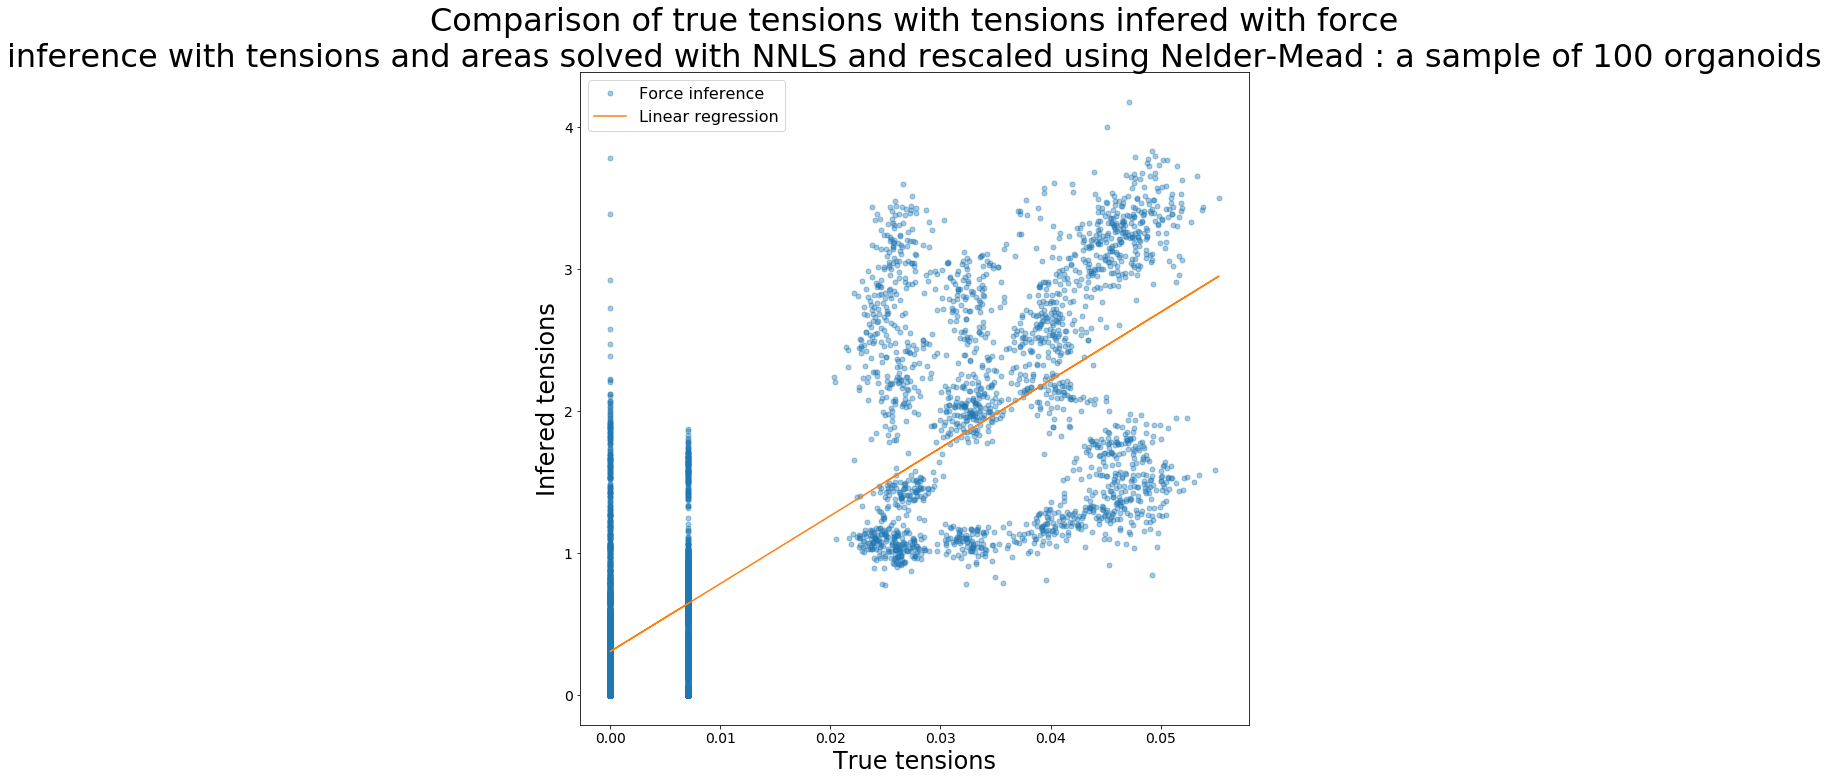

R value : 0.7852573531088288 
Standard error : 5.386290926426798 
Distance : 44.58515060014739


In [50]:
rendering_results(true_tensions_ra_nnls,
                  infered_tensions_ra_nnls,
                  'Comparison of true tensions with tensions infered with force\n' +
                  'inference with tensions and areas solved with NNLS and rescaled using Nelder-Mead : a sample of 100 organoids',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

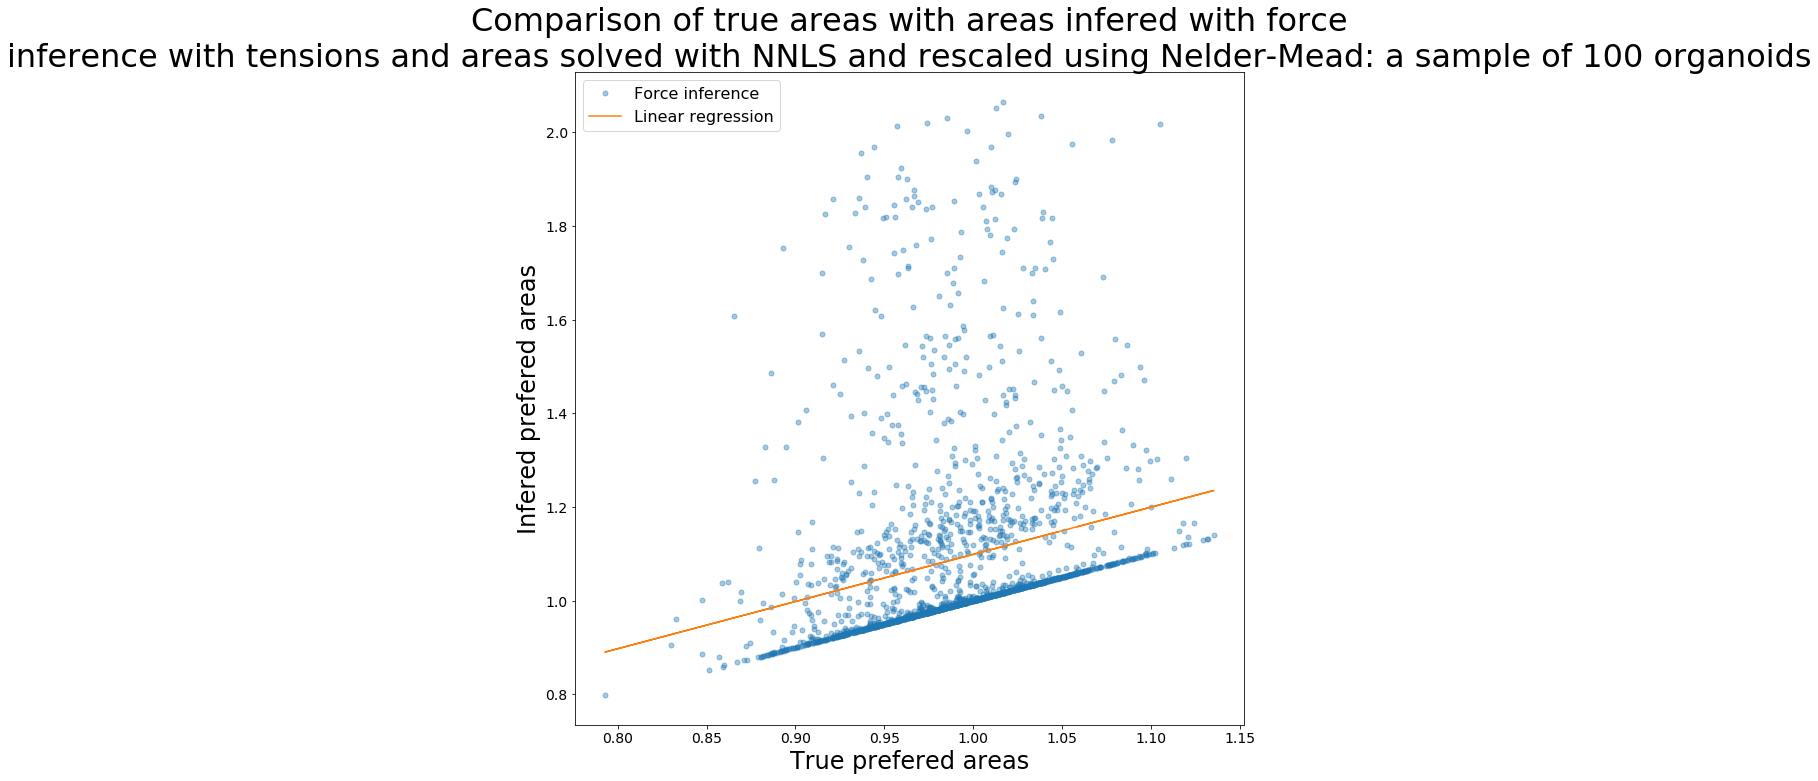

R value : 0.239415140918254 
Standard error : 0.9938786931319559 
Distance : 44.58515060014739


In [55]:
print_infered_areas_ra_nnls = np.concatenate([infered_areas_ra_nnls[(organo.Nf+1)*i:(organo.Nf+1)*i+organo.Nf]
                                             for i in range(0, 100)])
rendering_results(true_areas_ra_nnls,
                  true_areas_ra_nnls+print_infered_areas_ra_nnls,
                  'Comparison of true areas with areas infered with force\n' +
                  'inference with tensions and areas solved with NNLS and rescaled using Nelder-Mead: a sample of 100 organoids',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))